#  Function to transforme the datasets into inputs for ML models

In this notebook I a going to build the datasets to inputs for the ML Algorithms. First I will set for each row the target value and then I will roll features for N number fo days. The idea is to transforme the labeled as:

$$ y_{t+1} = H\Big(\vec{X_t},\vec{X_{t-1}},...,\vec{X_{t-N}}\Big)$$

For $y_{t+1}$ could be the closing price, the daily return ($R_t$) or the log return ($r_t$) of the currency pair. 

The dialy return is defined as:

$$R_t= \frac{P_{t}-P_{t-1}}{P_{t-1}}$$

where the $P_{t}$ is the closing price at $t$. The log return is defined as:

$$r_t=\ln \left( 1+R_t \right)= \ln \bigg( \frac{P_{t}}{P_{t-1}} \bigg)$$



In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import namedtuple
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score,make_scorer
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from collections import Counter ,OrderedDict
from itertools import compress
%matplotlib inline

In [2]:
Dataset=namedtuple('Dataset','exchange df')
DatasetMLModel= namedtuple('DatasetMLModel','exchange df train_size tscv_split test_size')
Regressor= namedtuple('Regressor','name regressor_class params type')
FeatureSelection= namedtuple('FeatureSelection','dataset regressor params RFECV')


with open('datasets/datasets.pkl', 'rb') as input1:
    datasets = pickle.load(input1)
with open('datasets/log_datasets.pkl', 'rb') as input2:
    log_datasets = pickle.load(input2)
with open('datasets/rescaled_datasets.pkl', 'rb') as input3:
    rescaled_datasets = pickle.load(input3)   
with open('datasets/log_divided_close_datasets.pkl', 'rb') as input4:
    log_divided_close_datasets = pickle.load(input4)   
    
    
def all_datasets(func,datasets ):
    for key,dataset in datasets.items():
        print(func.__name__)
        datasets[key]=func(dataset)
def copy_all_datasets(datasets):
    new_dataset={}
    for key,dataset in datasets.items():
        new_dataset[key]=Dataset(dataset.exchange,dataset.df.copy())
    return  new_dataset   

In [3]:


def building_series_to_each_input(dataset,N=15,column_series=['close']):  
    for n in range(1,N+1):
        for column in column_series:
            dataset.df[column+'_{0:02d}'.format(n)]=dataset.df[column].shift(n)
    
    dataset.df.drop(dataset.df.index[:n], inplace=True)
    return dataset

def building_series_to_each_input_log_return(dataset,N=15):
    return building_series_to_each_input(column_series=['log_return'])

def building_series_to_each_input_log_return(dataset,N=15):
    return building_series_to_each_input(column_series=['Returns'])


# datasets_series['btc_cop'].df


In [4]:
def drop_the_last_row(dataset):
    dataset.df.drop(dataset.df.index[-1], inplace=True)
    return dataset
def making_targets(dataset):
    column_targets=['Returns','close','log_return']
    for column_target in column_targets:
        dataset.df[column_target+'_Target']=dataset.df[column_target].shift(-1)
    return drop_the_last_row(dataset)

# all_datasets(making_targets,datasets) 




In [5]:
datasets['btc_cop'].df.head(10)



open       close        high         low    volume  \
datetime                                                               
2016-11-02  2200000.00  2200000.00  2200000.00  2200000.00  0.862437   
2016-11-03  2250000.00  2038008.07  2250000.00  2026909.28  4.658662   
2016-11-04  2173361.50  2192224.31  2192224.31  2001026.82  2.756679   
2016-11-05  2192224.31  2192224.31  2192224.31  2192224.31  0.000000   
2016-11-06  2192224.31  2192224.31  2192224.31  2192224.31  0.000000   
2016-11-07  2192224.31  2192224.31  2192224.31  2192224.31  0.000000   
2016-11-08  2040100.23  2030280.91  2041656.90  2021216.07  3.516900   
2016-11-09  2211234.00  2210750.00  2231104.84  2210000.00  2.529399   
2016-11-10  2120783.30  2110157.05  2120783.30  2110157.05  1.842925   
2016-11-11  2130780.54  2124669.72  2230000.00  2124669.72  0.367348   

                  EWMA26        EWMA12         EWMA9         MACD   Returns  \
datetime                                                                      
2016-11-02  2.136109e+06  2.139209e+06  2.141161e+06 -3099.683631  0.047349   
2016-11-03  2.108684e+06  2.107264e+06  2.106218e+06  1420.662316 -0.073633   
2016-11-04  2.128058e+06  2.130347e+06  2.131803e+06 -2289.576934  0.075670   
2016-11-05  2.140910e+06  2.145387e+06  2.148180e+06 -4476.897457  0.000000   
2016-11-06  2.150036e+06  2.155838e+06  2.159327e+06 -5802.534417  0.000000   
2016-11-07  2.156833e+06  2.163431e+06  2.167233e+06 -6598.117652  0.000000   
2016-11-08  2.138075e+06  2.137090e+06  2.135596e+06   985.950647 -0.073872   
2016-11-09  2.148104e+06  2.151048e+06  2.152435e+06 -2944.303690  0.088889   
2016-11-10  2.143182e+06  2.143566e+06  2.143185e+06  -383.929502 -0.045502   
2016-11-11  2.140908e+06  2.140206e+06  2.139208e+06   701.236943  0.006878   

            log_return  Bollinger Upper  Bollinger Lower  Heiking_Close  \
datetime                                                                  
2016-11-02    0.046262     2.258904e+06     2.019513e+06   2.200000e+06   
2016-11-03   -0.076484     2.251041e+06     1.963486e+06   2.141229e+06   
2016-11-04    0.072944     2.276593e+06     1.984101e+06   2.139709e+06   
2016-11-05    0.000000     2.283274e+06     2.007499e+06   2.192224e+06   
2016-11-06    0.000000     2.283115e+06     2.028562e+06   2.192224e+06   
2016-11-07    0.000000     2.280070e+06     2.046793e+06   2.192224e+06   
2016-11-08   -0.076743     2.291090e+06     1.983089e+06   2.033314e+06   
2016-11-09    0.085158     2.302113e+06     1.999983e+06   2.215772e+06   
2016-11-10   -0.046569     2.283658e+06     2.003474e+06   2.115470e+06   
2016-11-11    0.006854     2.267757e+06     2.012656e+06   2.152530e+06   

            Heiking High  Heiking Low  Heiking Open  log_MACD    Variance12  
datetime                                                                     
2016-11-02    2200000.00   2200000.00   2108102.870 -0.001450  59847.757945  
2016-11-03    2250000.00   2026909.28   2200000.000  0.000674  71888.629050  
2016-11-04    2192224.31   2001026.82   2144004.035 -0.001075  73123.034991  
2016-11-05    2192224.31   2192224.31   2182792.905 -0.002089  68943.711612  
2016-11-06    2192224.31   2192224.31   2192224.310 -0.002695  63638.245555  
2016-11-07    2192224.31   2192224.31   2192224.310 -0.003054  58319.432823  
2016-11-08    2041656.90   2021216.07   2192224.310  0.000461  77000.156256  
2016-11-09    2231104.84   2210000.00   2035190.570 -0.001370  75532.504423  
2016-11-10    2120783.30   2110157.05   2210992.000 -0.000179  70046.055485  
2016-11-11    2230000.00   2124669.72   2115470.175  0.000328  63775.312953

In [6]:
datasets['btc_cop'].df.tail(10)


open       close        high         low    volume  \
datetime                                                               
2018-03-02  27200000.0  28600000.0  29800000.0  26852000.0  8.782904   
2018-03-03  28600000.0  28000101.0  29798977.0  28000100.0  3.981568   
2018-03-04  28000121.0  28002481.0  28879987.0  28000100.0  2.058805   
2018-03-05  28002482.0  28000002.0  29790989.0  28000002.0  9.481309   
2018-03-06  28000002.0  27008508.0  28999799.0  27008508.0  4.986563   
2018-03-07  28399849.0  27569888.0  28399849.0  26000000.0  6.026502   
2018-03-08  27569984.0  24873999.0  27999438.0  24000000.0  6.746981   
2018-03-09  24800000.0  25300001.0  26367000.0  23001311.0  4.445850   
2018-03-10  25797993.0  25499900.0  25797993.0  24300666.0  1.461456   
2018-03-11  24300700.0  25400000.0  25796997.0  24300700.0  0.622789   

                  EWMA26        EWMA12         EWMA9           MACD   Returns  \
datetime                                                                        
2018-03-02  2.786287e+07  2.757451e+07  2.765819e+07  288363.318783  0.051471   
2018-03-03  2.787303e+07  2.763998e+07  2.772658e+07  233052.468603 -0.020975   
2018-03-04  2.788262e+07  2.769575e+07  2.778176e+07  186872.030785  0.000085   
2018-03-05  2.789132e+07  2.774256e+07  2.782541e+07  148758.935278 -0.000089   
2018-03-06  2.782592e+07  2.762963e+07  2.766203e+07  196296.527855 -0.035410   
2018-03-07  2.780696e+07  2.762044e+07  2.764360e+07  186521.632833  0.020785   
2018-03-08  2.758970e+07  2.719791e+07  2.708968e+07  391794.309008 -0.097784   
2018-03-09  2.742010e+07  2.690592e+07  2.673174e+07  514172.521863  0.017126   
2018-03-10  2.727786e+07  2.668961e+07  2.648537e+07  588247.013167  0.007901   
2018-03-11  2.713876e+07  2.649121e+07  2.626830e+07  647548.144381 -0.003918   

            log_return  Bollinger Upper  Bollinger Lower  Heiking_Close  \
datetime                                                                  
2018-03-02    0.050190     3.062560e+07     2.452341e+07    28113000.00   
2018-03-03   -0.021199     3.046485e+07     2.481511e+07    28599794.50   
2018-03-04    0.000085     3.030858e+07     2.508292e+07    28220672.25   
2018-03-05   -0.000089     3.015692e+07     2.532819e+07    28448368.75   
2018-03-06   -0.036053     2.991839e+07     2.534086e+07    27754204.25   
2018-03-07    0.020572     2.972628e+07     2.551460e+07    27592396.50   
2018-03-08   -0.102901     3.003288e+07     2.436294e+07    26110855.25   
2018-03-09    0.016981     2.988027e+07     2.393158e+07    24867078.00   
2018-03-10    0.007870     2.962366e+07     2.375556e+07    25349138.00   
2018-03-11   -0.003925     2.935983e+07     2.362259e+07    24949599.25   

            Heiking High  Heiking Low  Heiking Open  log_MACD    Variance12  
datetime                                                                     
2018-03-02    29800000.0   26852000.0    26601505.0  0.010403  1.525548e+06  
2018-03-03    29798977.0   28000100.0    27900000.0  0.008396  1.412435e+06  
2018-03-04    28879987.0   28000100.0    28300050.5  0.006725  1.306413e+06  
2018-03-05    29790989.0   28000002.0    28001301.0  0.005348  1.207182e+06  
2018-03-06    28999799.0   27008508.0    28001242.0  0.007079  1.144383e+06  
2018-03-07    28399849.0   26000000.0    27504255.0  0.006730  1.052920e+06  
2018-03-08    27999438.0   24000000.0    27984868.5  0.014303  1.417485e+06  
2018-03-09    26367000.0   23001311.0    26221991.5  0.018930  1.487172e+06  
2018-03-10    25797993.0   24300666.0    25050000.5  0.021801  1.467026e+06  
2018-03-11    25796997.0   24300700.0    25648946.5  0.024150  1.434309e+06

In [7]:
def describe_dataset( dataset):
    display(HTML('<H1>Range Dates</H1>'))
    display(HTML('<H3>Min: '+dataset.df.index.min().strftime('%Y-%m-%d')+'</H3>'))
    display(HTML('<H3>Min: '+dataset.df.index.max().strftime('%Y-%m-%d')+'</H3>'))
    display(HTML('<H1>Min</H1>'))
    print(dataset.df.idxmin())
    display(HTML('<H1>Max</H1>'))
    print(dataset.df.idxmax())    
    display(HTML(dataset.df.describe().to_html()))
    return  dataset 
all_datasets(describe_dataset,datasets)

describe_dataset


open              2016-11-04
close             2016-11-12
high              2016-11-07
low               2016-11-03
volume            2016-12-31
EWMA26            2016-11-07
EWMA12            2016-11-07
EWMA9             2016-11-07
MACD              2017-12-17
Returns           2017-12-21
log_return        2017-12-21
Bollinger Upper   2016-11-07
Bollinger Lower   2016-11-07
Heiking_Close     2016-11-04
Heiking High      2016-11-07
Heiking Low       2016-11-03
Heiking Open      2016-11-08
log_MACD          2017-12-11
Variance12        2016-11-02
dtype: datetime64[ns]


open              2017-12-18
close             2017-12-17
high              2017-12-07
low               2017-12-17
volume            2017-03-10
EWMA26            2017-12-26
EWMA12            2017-12-20
EWMA9             2017-12-19
MACD              2018-02-05
Returns           2018-02-06
log_return        2018-02-06
Bollinger Upper   2017-12-18
Bollinger Lower   2018-01-07
Heiking_Close     2017-12-17
Heiking High      2017-12-07
Heiking Low       2017-12-17
Heiking Open      2017-12-18
log_MACD          2018-02-05
Variance12        2017-12-11
dtype: datetime64[ns]


describe_dataset


open              2016-11-08
close             2016-11-08
high              2016-11-08
low               2017-07-12
volume            2016-11-05
EWMA26            2016-11-03
EWMA12            2016-11-03
EWMA9             2016-11-03
MACD              2017-12-17
Returns           2017-03-18
log_return        2017-03-18
Bollinger Upper   2016-11-13
Bollinger Lower   2016-11-03
Heiking_Close     2016-11-08
Heiking High      2016-11-08
Heiking Low       2017-07-12
Heiking Open      2016-11-09
log_MACD          2017-12-08
Variance12        2016-12-19
dtype: datetime64[ns]


open              2017-12-17
close             2017-12-16
high              2017-05-05
low               2017-12-16
volume            2017-10-10
EWMA26            2018-01-06
EWMA12            2017-12-20
EWMA9             2017-12-20
MACD              2018-02-06
Returns           2017-09-15
log_return        2017-09-15
Bollinger Upper   2017-12-17
Bollinger Lower   2018-01-06
Heiking_Close     2017-05-05
Heiking High      2017-05-05
Heiking Low       2017-12-16
Heiking Open      2017-12-18
log_MACD          2018-02-06
Variance12        2017-12-08
dtype: datetime64[ns]


describe_dataset


open              2017-09-30
close             2017-09-29
high              2017-09-30
low               2017-10-24
volume            2017-08-19
EWMA26            2017-10-01
EWMA12            2017-10-01
EWMA9             2017-10-01
MACD              2017-12-06
Returns           2017-12-07
log_return        2017-12-07
Bollinger Upper   2017-08-24
Bollinger Lower   2017-12-06
Heiking_Close     2017-09-30
Heiking High      2017-09-30
Heiking Low       2017-10-24
Heiking Open      2017-10-01
log_MACD          2017-12-06
Variance12        2017-08-20
dtype: datetime64[ns]


open              2017-12-07
close             2017-12-06
high              2017-12-06
low               2017-12-24
volume            2018-02-05
EWMA26            2017-12-19
EWMA12            2017-12-06
EWMA9             2017-12-06
MACD              2018-02-05
Returns           2017-12-06
log_return        2017-12-06
Bollinger Upper   2017-12-06
Bollinger Lower   2018-01-14
Heiking_Close     2017-12-07
Heiking High      2017-12-06
Heiking Low       2017-12-24
Heiking Open      2017-12-08
log_MACD          2018-02-05
Variance12        2017-12-06
dtype: datetime64[ns]


describe_dataset


open              2017-12-07
close             2017-11-27
high              2017-11-30
low               2017-11-06
volume            2017-07-23
EWMA26            2017-12-11
EWMA12            2017-12-11
EWMA9             2017-12-11
MACD              2018-01-14
Returns           2017-11-27
log_return        2017-11-27
Bollinger Upper   2017-12-11
Bollinger Lower   2017-11-30
Heiking_Close     2017-12-07
Heiking High      2017-11-30
Heiking Low       2017-11-06
Heiking Open      2017-12-08
log_MACD          2018-01-14
Variance12        2017-09-23
dtype: datetime64[ns]


open              2018-02-01
close             2018-01-31
high              2017-12-21
low               2018-01-31
volume            2017-12-07
EWMA26            2018-02-11
EWMA12            2018-02-04
EWMA9             2018-02-01
MACD              2017-11-03
Returns           2017-11-28
log_return        2017-11-28
Bollinger Upper   2018-01-31
Bollinger Lower   2018-02-11
Heiking_Close     2018-02-01
Heiking High      2017-12-21
Heiking Low       2018-01-31
Heiking Open      2018-02-01
log_MACD          2017-11-03
Variance12        2017-11-27
dtype: datetime64[ns]


describe_dataset


open              2017-07-16
close             2017-07-15
high              2017-07-16
low               2017-07-16
volume            2018-02-28
EWMA26            2017-07-30
EWMA12            2017-07-30
EWMA9             2017-07-17
MACD              2018-01-14
Returns           2017-12-21
log_return        2017-12-21
Bollinger Upper   2017-07-31
Bollinger Lower   2017-07-16
Heiking_Close     2017-07-16
Heiking High      2017-07-16
Heiking Low       2017-07-16
Heiking Open      2017-07-17
log_MACD          2017-12-20
Variance12        2017-11-06
dtype: datetime64[ns]


open              2018-01-15
close             2018-01-14
high              2018-01-10
low               2018-01-14
volume            2017-12-13
EWMA26            2018-01-19
EWMA12            2018-01-15
EWMA9             2018-01-15
MACD              2018-02-05
Returns           2018-02-06
log_return        2018-02-06
Bollinger Upper   2018-01-15
Bollinger Lower   2018-01-31
Heiking_Close     2018-01-14
Heiking High      2018-01-10
Heiking Low       2018-01-14
Heiking Open      2018-01-16
log_MACD          2018-02-08
Variance12        2018-01-09
dtype: datetime64[ns]


describe_dataset


open              2017-09-15
close             2017-09-25
high              2017-09-14
low               2017-11-02
volume            2017-09-30
EWMA26            2017-11-05
EWMA12            2017-11-02
EWMA9             2017-09-25
MACD              2018-01-14
Returns           2017-09-25
log_return        2017-09-25
Bollinger Upper   2017-11-06
Bollinger Lower   2017-09-25
Heiking_Close     2017-11-02
Heiking High      2017-09-14
Heiking Low       2017-11-02
Heiking Open      2017-09-26
log_MACD          2017-12-20
Variance12        2017-08-13
dtype: datetime64[ns]


open              2018-01-15
close             2018-01-13
high              2018-01-10
low               2018-01-14
volume            2018-01-17
EWMA26            2018-01-31
EWMA12            2018-01-15
EWMA9             2018-01-15
MACD              2018-02-10
Returns           2017-09-26
log_return        2017-09-26
Bollinger Upper   2018-01-14
Bollinger Lower   2018-01-31
Heiking_Close     2018-01-10
Heiking High      2018-01-10
Heiking Low       2018-01-14
Heiking Open      2018-01-15
log_MACD          2018-02-10
Variance12        2018-01-13
dtype: datetime64[ns]


describe_dataset


open              2017-10-24
close             2017-11-06
high              2017-09-14
low               2017-10-24
volume            2017-08-19
EWMA26            2017-11-07
EWMA12            2017-11-06
EWMA9             2017-11-06
MACD              2017-12-19
Returns           2017-12-16
log_return        2017-12-16
Bollinger Upper   2017-08-21
Bollinger Lower   2017-12-15
Heiking_Close     2017-10-24
Heiking High      2017-09-14
Heiking Low       2017-10-24
Heiking Open      2017-10-25
log_MACD          2017-12-19
Variance12        2017-08-21
dtype: datetime64[ns]


open              2017-12-23
close             2017-12-15
high              2018-01-21
low               2017-12-23
volume            2018-02-15
EWMA26            2018-01-31
EWMA12            2018-01-14
EWMA9             2018-01-14
MACD              2018-02-08
Returns           2017-12-23
log_return        2017-12-23
Bollinger Upper   2017-12-24
Bollinger Lower   2018-01-31
Heiking_Close     2017-12-23
Heiking High      2018-01-21
Heiking Low       2017-12-23
Heiking Open      2017-12-24
log_MACD          2018-03-09
Variance12        2017-12-19
dtype: datetime64[ns]


describe_dataset


low               2018-02-16
volume            2013-08-18
amount            2013-08-18
avg_price         2013-07-09
open              2013-07-04
close             2013-07-03
high              2013-07-10
quantity          2013-08-18
EWMA26            2013-07-28
EWMA12            2013-07-11
EWMA9             2013-07-10
MACD              2017-12-18
Returns           2013-09-06
log_return        2013-09-06
Bollinger Upper   2013-07-28
Bollinger Lower   2013-07-09
Heiking_Close     2013-07-07
Heiking High      2013-07-10
Heiking Low       2018-02-16
Heiking Open      2013-07-08
log_MACD          2013-11-29
Variance12        2013-06-27
dtype: datetime64[ns]


low               2017-12-18
volume            2017-12-07
amount            2017-12-07
avg_price         2017-12-18
open              2017-12-19
close             2017-12-18
high              2017-12-17
quantity          2017-11-29
EWMA26            2018-01-08
EWMA12            2017-12-20
EWMA9             2017-12-20
MACD              2018-02-06
Returns           2013-11-18
log_return        2013-11-18
Bollinger Upper   2017-12-18
Bollinger Lower   2018-01-08
Heiking_Close     2017-12-18
Heiking High      2017-12-17
Heiking Low       2017-12-18
Heiking Open      2017-12-19
log_MACD          2018-02-06
Variance12        2017-12-18
dtype: datetime64[ns]


## Size of the tests

I will split the datasets as:
Test=20%
Evaluation=20%
Trainning=80%


In [8]:
def make_test_train_cv_indexes(dataset, train_percent=0.80,evaluation_percent=0.20 ):
    rows, columns=dataset.df.shape
    train_size= int(rows*train_percent)
    tscv_split=int(rows//(train_size*evaluation_percent)-1)
    test_size=rows-train_size
    return DatasetMLModel(dataset.exchange,dataset.df ,train_size ,tscv_split,test_size)

# all_datasets(make_test_train_cv_indexes,datasets) 
# datasets['btc_cop'].train_size
# datasets['btc_brl'].tscv_split


In [9]:
# from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
# from sklearn.svm import SVR
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# Dataset=namedtuple('Dataset','exchange df')
# DatasetMLModel= namedtuple('DatasetMLModel','exchange df train_size tscv_split test_size')
# Regressor= namedtuple('Regressor','name regressor_class params type')
# FeatureSelection= namedtuple('FeatureSelection','dataset regressor params RFECV')

regressors={
    'LinearRegression': Regressor('LinearRegression', LinearRegression, None,'linear_model'),
#    'Ridge':Regressor('Ridge', Ridge, None,'linear_model'),
    'Lasso':Regressor('Lasso', Lasso, None,'linear_model'),
#Error it is for categorical features    'LogisticRegression':Regressor('LogisticRegression', LogisticRegression, None,'linear_model'),
#    'SVR':Regressor('SVR', SVR, None,'svm'),
#    KernelRidge':Regressor('KernelRidge', KernelRidge, None,'svm'),
    'DecisionTreeRegressor':Regressor('DecisionTreeRegressor', DecisionTreeRegressor, None,'tree'),
    'GradientBoostingRegressor':Regressor('GradientBoostingRegressor', GradientBoostingRegressor, None,'ensemble')
}




In [10]:



def make_X_Y(dataset, features=['close'],target=['close_Target']):
    X=dataset.df[features]
    y=dataset.df[target]
    return X,y
# X , y = make_X_Y(datasets['btc_cop'],features)
# X

In [11]:
# regressors_test={
#    'LinearRegression': Regressor('LinearRegression', LinearRegression, None,'linear_model')
# }

def reduce_features(datasets, regressors,features=['close'],target=['close_Target']):
    feature_selections={}
    for key_dataset,dataset in datasets.items():
        for key_regressor,regresor in regressors.items():
            reg=regresor.regressor_class()
            r2_scorer = make_scorer(r2_score)
            X , y = make_X_Y(dataset,features,target)
            print(key_regressor)
            print(key_dataset)
            rfecv= RFECV(estimator=reg,
                   step=1, 
                   cv= TimeSeriesSplit(n_splits=dataset.tscv_split),
                   scoring=r2_scorer)
            rfecv.fit(X, y.values.ravel())
            feature_selections[(key_dataset,key_regressor)]=FeatureSelection(key_dataset,
                                 key_regressor,
                                 regresor.params,
                                 rfecv
                                )
    return feature_selections      
    


In [12]:
def plotting_feature_selection(feature_selections,datasets,regressors ):
    len_datasets=len(datasets)
    len_regresor=len(regressors)
    counter_dataset=0
    counter_regresor=0
    fig, axes = plt.subplots(len_datasets, len_regresor, figsize=(19, 19))
    for key_dataset in datasets.keys():
        counter_regresor=0
        for key_regressor in regressors.keys():
            axes[counter_dataset,counter_regresor].set_title(key_dataset+" "+key_regressor +" TrSize:"+ 
                                                             str(datasets[key_dataset].train_size))
            axes[counter_dataset,counter_regresor].set_xlabel("Number of features selected")
            axes[counter_dataset,counter_regresor].set_ylabel("Cross validation score")
            grid_scores_=feature_selections[(key_dataset,key_regressor)].RFECV.grid_scores_
            axes[counter_dataset,counter_regresor].plot(range(1, len(grid_scores_) + 1), grid_scores_)
            counter_regresor+=1
        counter_dataset+=1
    plt.tight_layout()

    



In [13]:
def feature_selection_analysis(datasets,regressors,features,targets):
    all_datasets(make_test_train_cv_indexes,datasets) 
    all_datasets(making_targets,datasets) 
    return reduce_features(datasets,regressors,features,targets )

In [14]:
def get_features_per_regressor(feature_selections,features):
    features_per_regressor={}
    for key,feature_selection in feature_selections.items():
        if max(feature_selection.RFECV.grid_scores_) >=0:            
            dataset,regressor=key
            best_features=list(compress(features,feature_selection.RFECV.get_support()))
            features_per_regressor[regressor]=features_per_regressor.pop(regressor,[])+best_features
    return features_per_regressor

def get_best_score_per_regressor_and_dataset(feature_selections,features):
    columns=['dataset','regressor','Best Score','Number of features','features']
    data=[[dataset,
           regressor,
           max(feature_selection.RFECV.grid_scores_),
           feature_selection.RFECV.n_features_,
           list(compress(features,feature_selection.RFECV.get_support()))
          ]
          for (dataset,regressor),feature_selection in feature_selections.items()]
    best_score_per_regressor_and_dataset=pd.DataFrame(data,columns=columns)
    best_score_per_regressor_and_dataset.set_index(['dataset','regressor'],inplace=True)
    return best_score_per_regressor_and_dataset


def get_count_of_features_per_regresor(features_per_regressor,features):
    count_of_features_per_regresor=pd.DataFrame(columns=features)
    for key,feature_selection in features_per_regressor.items():
        serie=pd.Series(Counter(feature_selection))
        count_of_features_per_regresor.loc[key]=serie
    count_of_features_per_regresor.fillna(0, inplace=True)
    return count_of_features_per_regresor

def plot_features(count_of_features_per_regresor):

    plt.figure(figsize=(20,20), dpi=100)

    # Get some pastel shades for the colors
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(count_of_features_per_regresor.index)))
    n_rows = len(count_of_features_per_regresor.index)
    indexes = np.arange(len(count_of_features_per_regresor.columns.values)) + 0
    bar_width = 0.4

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(count_of_features_per_regresor.columns.values))

    # Plot bars and create text labels for the table
    cell_text = []
    for index, row in count_of_features_per_regresor.iterrows():
        loc=count_of_features_per_regresor.index.get_loc(index)
        plt.bar(indexes, row, bar_width, bottom=y_offset, color=colors[loc])
        y_offset = y_offset + row
        cell_text.append(row)
    # Reverse colors and text labels to display the last value at the top.
    # colors = colors[::-1]
    # cell_text.reverse()
    if len(cell_text)!=0:
        
        # Add a table at the bottom of the axes
        the_table = plt.table(cellText=cell_text,
                              rowLabels=count_of_features_per_regresor.index.values,
                              rowColours=colors,
                              colLabels=count_of_features_per_regresor.columns.values,
                              loc='bottom')

    # Adjust layout to make room for the table:
    # plt.subplots_adjust(left=0.2, bottom=0.2)
    plt.xticks([])
    plt.title('Feature selection per regressor')
    plt.tight_layout()

In [15]:
def plot_feature_analysis(feature_selections,features):
    features_per_regressor = get_features_per_regressor(feature_selections,features)    
    count_of_features_per_regresor=get_count_of_features_per_regresor(features_per_regressor,features)
    plot_features(count_of_features_per_regresor)


In [16]:
def delete_bad_results(score):
    return score[score['Best Score']>=0]


In [17]:
features=['open','close','high','low','volume','EWMA26','EWMA12','EWMA9','MACD',
          'Returns','log_return','Bollinger Upper','Bollinger Lower','Heiking_Close',
          'Heiking High','Heiking Low','Heiking Open','log_MACD','Variance12']

target_close=['close_Target']
target_returns=['Returns_Target']
target_log_return=['log_return_Target']

## Analysis Dataset Clean Close

In [18]:
feature_selections=feature_selection_analysis(datasets,regressors,features,target_close)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_brl
GradientBoostingRegressor
btc_brl


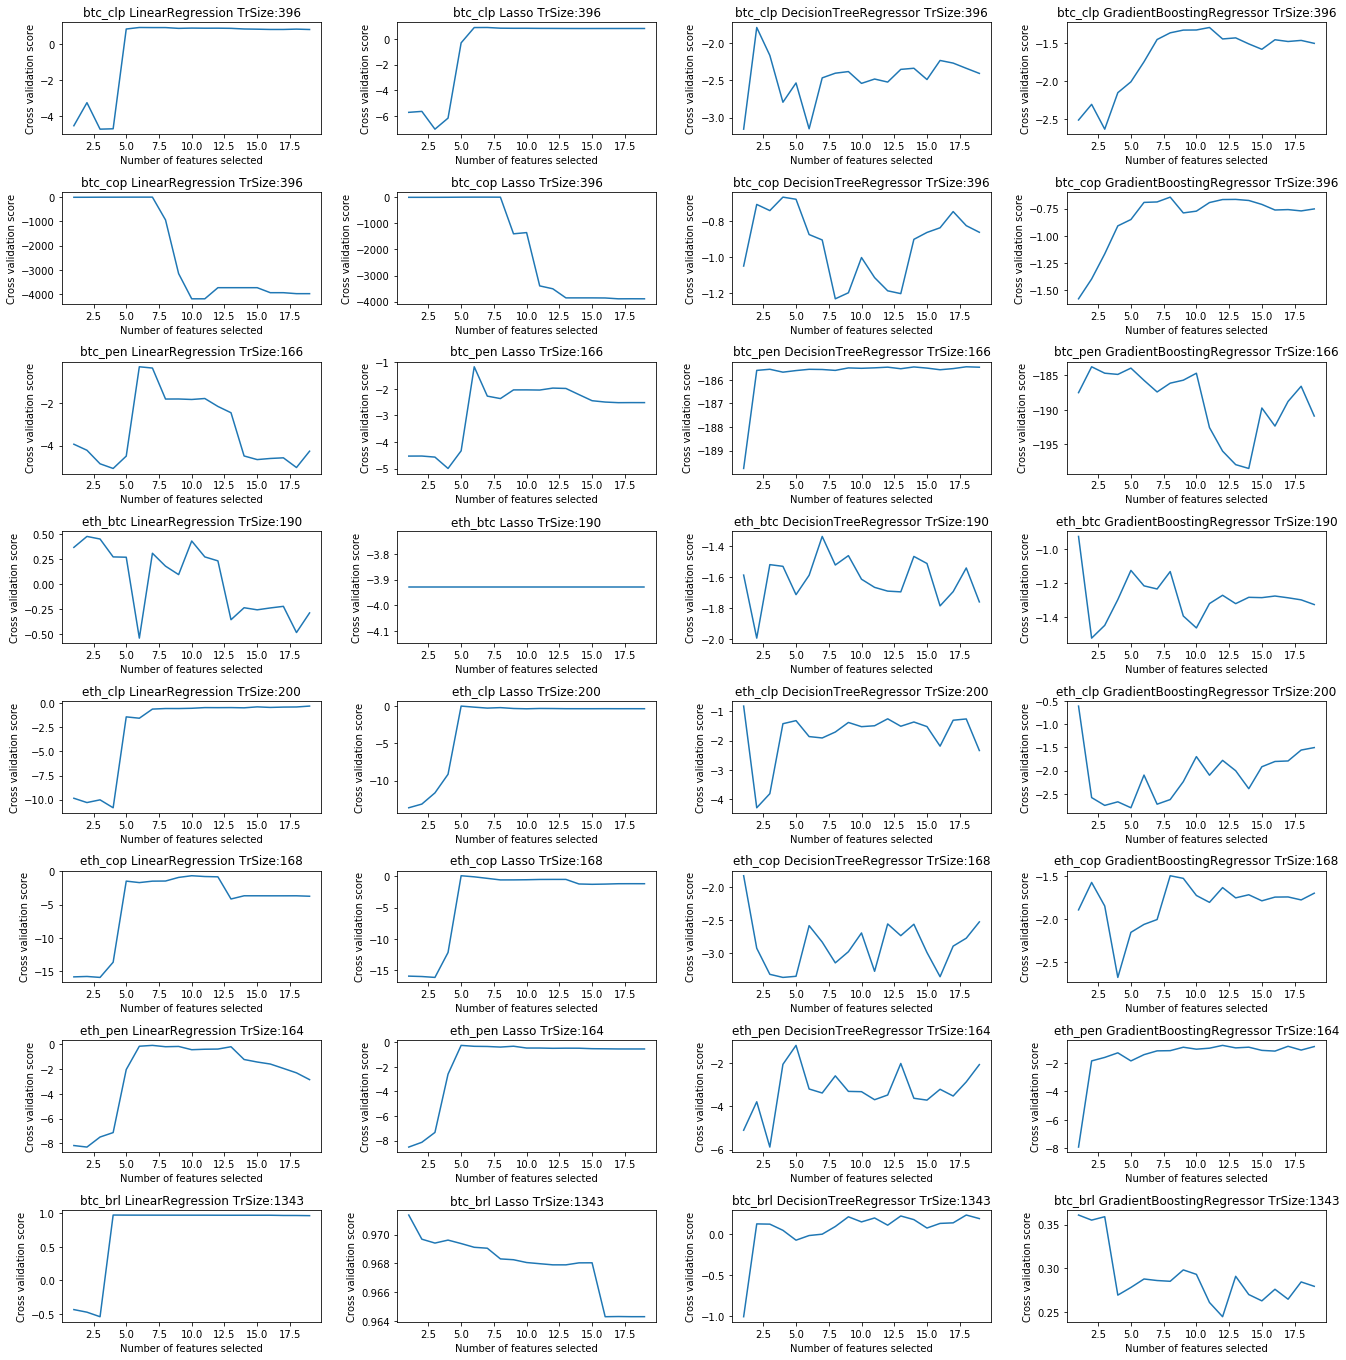

In [19]:
plotting_feature_selection(feature_selections,datasets,regressors )

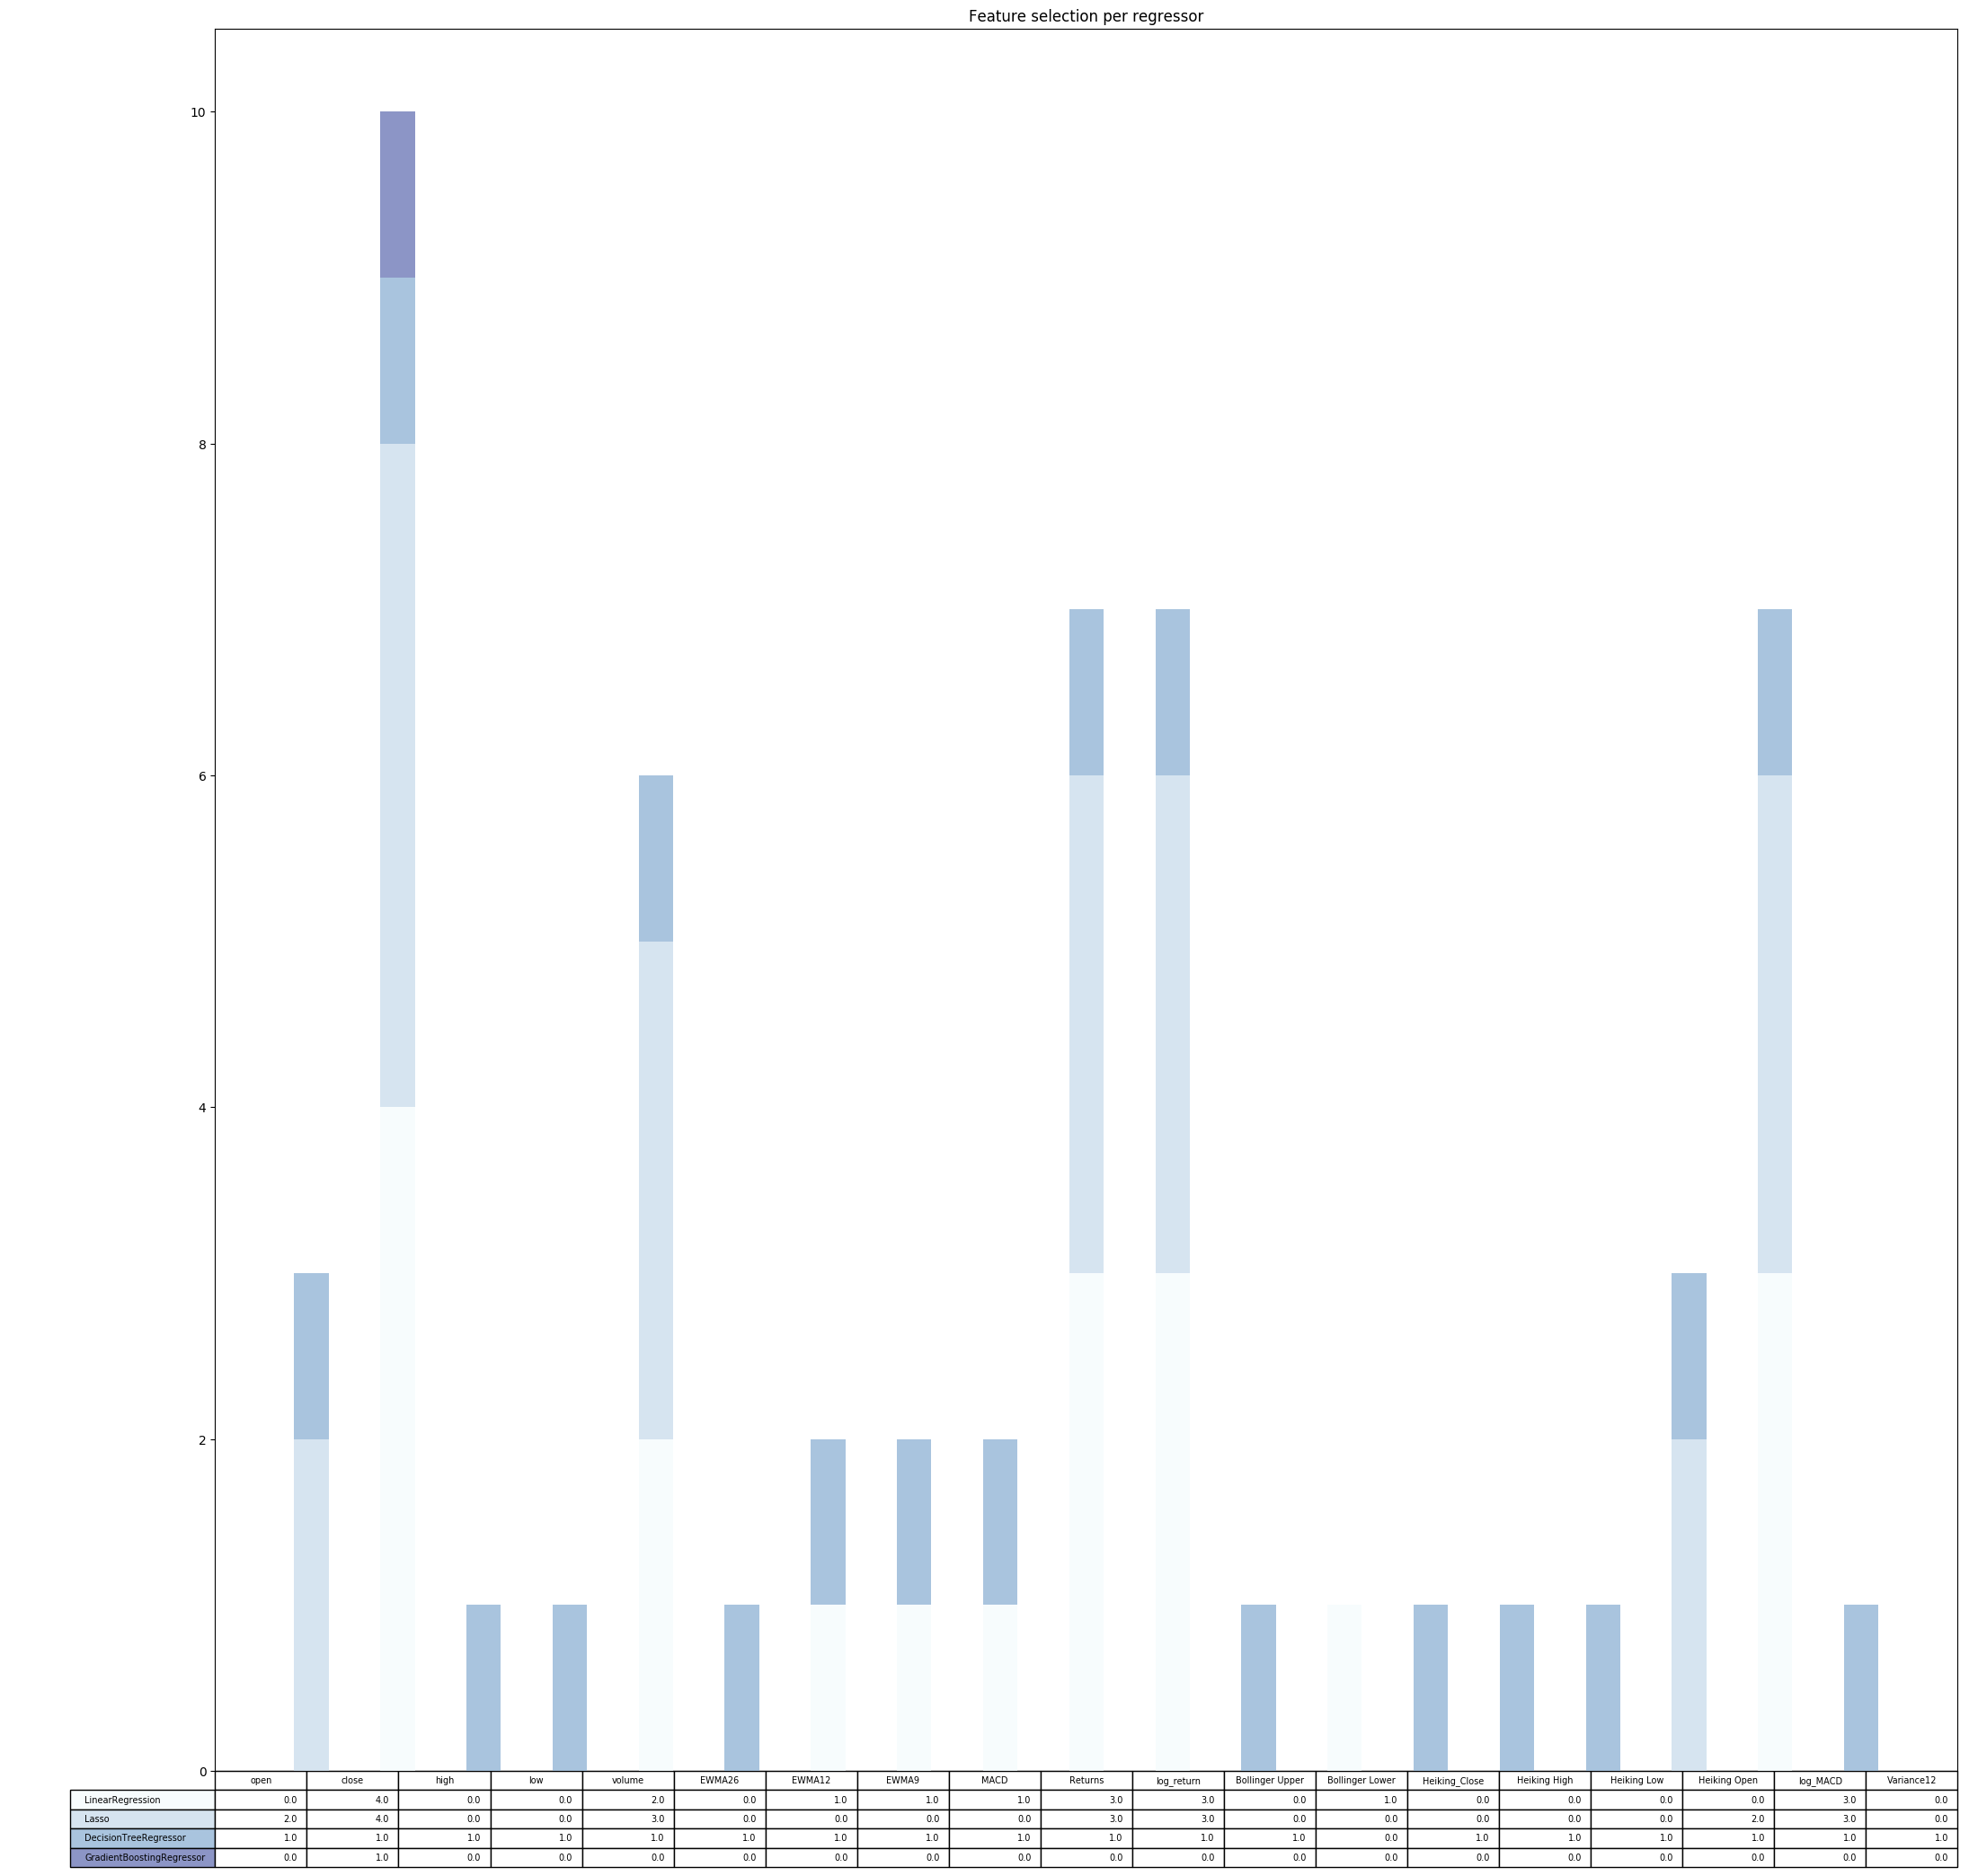

In [20]:
plot_feature_analysis(feature_selections,features)

In [21]:
score_clean_close=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)
score_clean_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl Lasso                        0.971353                   1   
        LinearRegression             0.970170                   4   
btc_clp LinearRegression             0.901397                   6   
        Lasso                        0.882849                   7   
btc_cop Lasso                        0.838280                   7   
        LinearRegression             0.832927                   7   
eth_btc LinearRegression             0.472903                   2   
btc_brl GradientBoostingRegressor    0.360831                   1   
        DecisionTreeRegressor        0.229697                  18   
eth_cop Lasso                        0.084915                   5   
eth_clp Lasso                       -0.027682                   5   
eth_pen LinearRegression            -0.089116                   7   
        Lasso                       -0.252618                   5   
eth_clp LinearRegression            -0.281303                  19   
btc_pen LinearRegression            -0.327566                   6   
eth_clp GradientBoostingRegressor   -0.611913                   1   
btc_cop GradientBoostingRegressor   -0.644437                   8   
        DecisionTreeRegressor       -0.667964                   4   
eth_cop LinearRegression            -0.672714                  10   
eth_pen GradientBoostingRegressor   -0.786338                  12   
eth_clp DecisionTreeRegressor       -0.828889                   1   
eth_btc GradientBoostingRegressor   -0.925949                   1   
btc_pen Lasso                       -1.163014                   6   
eth_pen DecisionTreeRegressor       -1.177365                   5   
btc_clp GradientBoostingRegressor   -1.298798                  11   
eth_btc DecisionTreeRegressor       -1.337031                   7   
eth_cop GradientBoostingRegressor   -1.494821                   8   
btc_clp DecisionTreeRegressor       -1.787321                   2   
eth_cop DecisionTreeRegressor       -1.829471                   1   
eth_btc Lasso                       -3.929574                  19   
btc_pen GradientBoostingRegressor -183.755221                   2   
        DecisionTreeRegressor     -185.444014                  18   

                                                                            features  
dataset regressor                                                                     
btc_brl Lasso                                                                [close]  
        LinearRegression                      [close, Returns, log_return, log_MACD]  
btc_clp LinearRegression           [close, volume, Returns, log_return, Bollinger...  
        Lasso                      [open, close, volume, Returns, log_return, Hei...  
btc_cop Lasso                      [open, close, volume, Returns, log_return, Hei...  
        LinearRegression           [close, volume, EWMA12, EWMA9, Returns, log_re...  
eth_btc LinearRegression                                               [close, MACD]  
btc_brl GradientBoostingRegressor                                            [close]  
        DecisionTreeRegressor      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop Lasso                         [close, volume, Returns, log_return, log_MACD]  
eth_clp Lasso                      [volume, log_return, Heiking Low, Heiking Open...  
eth_pen LinearRegression           [volume, EWMA12, EWMA9, MACD, Returns, log_ret...  
        Lasso                                [low, volume, EWMA9, Returns, log_MACD]  
eth_clp LinearRegression           [open, close, high, low, volume, EWMA26, EWMA1...  
btc_pen LinearRegression           [EWMA26, EWMA12, MACD, Returns, log_return, lo...  
eth_clp GradientBoostingRegressor                                            [close]  
btc_cop GradientBoostingRegressor  [close, volume, EWMA12, EWMA9, MACD, Bollinger...  
        DecisionTreeRegressor      

## Analysis Dataset Clean Series Close

In [22]:
# log_datasets.pop('btc_pen',"default")
datasets_series=copy_all_datasets(datasets)    
all_datasets(building_series_to_each_input,datasets_series) 

features_series=['close','volume','log_return','log_MACD','Variance12',
          'close_01','close_02','close_03','close_04','close_05','close_06',
         'close_07','close_08','close_09','close_10','close_11','close_12',
         'close_13','close_14','close_15']


feature_selections_series=feature_selection_analysis(datasets_series,regressors,features_series,target_close)

building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_brl
GradientBoostingRegressor
btc_brl


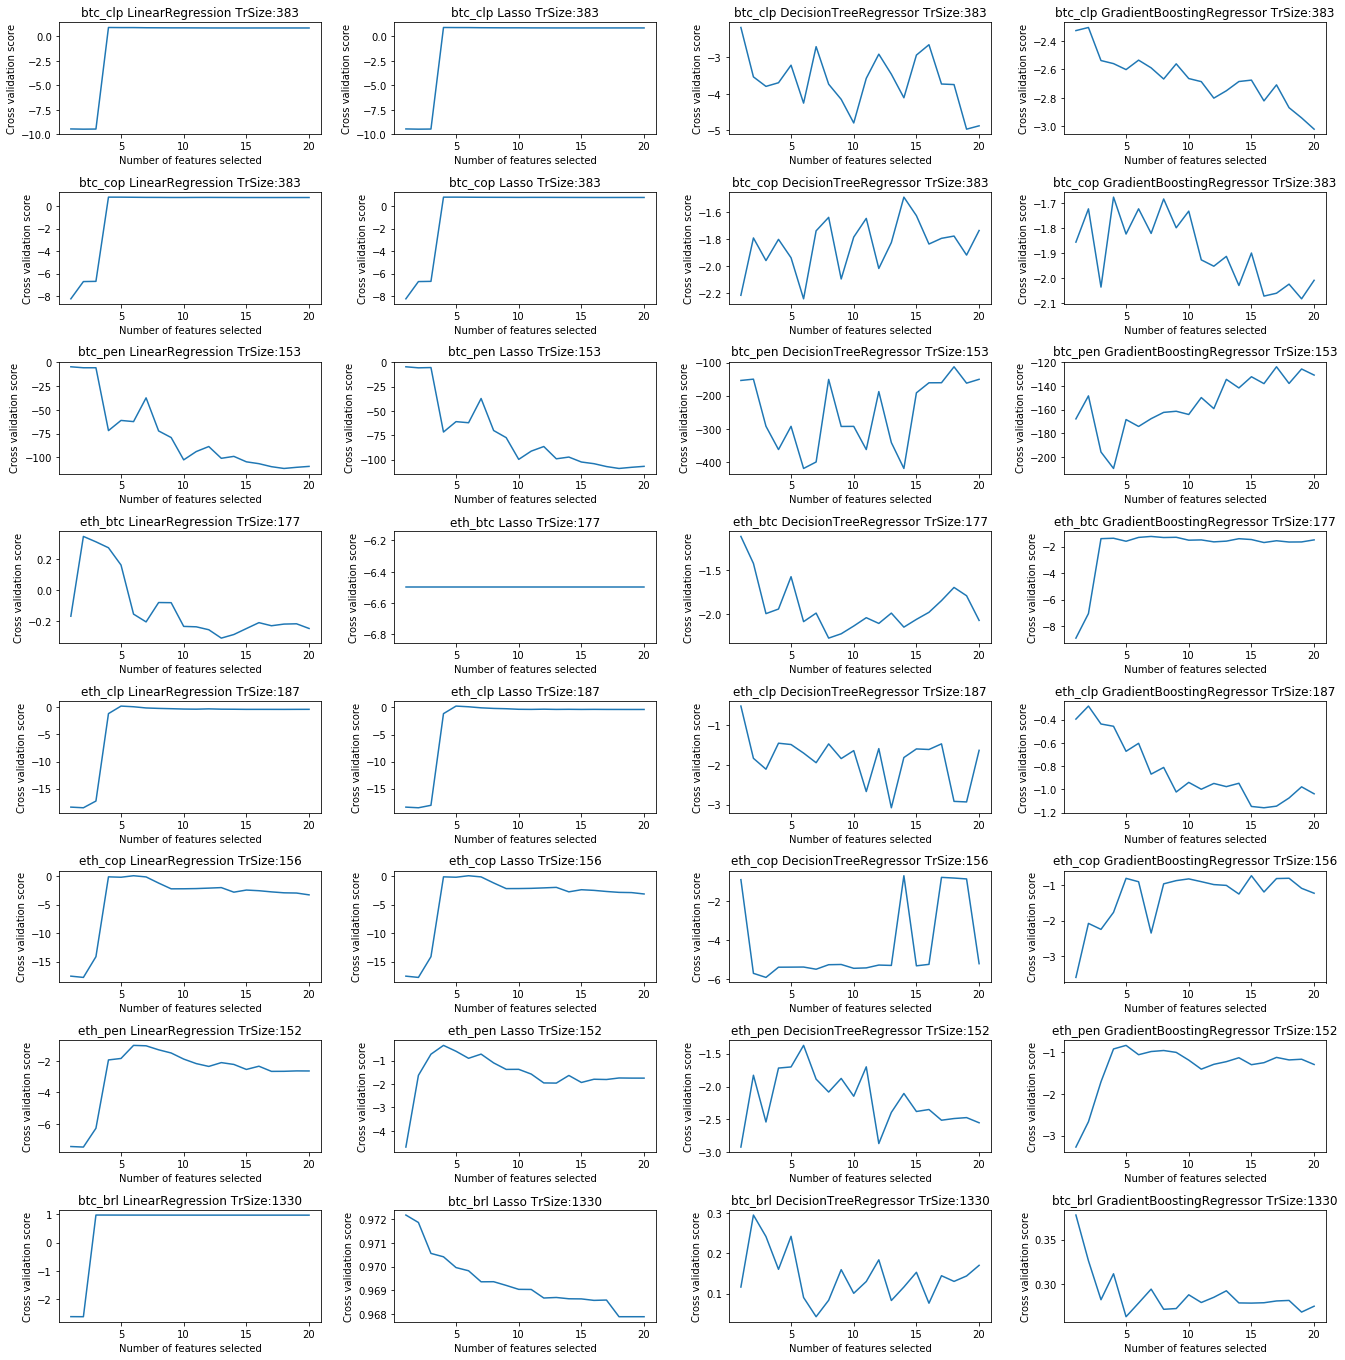

In [23]:
plotting_feature_selection(feature_selections_series,datasets_series,regressors)

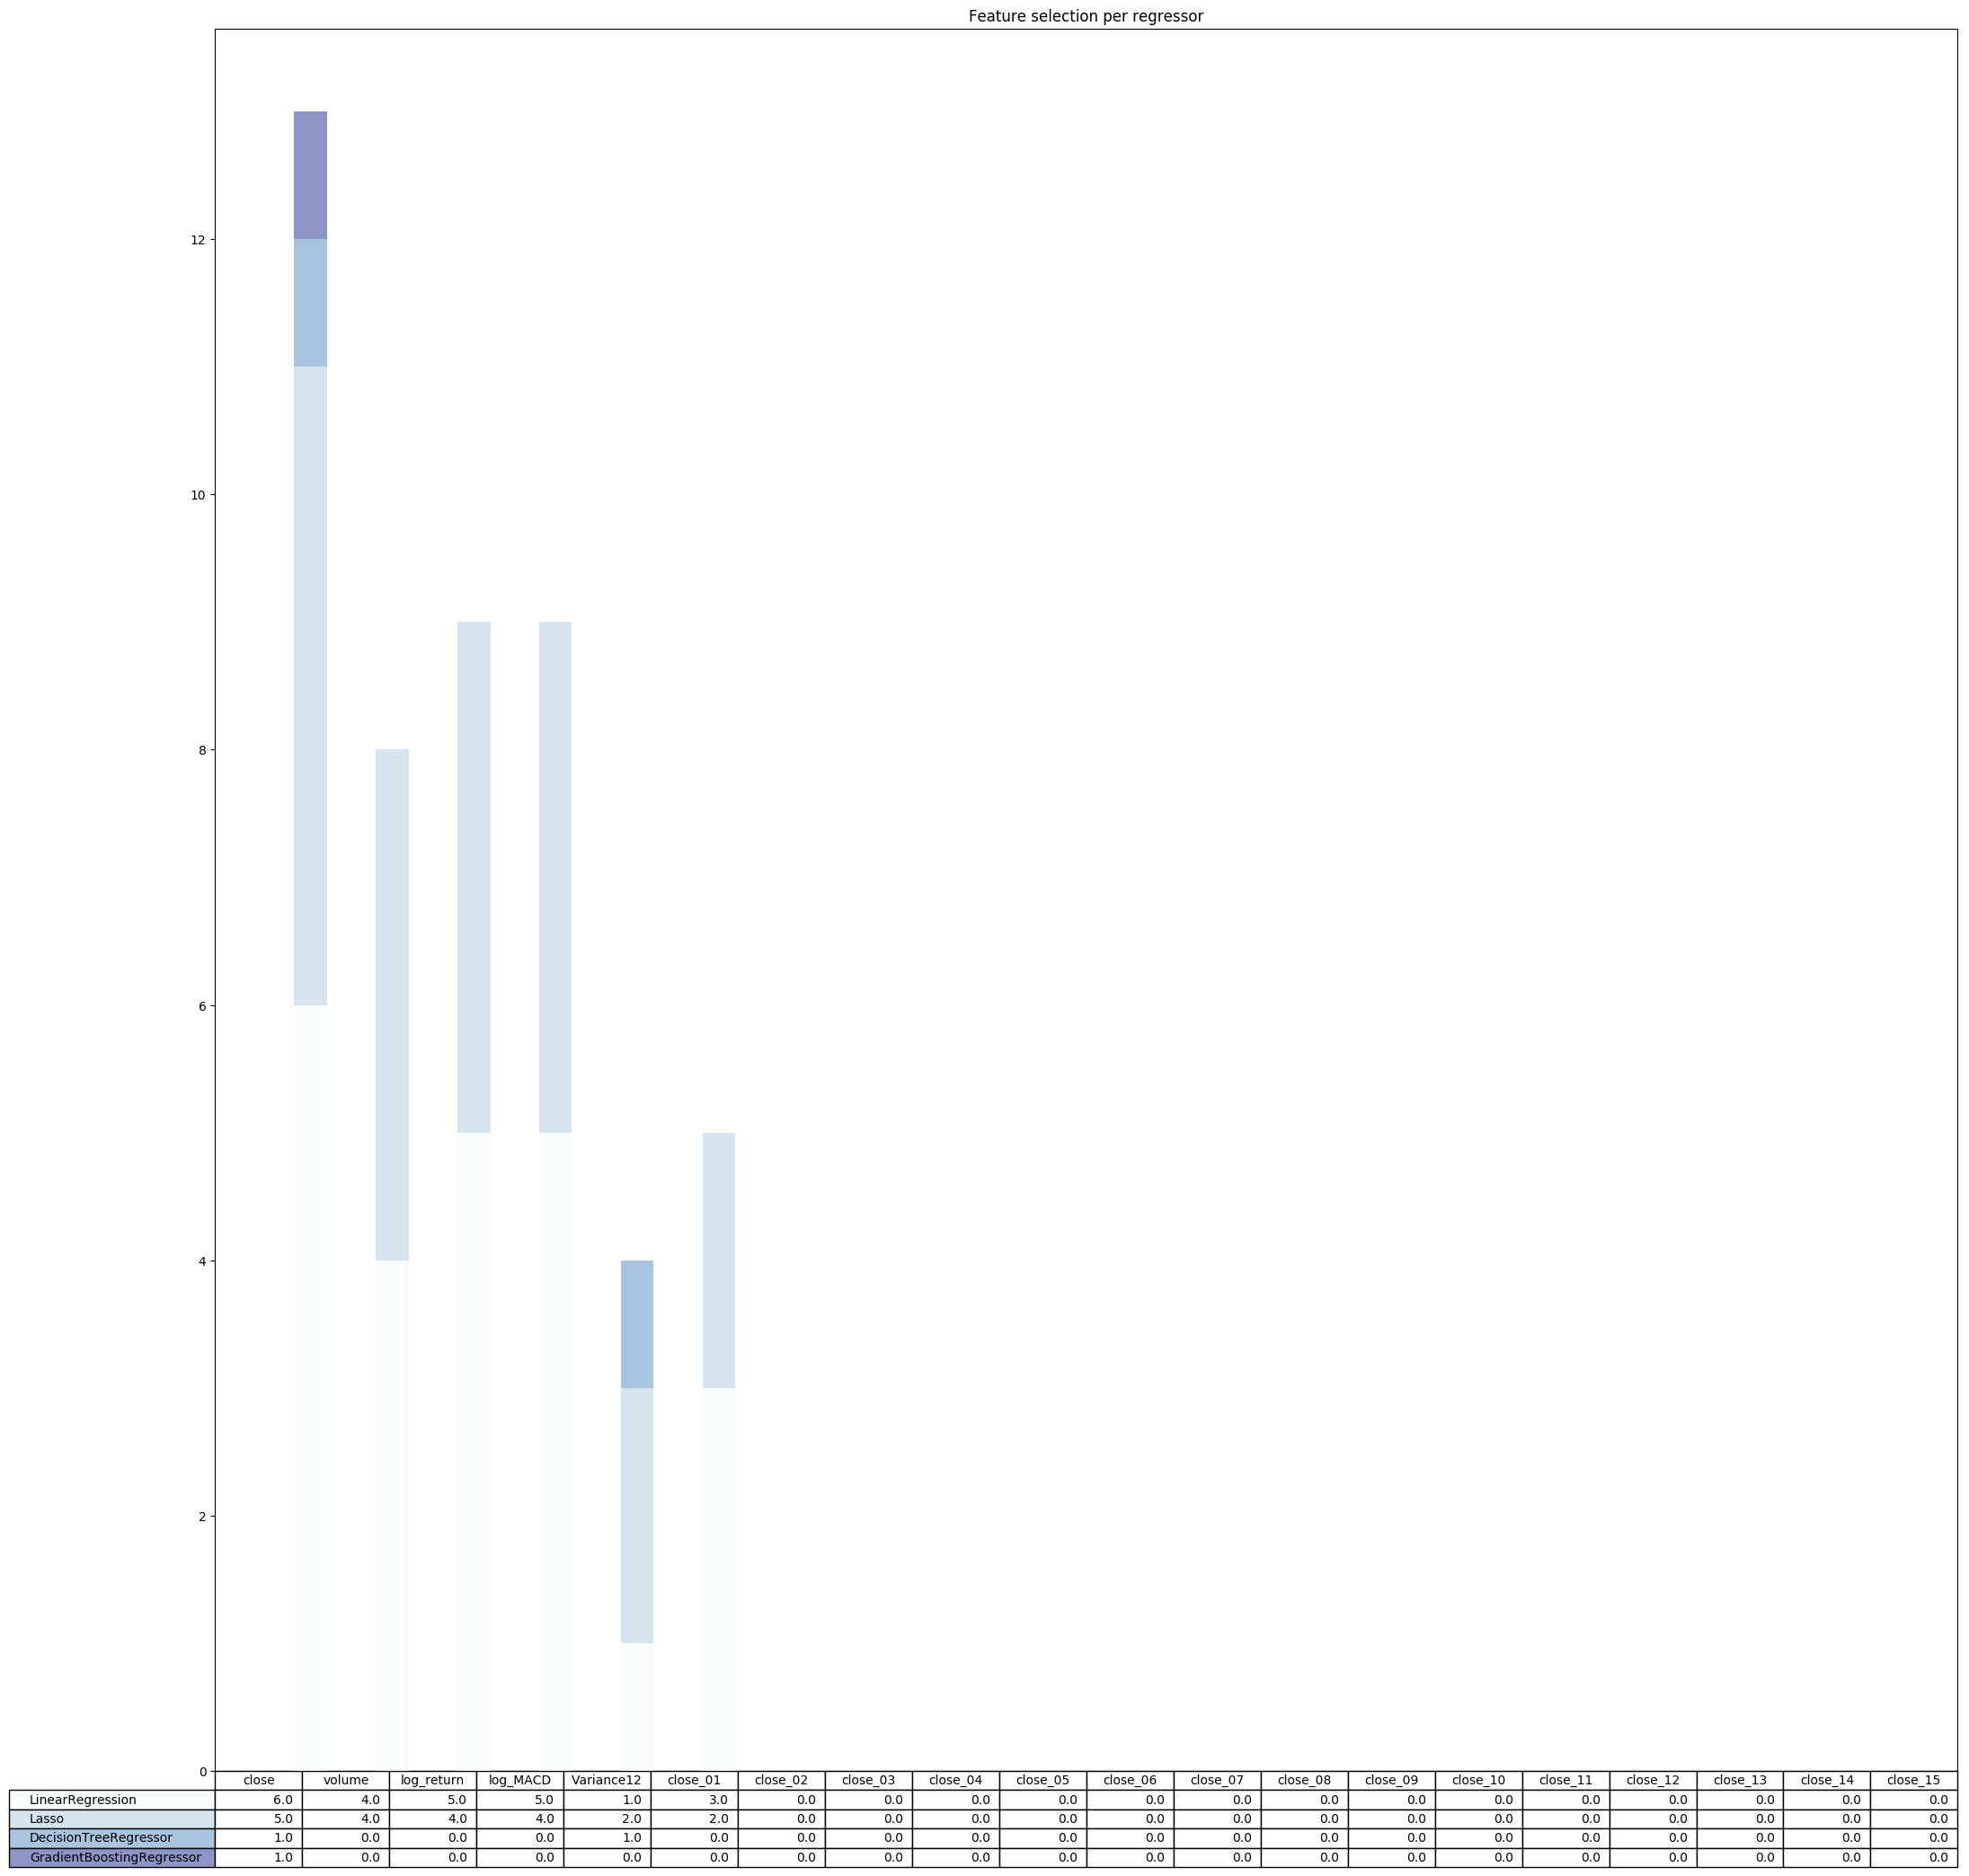

In [24]:
plot_feature_analysis(feature_selections_series,features_series)

In [25]:
score_clean_series_close=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)
score_clean_series_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl Lasso                        0.971353                   1   
        LinearRegression             0.970170                   4   
btc_clp LinearRegression             0.901397                   6   
        Lasso                        0.882849                   7   
btc_cop Lasso                        0.838280                   7   
        LinearRegression             0.832927                   7   
eth_btc LinearRegression             0.472903                   2   
btc_brl GradientBoostingRegressor    0.360831                   1   
        DecisionTreeRegressor        0.229697                  18   
eth_cop Lasso                        0.084915                   5   
eth_clp Lasso                       -0.027682                   5   
eth_pen LinearRegression            -0.089116                   7   
        Lasso                       -0.252618                   5   
eth_clp LinearRegression            -0.281303                  19   
btc_pen LinearRegression            -0.327566                   6   
eth_clp GradientBoostingRegressor   -0.611913                   1   
btc_cop GradientBoostingRegressor   -0.644437                   8   
        DecisionTreeRegressor       -0.667964                   4   
eth_cop LinearRegression            -0.672714                  10   
eth_pen GradientBoostingRegressor   -0.786338                  12   
eth_clp DecisionTreeRegressor       -0.828889                   1   
eth_btc GradientBoostingRegressor   -0.925949                   1   
btc_pen Lasso                       -1.163014                   6   
eth_pen DecisionTreeRegressor       -1.177365                   5   
btc_clp GradientBoostingRegressor   -1.298798                  11   
eth_btc DecisionTreeRegressor       -1.337031                   7   
eth_cop GradientBoostingRegressor   -1.494821                   8   
btc_clp DecisionTreeRegressor       -1.787321                   2   
eth_cop DecisionTreeRegressor       -1.829471                   1   
eth_btc Lasso                       -3.929574                  19   
btc_pen GradientBoostingRegressor -183.755221                   2   
        DecisionTreeRegressor     -185.444014                  18   

                                                                            features  
dataset regressor                                                                     
btc_brl Lasso                                                                [close]  
        LinearRegression                      [close, Returns, log_return, log_MACD]  
btc_clp LinearRegression           [close, volume, Returns, log_return, Bollinger...  
        Lasso                      [open, close, volume, Returns, log_return, Hei...  
btc_cop Lasso                      [open, close, volume, Returns, log_return, Hei...  
        LinearRegression           [close, volume, EWMA12, EWMA9, Returns, log_re...  
eth_btc LinearRegression                                               [close, MACD]  
btc_brl GradientBoostingRegressor                                            [close]  
        DecisionTreeRegressor      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop Lasso                         [close, volume, Returns, log_return, log_MACD]  
eth_clp Lasso                      [volume, log_return, Heiking Low, Heiking Open...  
eth_pen LinearRegression           [volume, EWMA12, EWMA9, MACD, Returns, log_ret...  
        Lasso                                [low, volume, EWMA9, Returns, log_MACD]  
eth_clp LinearRegression           [open, close, high, low, volume, EWMA26, EWMA1...  
btc_pen LinearRegression           [EWMA26, EWMA12, MACD, Returns, log_return, lo...  
eth_clp GradientBoostingRegressor                                            [close]  
btc_cop GradientBoostingRegressor  [close, volume, EWMA12, EWMA9, MACD, Bollinger...  
        DecisionTreeRegressor      

## Analysis Dataset Rescaled Close

In [26]:
feature_selections=feature_selection_analysis(rescaled_datasets,regressors,features,target_close)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen
DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop
DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
Decisio

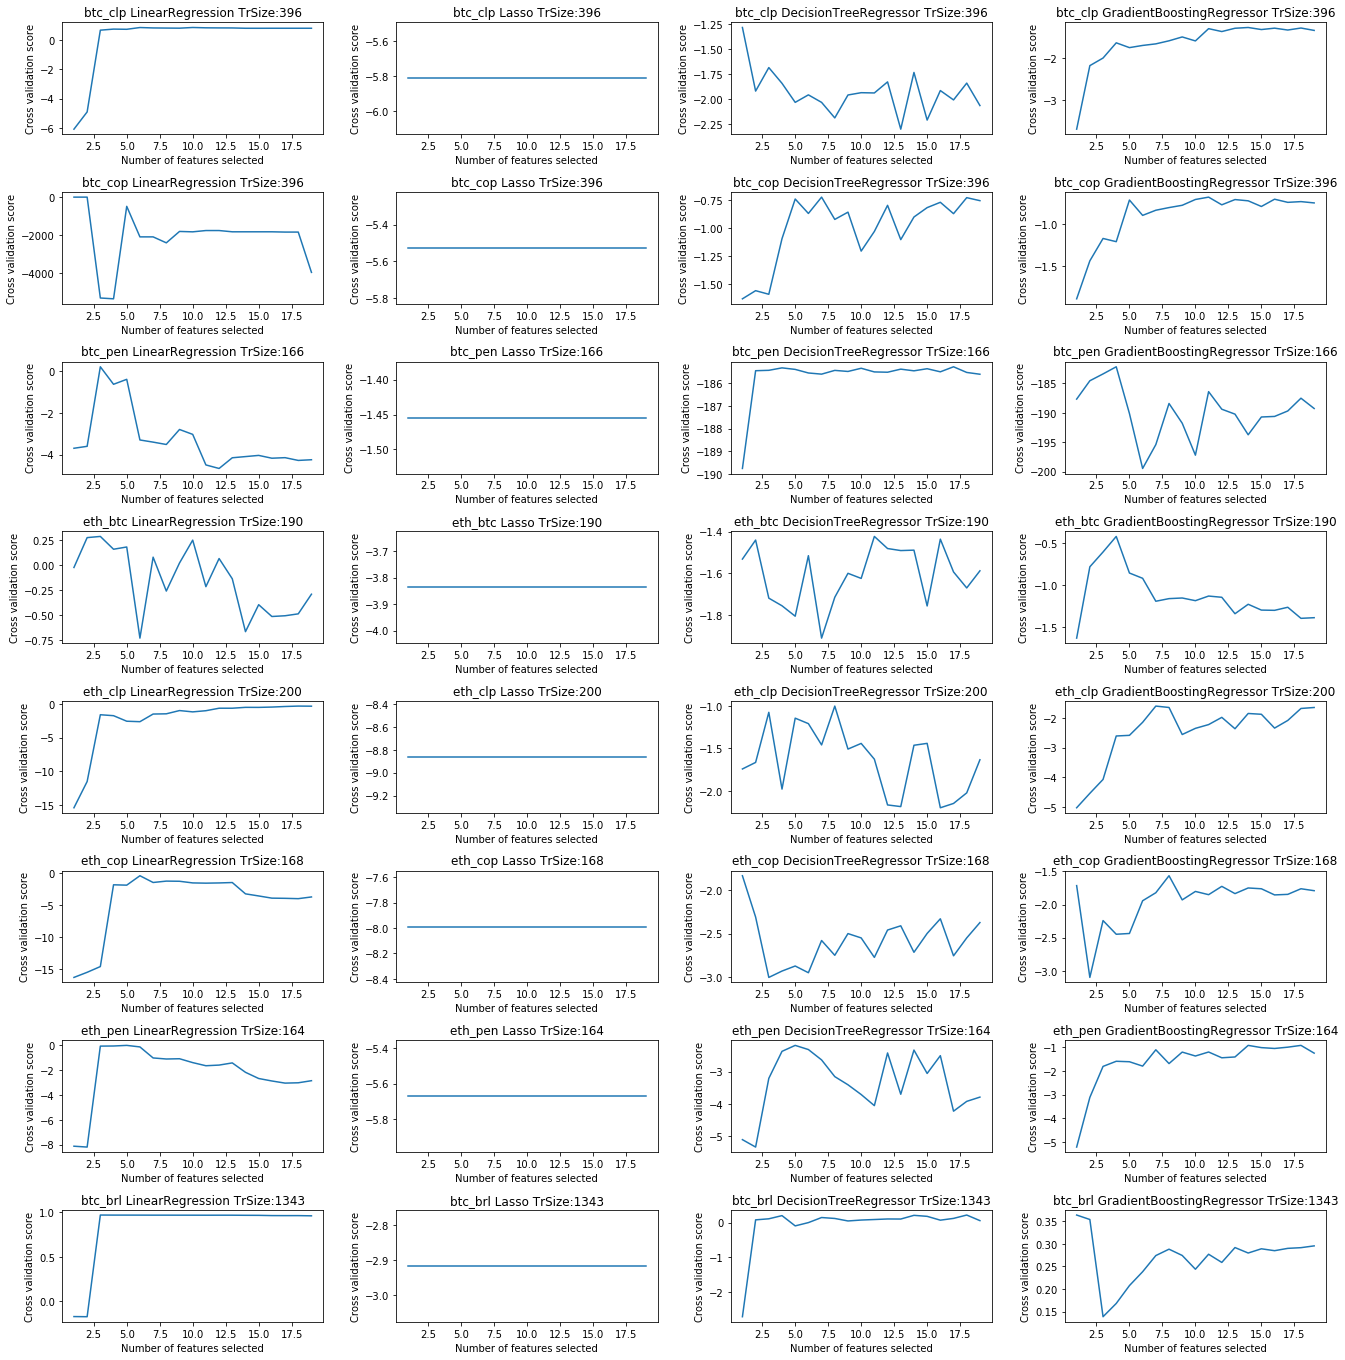

In [27]:
plotting_feature_selection(feature_selections,rescaled_datasets,regressors )

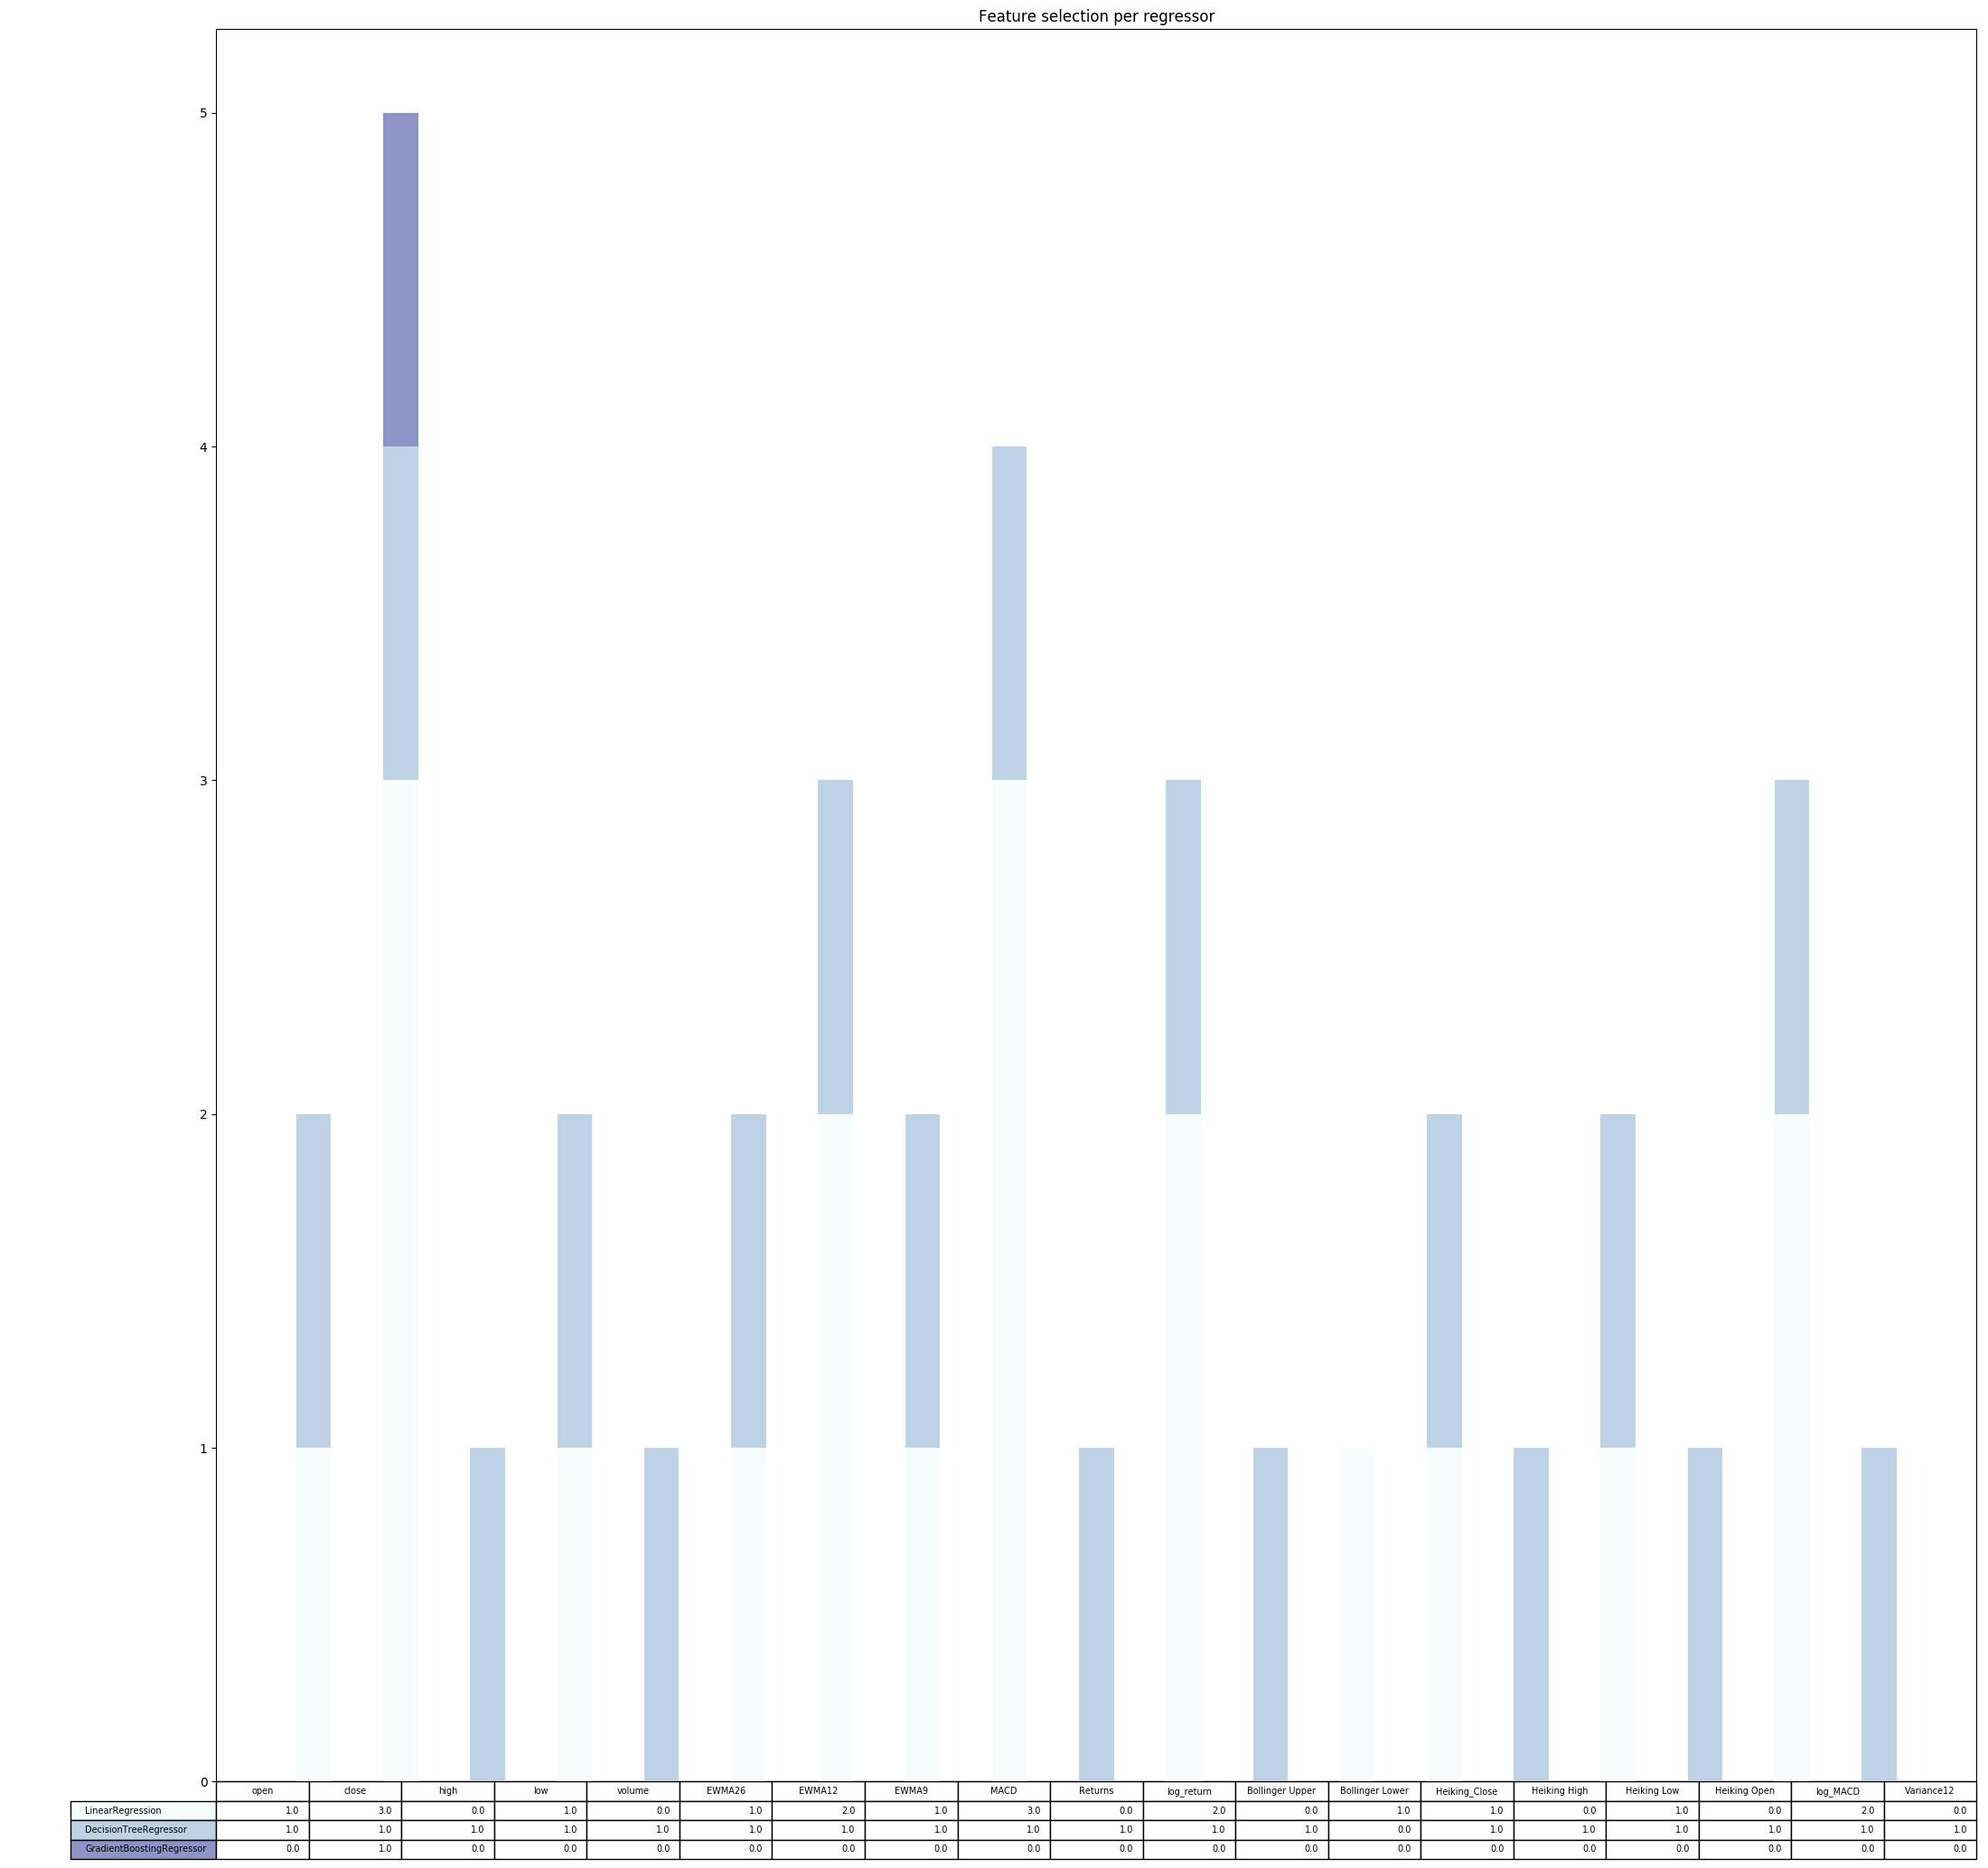

In [28]:
plot_feature_analysis(feature_selections,features)

In [29]:
score_rescaled_close=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)
score_rescaled_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl LinearRegression             0.969786                   3   
btc_clp LinearRegression             0.842974                  10   
btc_brl GradientBoostingRegressor    0.363866                   1   
eth_btc LinearRegression             0.285418                   3   
btc_brl DecisionTreeRegressor        0.218477                  18   
btc_pen LinearRegression             0.205763                   3   
eth_pen LinearRegression            -0.047616                   5   
eth_clp LinearRegression            -0.297222                  18   
eth_btc GradientBoostingRegressor   -0.416794                   4   
eth_cop LinearRegression            -0.446277                   6   
btc_cop GradientBoostingRegressor   -0.671454                  11   
        DecisionTreeRegressor       -0.720745                   7   
eth_pen GradientBoostingRegressor   -0.920294                  14   
eth_clp DecisionTreeRegressor       -0.999246                   8   
btc_clp DecisionTreeRegressor       -1.282579                   1   
        GradientBoostingRegressor   -1.287857                  14   
eth_btc DecisionTreeRegressor       -1.423076                  11   
btc_pen Lasso                       -1.454435                  19   
eth_cop GradientBoostingRegressor   -1.565609                   8   
eth_clp GradientBoostingRegressor   -1.594844                   7   
eth_cop DecisionTreeRegressor       -1.830735                   1   
eth_pen DecisionTreeRegressor       -2.194945                   5   
btc_brl Lasso                       -2.917024                  19   
eth_btc Lasso                       -3.836859                  19   
btc_cop LinearRegression            -5.331545                   1   
        Lasso                       -5.527516                  19   
eth_pen Lasso                       -5.670429                  19   
btc_clp Lasso                       -5.814276                  19   
eth_cop Lasso                       -7.989030                  19   
eth_clp Lasso                       -8.862512                  19   
btc_pen GradientBoostingRegressor -182.168306                   4   
        DecisionTreeRegressor     -185.284006                  17   

                                                                            features  
dataset regressor                                                                     
btc_brl LinearRegression                               [close, log_return, log_MACD]  
btc_clp LinearRegression           [open, close, low, EWMA12, MACD, log_return, B...  
btc_brl GradientBoostingRegressor                                            [close]  
eth_btc LinearRegression                                        [close, EWMA9, MACD]  
btc_brl DecisionTreeRegressor      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_pen LinearRegression                                      [EWMA26, EWMA12, MACD]  
eth_pen LinearRegression                 [EWMA12, EWMA9, MACD, log_return, log_MACD]  
eth_clp LinearRegression           [open, close, high, low, EWMA26, EWMA12, EWMA9...  
eth_btc GradientBoostingRegressor     [close, Heiking High, Heiking Low, Variance12]  
eth_cop LinearRegression           [open, close, MACD, Bollinger Upper, Heiking_C...  
btc_cop GradientBoostingRegressor  [close, low, volume, EWMA26, EWMA12, MACD, Ret...  
        DecisionTreeRegressor      [close, high, EWMA9, MACD, Bollinger Upper, He...  
eth_pen GradientBoostingRegressor  [close, high, volume, EWMA26, EWMA12, EWMA9, M...  
eth_clp DecisionTreeRegressor      [open, close, volume, EWMA26, MACD, Bollinger ...  
btc_clp DecisionTreeRegressor                                        [Heiking_Close]  
        GradientBoostingRegressor  [open, close, volume, EWMA26, EWMA12, EWMA9, M...  
eth_btc DecisionTreeRegressor      [open, close, high, volume, MACD, log_return, ...  
btc_pen Lasso                      

## Analysis Rescaled Clean Series Close

In [30]:
# log_datasets.pop('btc_pen',"default")
datasets_series_rescaled=copy_all_datasets(rescaled_datasets)    
all_datasets(building_series_to_each_input,datasets_series_rescaled) 

features_series=['close','volume','log_return','log_MACD','Variance12',
          'close_01','close_02','close_03','close_04','close_05','close_06',
         'close_07','close_08','close_09','close_10','close_11','close_12',
         'close_13','close_14','close_15']


feature_selections_series=feature_selection_analysis(datasets_series_rescaled,regressors,features_series,target_close)

building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen
DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegres

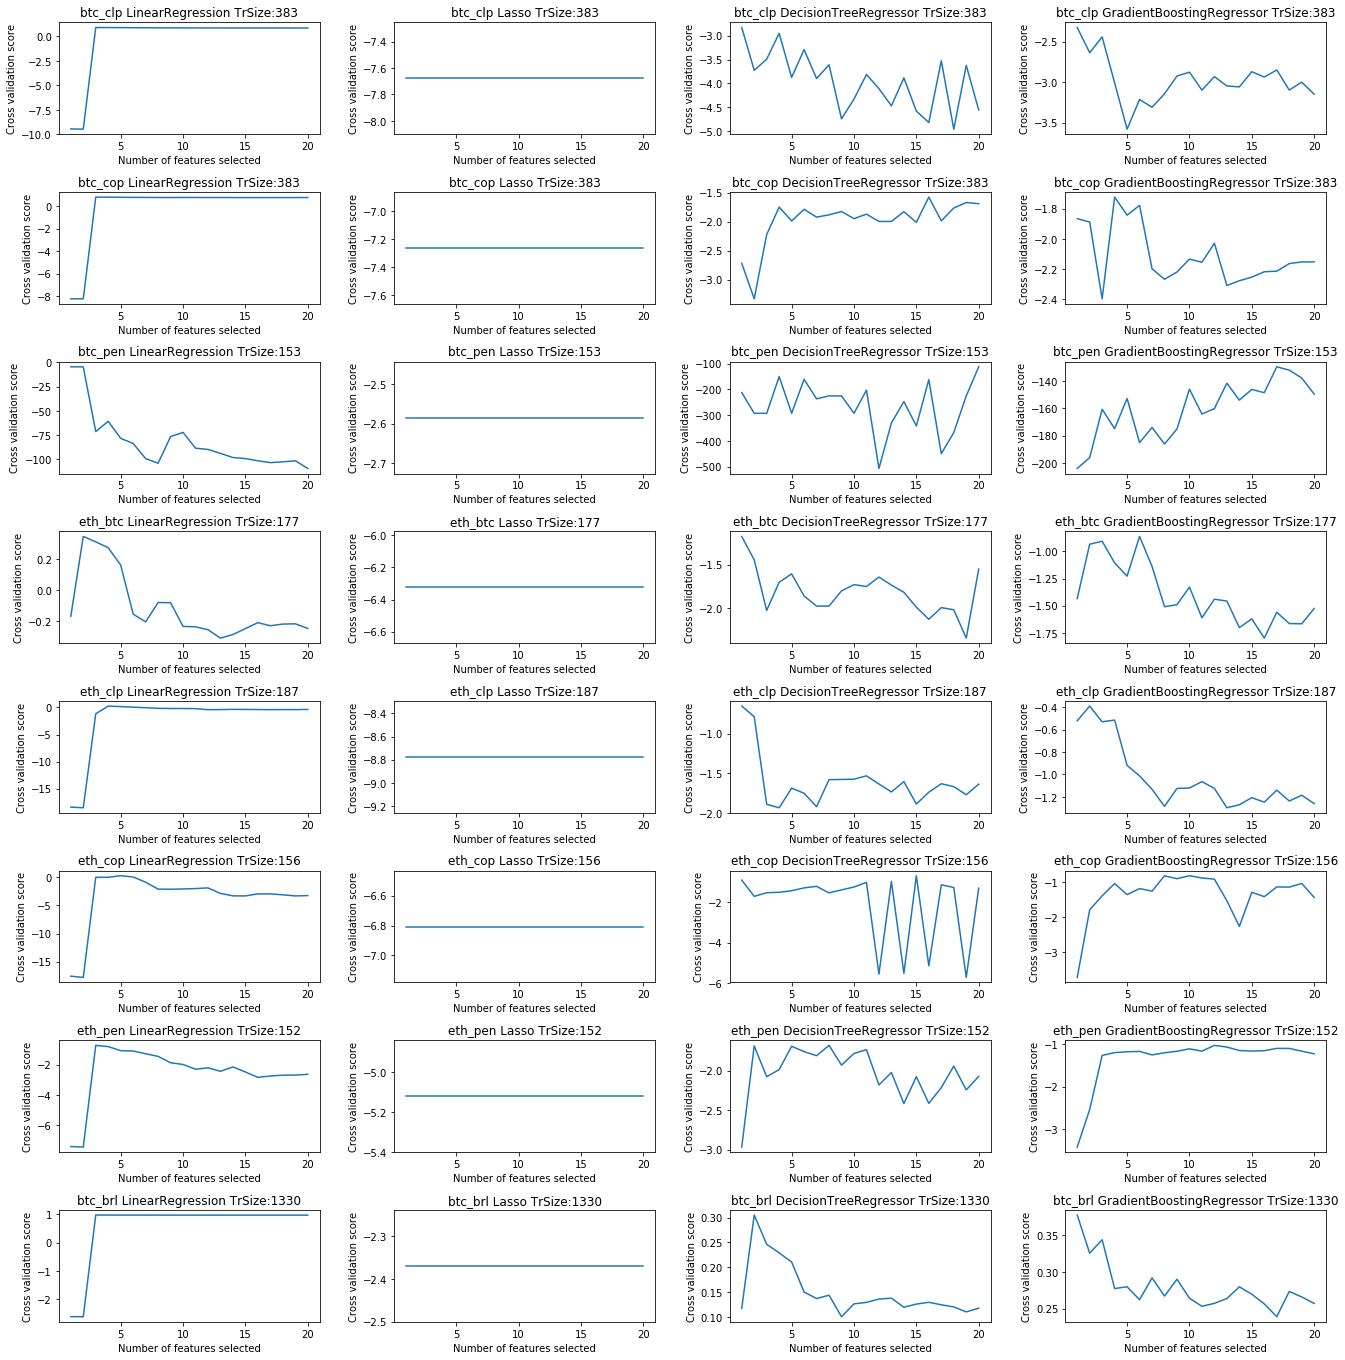

In [31]:
plotting_feature_selection(feature_selections_series,datasets_series_rescaled,regressors)

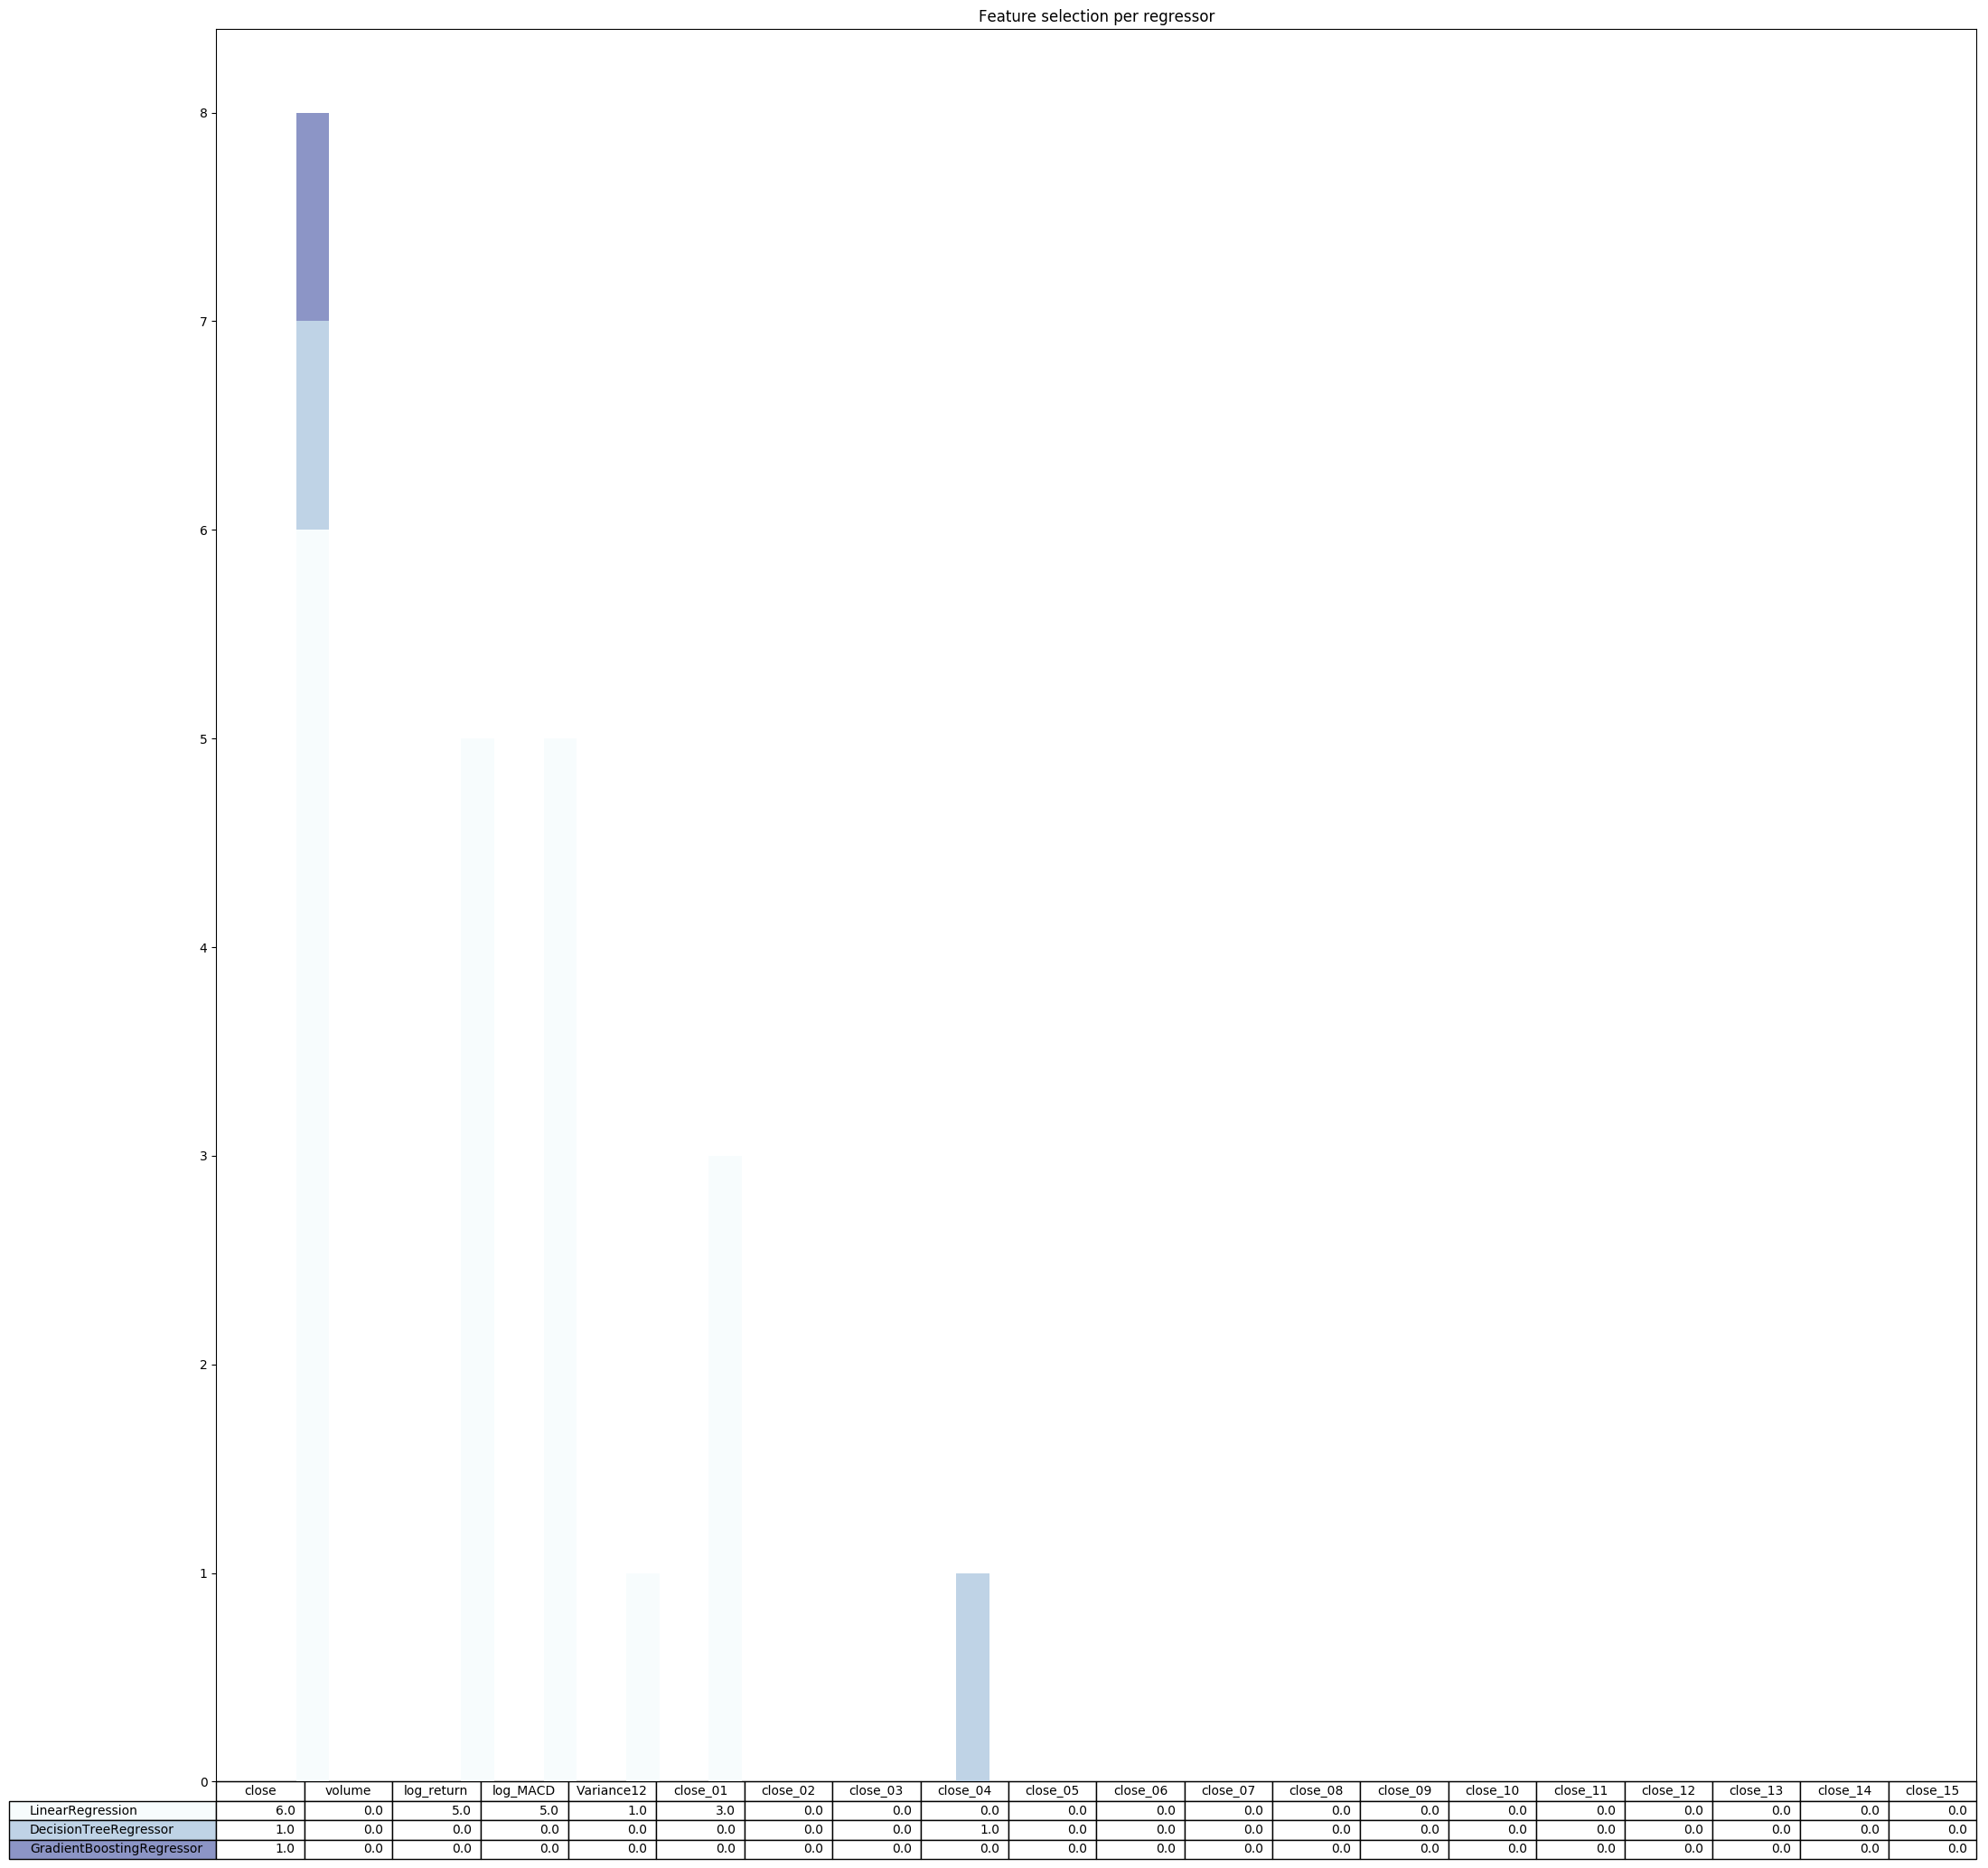

In [32]:
plot_feature_analysis(feature_selections_series,features_series)

In [33]:
score_rescaled_series_close=get_best_score_per_regressor_and_dataset(feature_selections_series,features_series).sort_values('Best Score',ascending=False)
score_rescaled_series_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl LinearRegression             0.971900                   3   
btc_clp LinearRegression             0.901139                   3   
btc_cop LinearRegression             0.792066                   3   
btc_brl GradientBoostingRegressor    0.377211                   1   
eth_btc LinearRegression             0.347140                   2   
btc_brl DecisionTreeRegressor        0.305043                   2   
eth_clp LinearRegression             0.249984                   4   
eth_cop LinearRegression             0.245766                   5   
eth_clp GradientBoostingRegressor   -0.389254                   2   
        DecisionTreeRegressor       -0.652880                   1   
eth_cop DecisionTreeRegressor       -0.678447                  15   
eth_pen LinearRegression            -0.728614                   3   
eth_cop GradientBoostingRegressor   -0.818015                  10   
eth_btc GradientBoostingRegressor   -0.862838                   6   
eth_pen GradientBoostingRegressor   -1.037217                  12   
eth_btc DecisionTreeRegressor       -1.178561                   1   
btc_cop DecisionTreeRegressor       -1.577422                  16   
eth_pen DecisionTreeRegressor       -1.679188                   8   
btc_cop GradientBoostingRegressor   -1.723501                   4   
btc_clp GradientBoostingRegressor   -2.325527                   1   
btc_brl Lasso                       -2.370008                  20   
btc_pen Lasso                       -2.584963                  20   
btc_clp DecisionTreeRegressor       -2.828154                   1   
btc_pen LinearRegression            -4.529059                   1   
eth_pen Lasso                       -5.119581                  20   
eth_btc Lasso                       -6.323799                  20   
eth_cop Lasso                       -6.806767                  20   
btc_cop Lasso                       -7.261121                  20   
btc_clp Lasso                       -7.678022                  20   
eth_clp Lasso                       -8.776150                  20   
btc_pen DecisionTreeRegressor     -112.659820                  20   
        GradientBoostingRegressor -129.577935                  17   

                                                                            features  
dataset regressor                                                                     
btc_brl LinearRegression                               [close, log_return, log_MACD]  
btc_clp LinearRegression                               [close, log_return, log_MACD]  
btc_cop LinearRegression                               [close, log_return, log_MACD]  
btc_brl GradientBoostingRegressor                                            [close]  
eth_btc LinearRegression                                           [close, close_01]  
btc_brl DecisionTreeRegressor                                      [close, close_04]  
eth_clp LinearRegression                     [close, log_return, log_MACD, close_01]  
eth_cop LinearRegression           [close, log_return, log_MACD, Variance12, clos...  
eth_clp GradientBoostingRegressor                                  [close, close_13]  
        DecisionTreeRegressor                                                [close]  
eth_cop DecisionTreeRegressor      [close, volume, Variance12, close_01, close_02...  
eth_pen LinearRegression                               [close, log_return, log_MACD]  
eth_cop GradientBoostingRegressor  [close, volume, Variance12, close_01, close_02...  
eth_btc GradientBoostingRegressor  [close, log_return, log_MACD, Variance12, clos...  
eth_pen GradientBoostingRegressor  [close, volume, log_return, log_MACD, Variance...  
eth_btc DecisionTreeRegressor                                                [close]  
btc_cop DecisionTreeRegressor      [close, volume, Variance12, close_01, close_02...  
eth_pen DecisionTreeRegressor      

## Analysis Dataset Clean Return

In [34]:
feature_selections=feature_selection_analysis(datasets,regressors,features,target_returns)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop


/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/JR/anaconda3/envs/pyfinance/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.

DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl
DecisionTreeRegressor
btc_brl
GradientBoostingRegressor
btc_brl


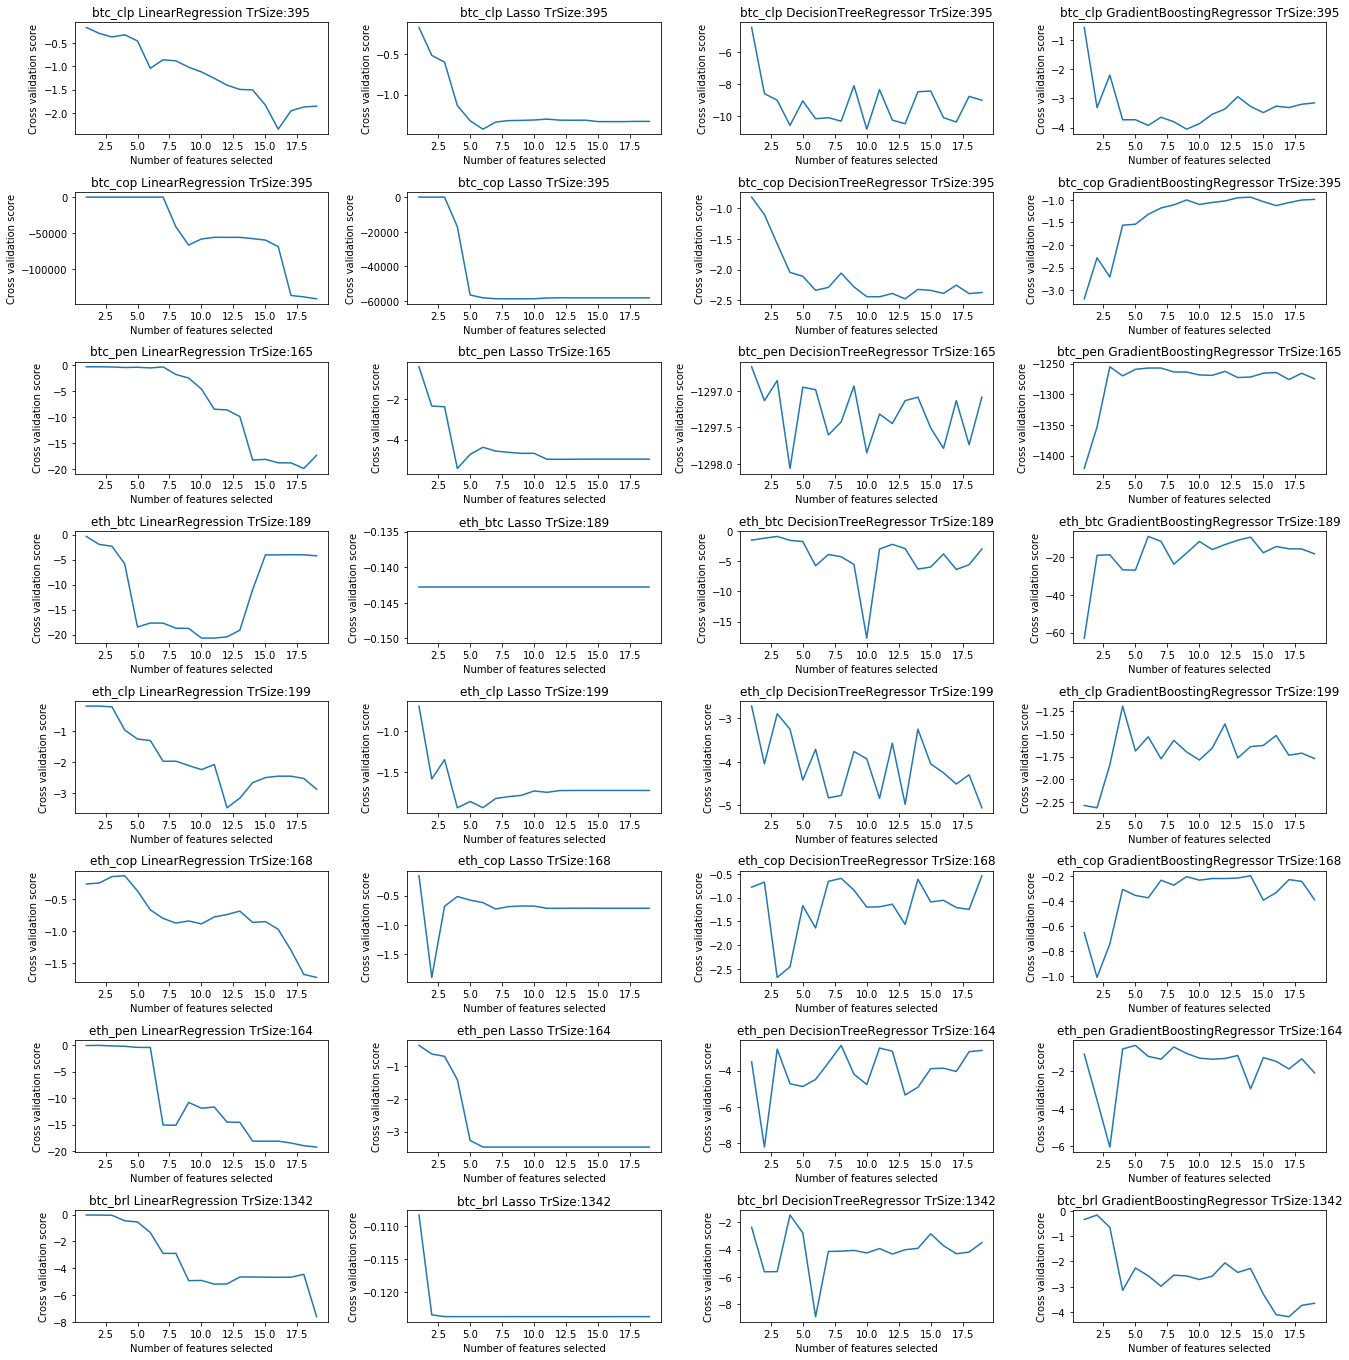

In [35]:
plotting_feature_selection(feature_selections,datasets,regressors )

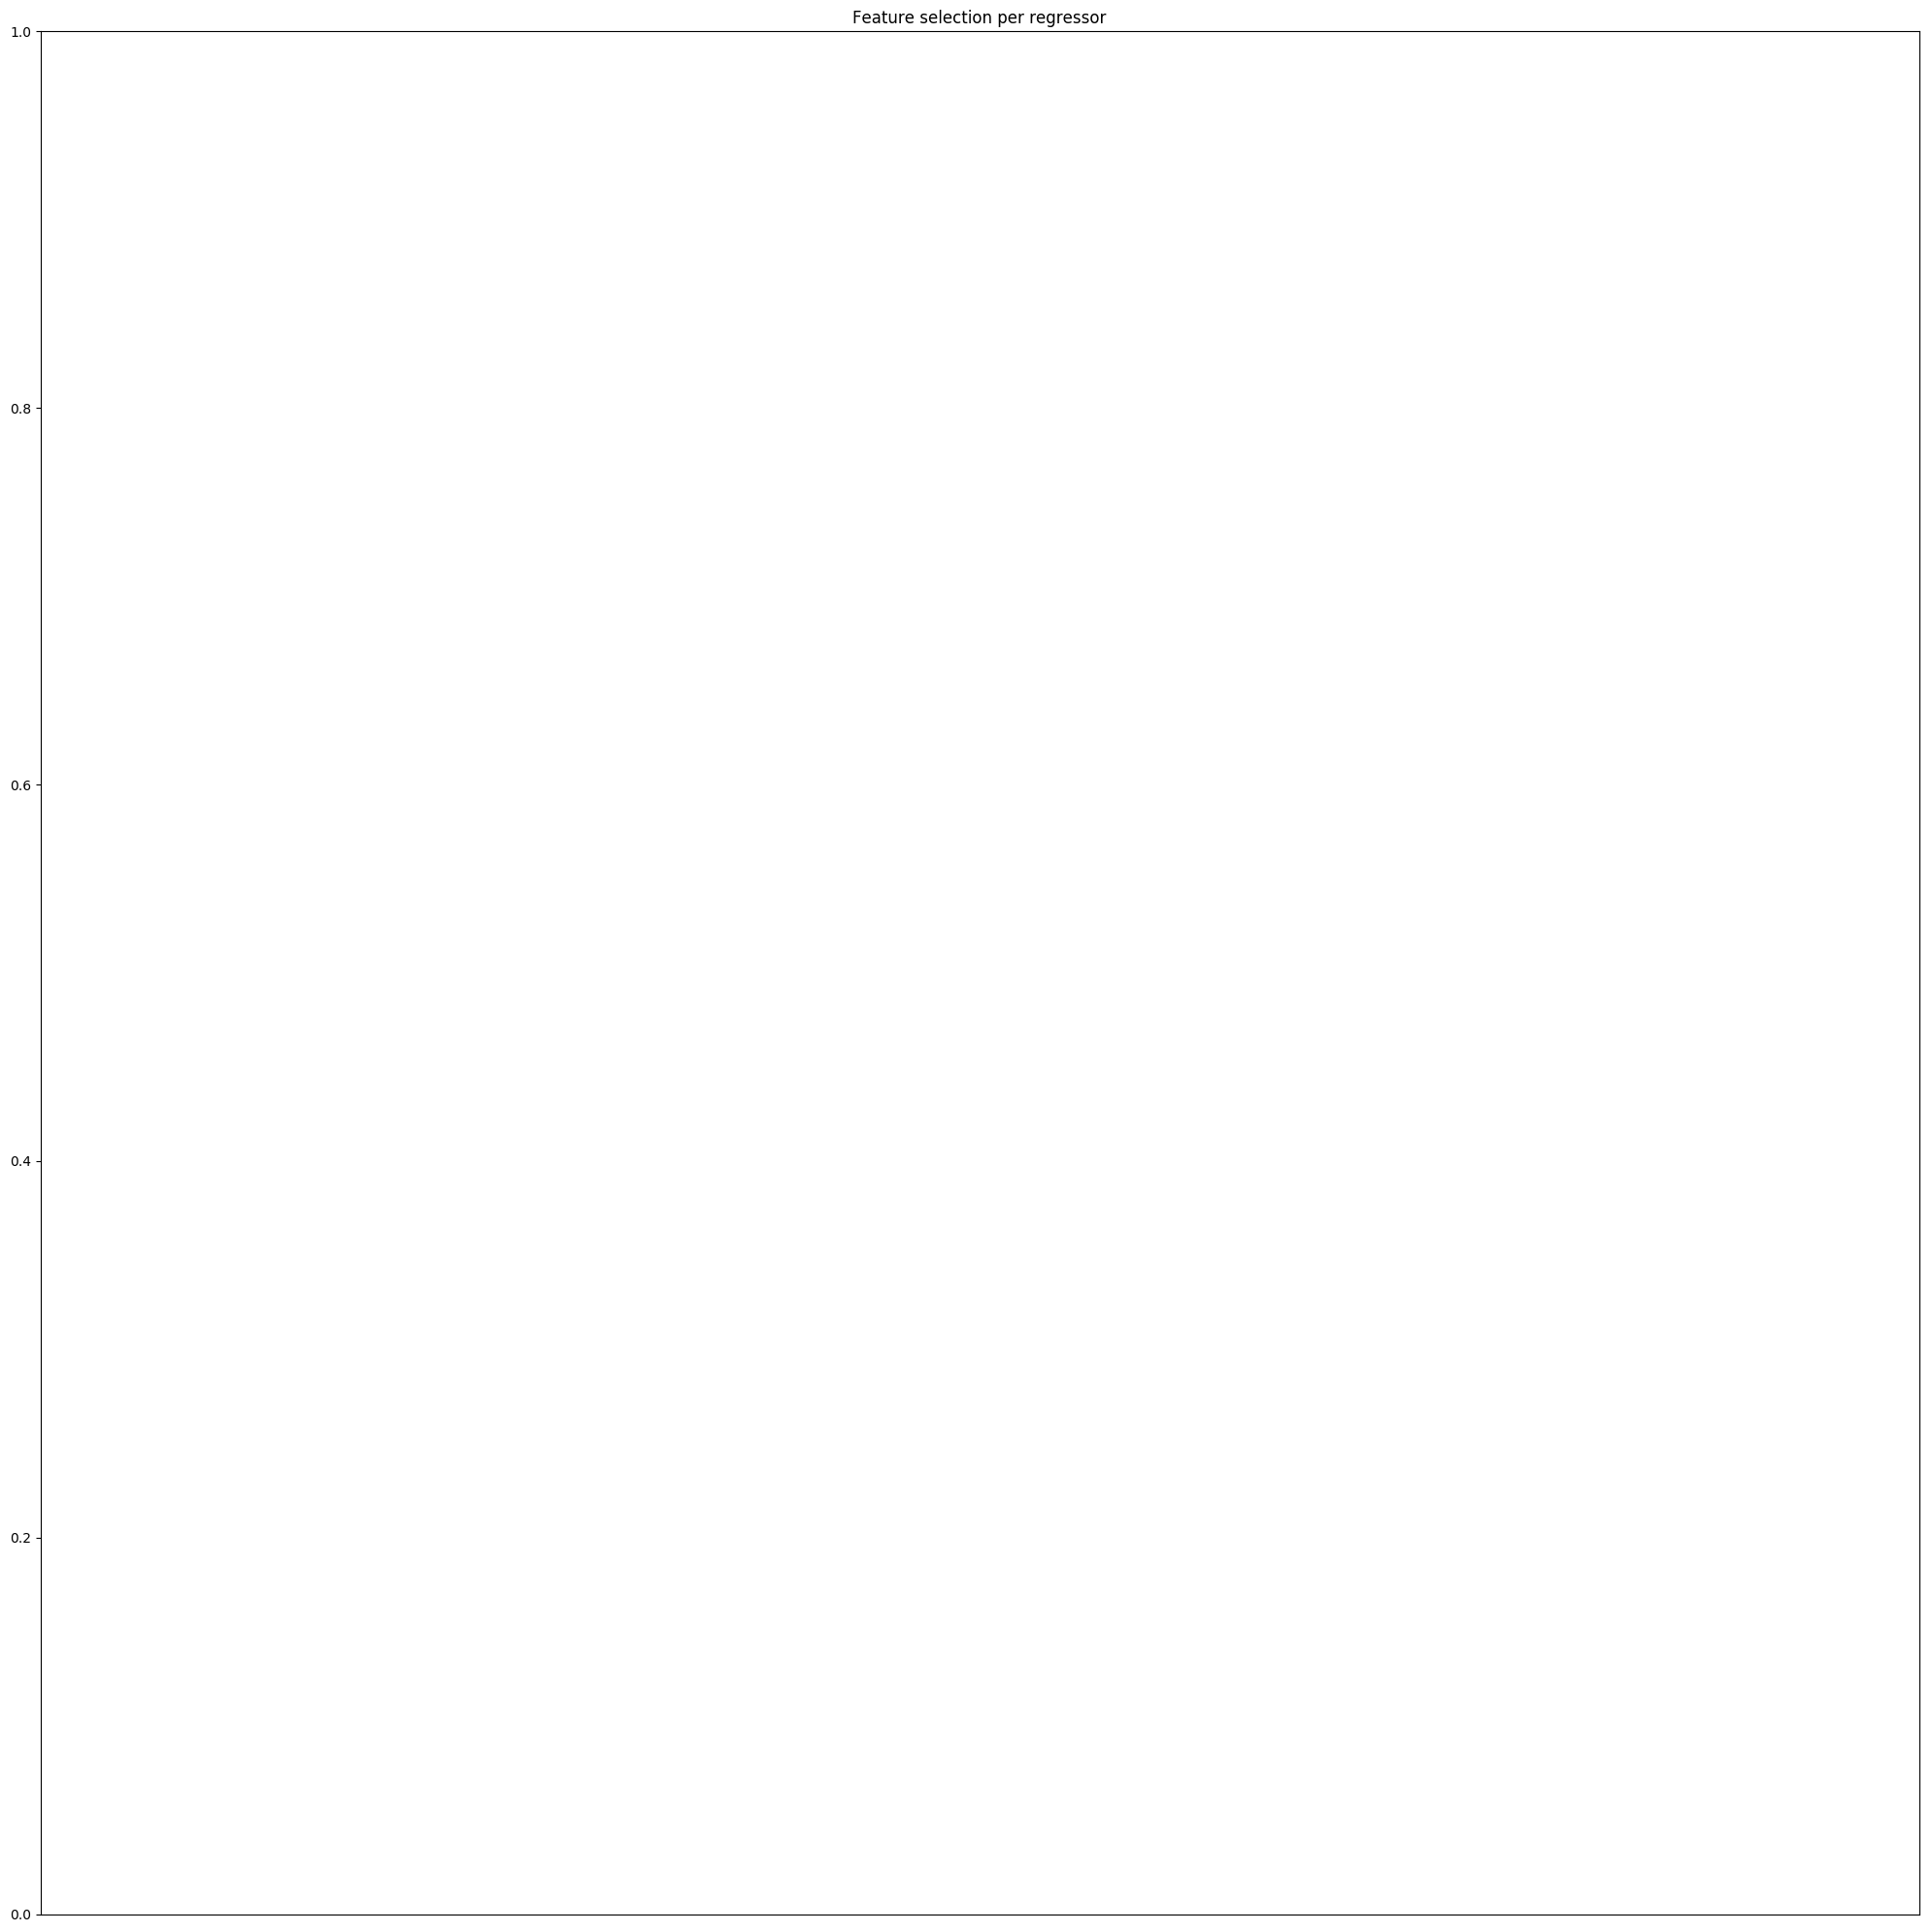

In [36]:
plot_feature_analysis(feature_selections,features)

In [37]:
score_clean_return=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)


## Analysis Dataset Clean Series Return

In [38]:
def building_series_to_each_input_return(dataset,N=15):
    return building_series_to_each_input(dataset,column_series=['Returns'])

datasets_series_return=copy_all_datasets(datasets)
all_datasets(building_series_to_each_input_return,datasets_series_return) 

features_series=['close','volume','log_return','log_MACD','Variance12',
                 'Returns_01','Returns_02','Returns_03',
                 'Returns_04','Returns_05','Returns_06',
                 'Returns_07','Returns_08','Returns_09',
                 'Returns_10','Returns_11','Returns_12',
                 'Returns_13','Returns_14','Returns_15']

feature_selections=feature_selection_analysis(datasets_series_return,regressors,features_series,target_returns)

building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
building_series_to_each_input_return
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
btc_pen
Lasso
btc_pen
DecisionTreeRegressor
btc_pen
GradientBoostingRegressor
btc_pen
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegresso

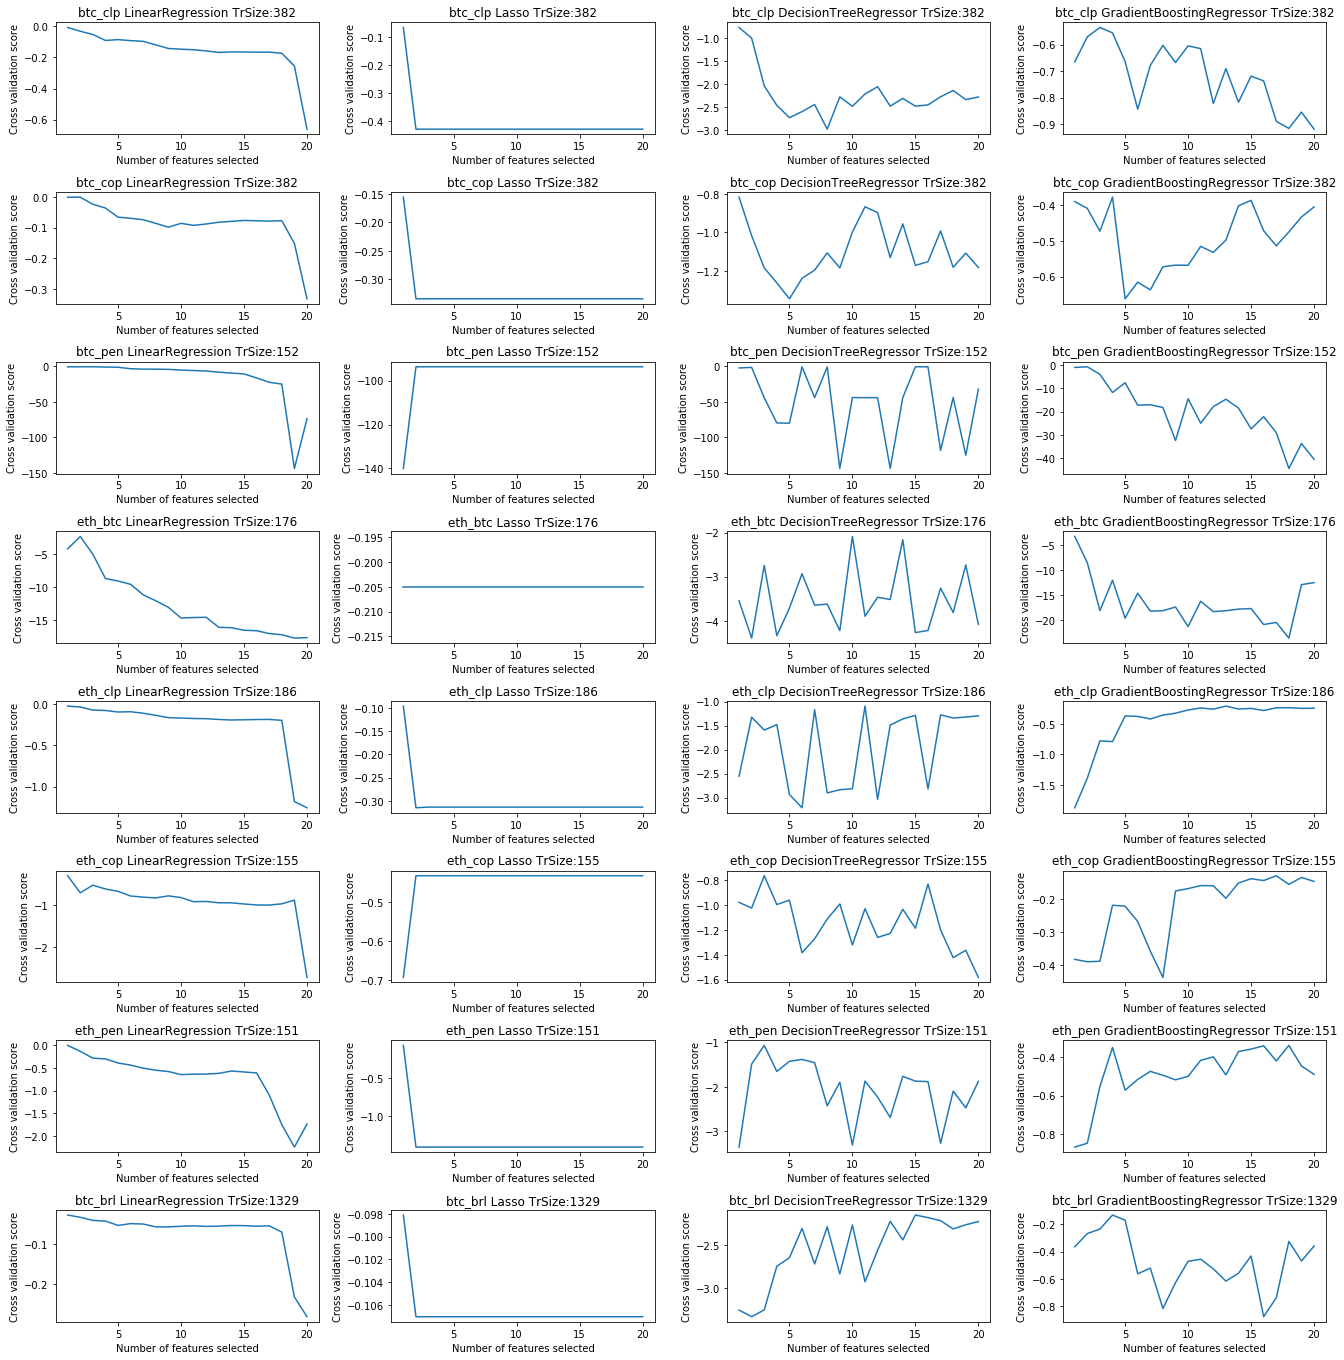

In [39]:
plotting_feature_selection(feature_selections,datasets_series_return,regressors )

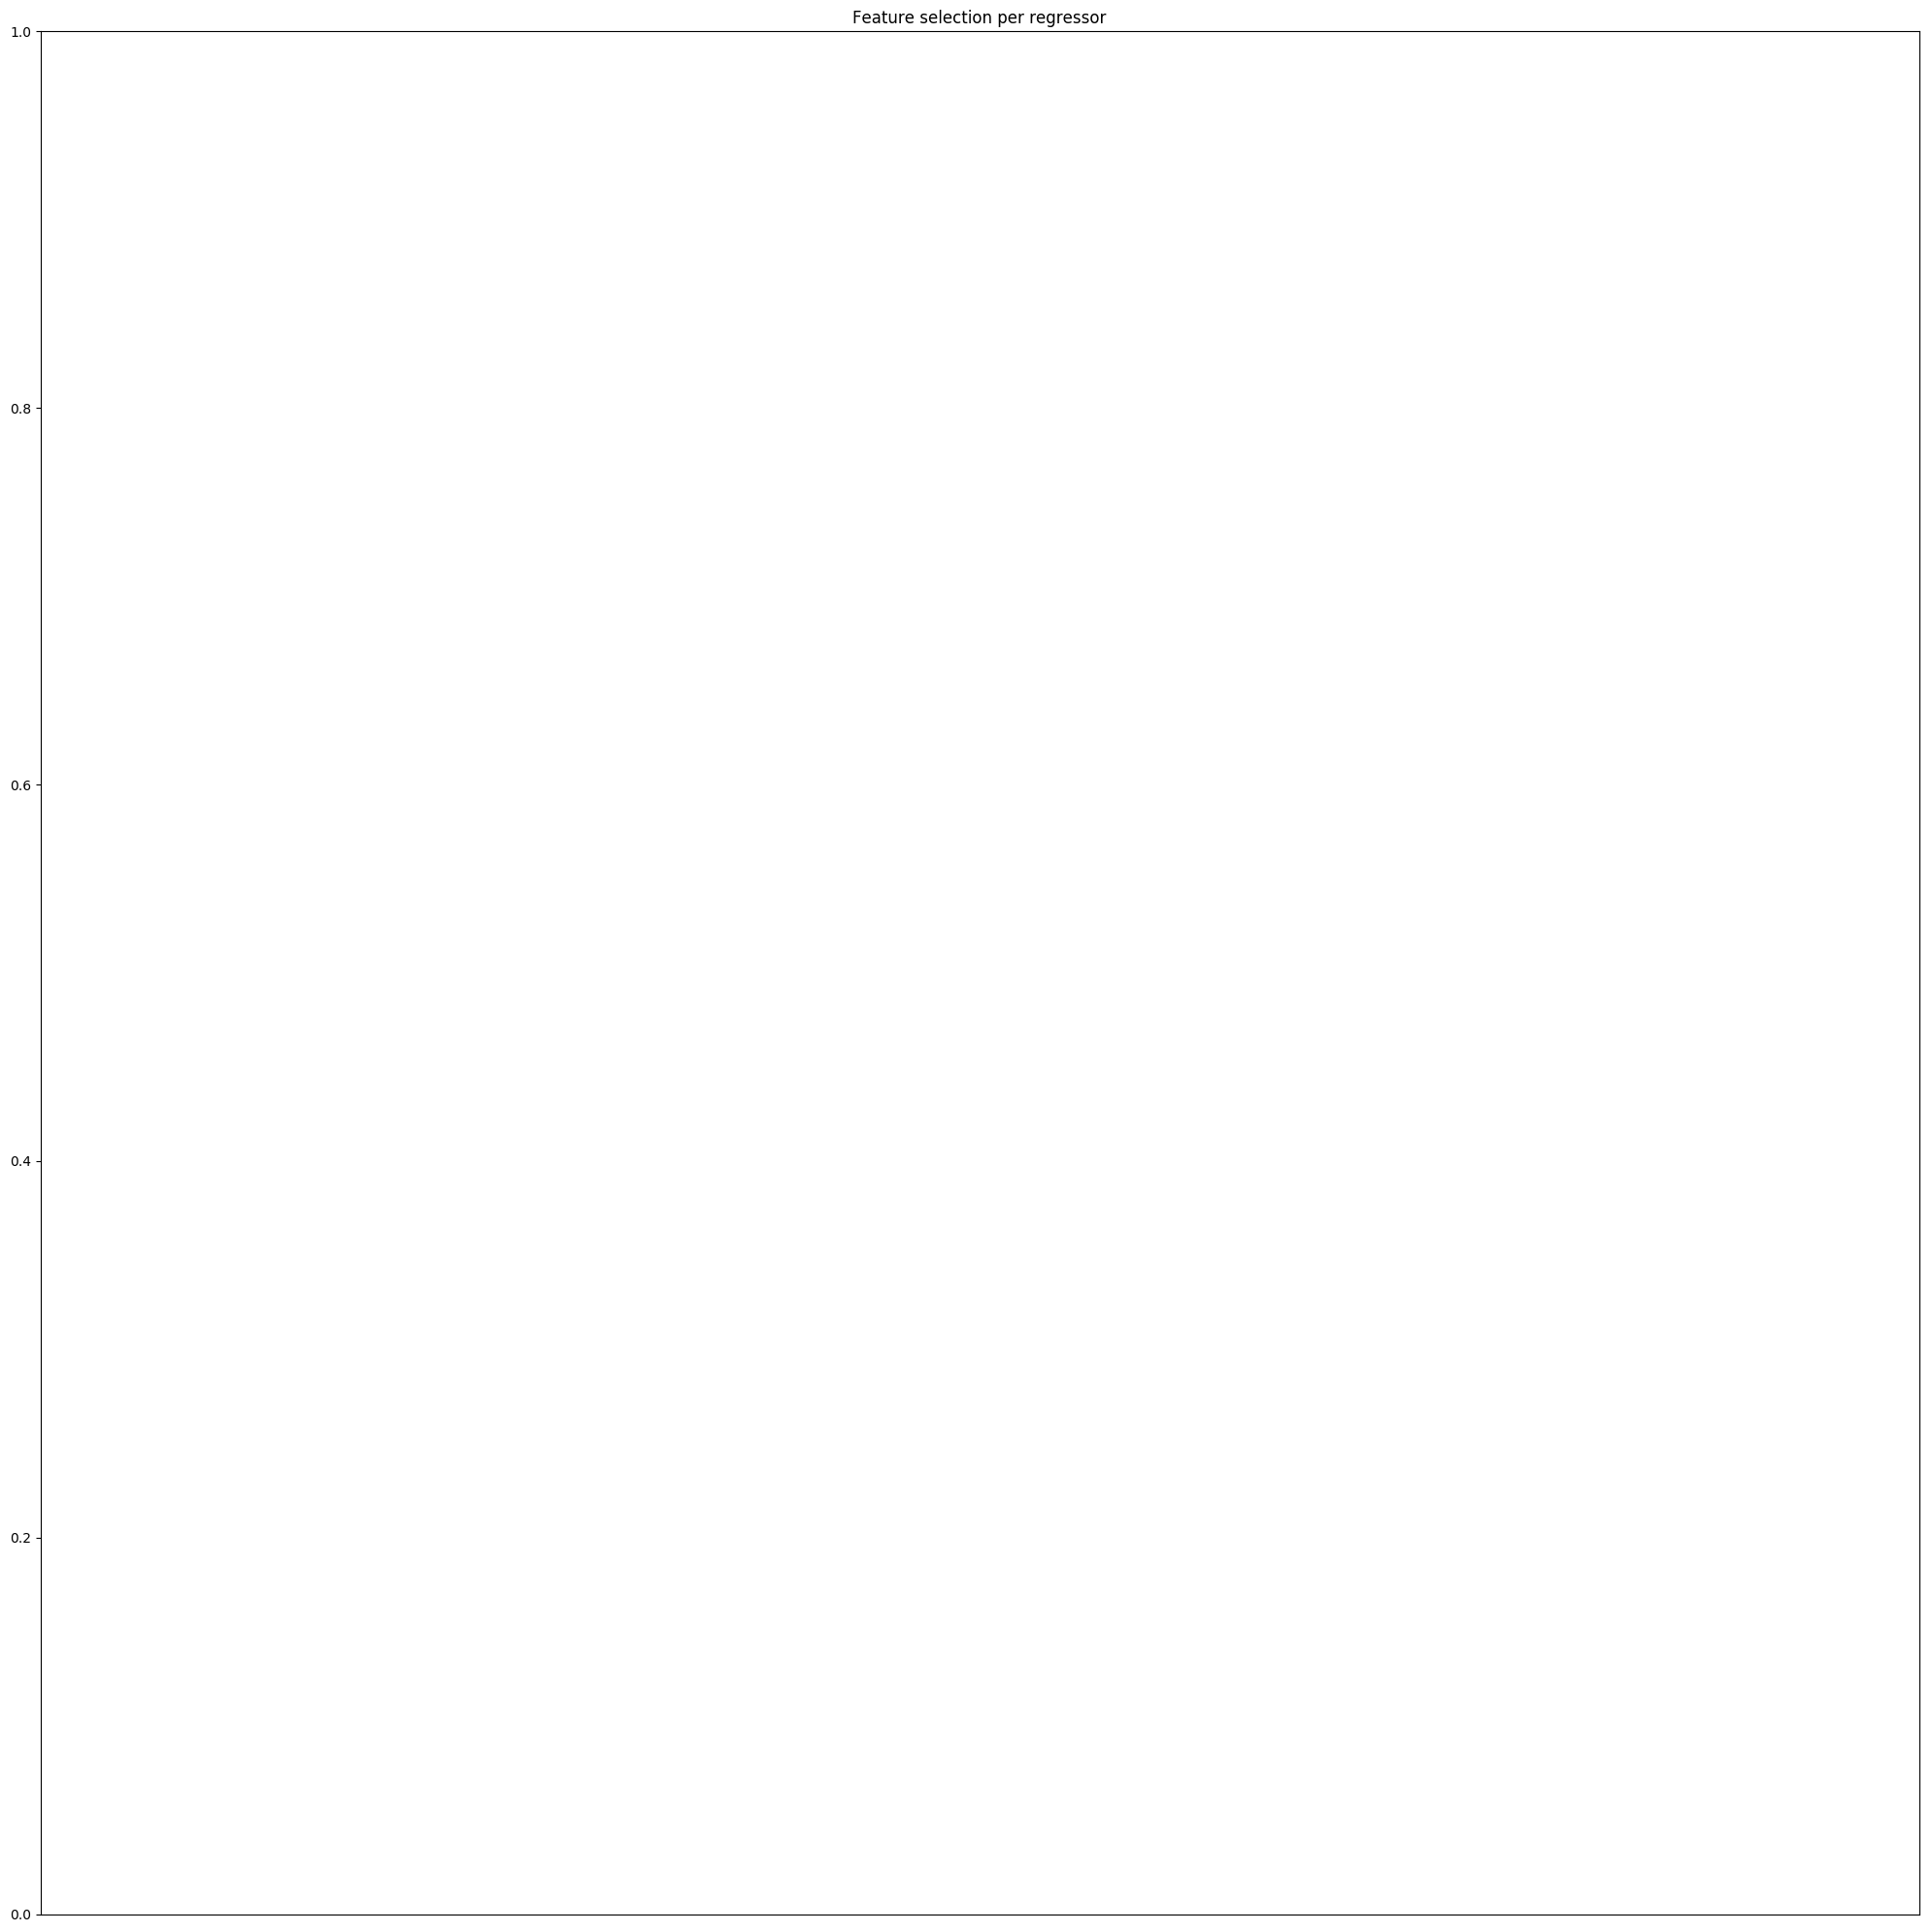

In [40]:
plot_feature_analysis(feature_selections,features_series)

In [41]:
score_clean_series_return=get_best_score_per_regressor_and_dataset(feature_selections,features_series).sort_values('Best Score',ascending=False)
score_clean_series_return


Best Score  Number of features  \
dataset regressor                                                   
btc_cop LinearRegression            -0.000535                   2   
eth_pen LinearRegression            -0.007570                   1   
btc_clp LinearRegression            -0.008025                   1   
eth_clp LinearRegression            -0.022797                   1   
btc_brl LinearRegression            -0.026675                   1   
btc_clp Lasso                       -0.065638                   1   
eth_pen Lasso                       -0.074183                   1   
eth_clp Lasso                       -0.095737                   1   
btc_brl Lasso                       -0.098100                   1   
eth_cop GradientBoostingRegressor   -0.127511                  17   
btc_brl GradientBoostingRegressor   -0.133273                   4   
btc_cop Lasso                       -0.155502                   1   
eth_btc Lasso                       -0.205080                  20   
eth_clp GradientBoostingRegressor   -0.210610                  13   
eth_cop LinearRegression            -0.298204                   1   
eth_pen GradientBoostingRegressor   -0.337958                  18   
btc_cop GradientBoostingRegressor   -0.377661                   4   
eth_cop Lasso                       -0.432328                  20   
btc_pen DecisionTreeRegressor       -0.507876                  16   
btc_clp GradientBoostingRegressor   -0.535007                   3   
btc_pen LinearRegression            -0.629878                   3   
        GradientBoostingRegressor   -0.710127                   2   
eth_cop DecisionTreeRegressor       -0.762819                   3   
btc_clp DecisionTreeRegressor       -0.768969                   1   
btc_cop DecisionTreeRegressor       -0.816813                   1   
eth_pen DecisionTreeRegressor       -1.068866                   3   
eth_clp DecisionTreeRegressor       -1.092803                  11   
eth_btc DecisionTreeRegressor       -2.086708                  10   
btc_brl DecisionTreeRegressor       -2.150716                  15   
eth_btc LinearRegression            -2.357689                   2   
        GradientBoostingRegressor   -3.194529                   1   
btc_pen Lasso                      -93.687655                  20   

                                                                            features  
dataset regressor                                                                     
btc_cop LinearRegression                                    [log_return, Returns_01]  
eth_pen LinearRegression                                                [log_return]  
btc_clp LinearRegression                                                [log_return]  
eth_clp LinearRegression                                                [log_return]  
btc_brl LinearRegression                                                [Returns_09]  
btc_clp Lasso                                                           [Variance12]  
eth_pen Lasso                                                           [Variance12]  
eth_clp Lasso                                                               [volume]  
btc_brl Lasso                                                                [close]  
eth_cop GradientBoostingRegressor  [close, volume, log_return, log_MACD, Variance...  
btc_brl GradientBoostingRegressor     [log_return, log_MACD, Returns_01, Returns_08]  
btc_cop Lasso                                                           [Variance12]  
eth_btc Lasso                      [close, volume, log_return, log_MACD, Variance...  
eth_clp GradientBoostingRegressor  [close, volume, log_return, log_MACD, Returns_...  
eth_cop LinearRegression                                                [log_return]  
eth_pen GradientBoostingRegressor  [volume, log_return, log_MACD, Variance12, Ret...  
btc_cop GradientBoostingRegressor       [volume, log_return, Returns_01, Returns_15]  
eth_cop Lasso                      

## Analysis Log Clean Close

In [42]:
log_datasets.pop('btc_pen',"default")

features_log=['open','close','high','volume','EWMA26','EWMA12','EWMA9',
          'Returns','log_return','Variance12','log_MACD']

feature_selections_log=feature_selection_analysis(log_datasets,regressors,features_log,target_close)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop
DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl
DecisionTreeRegressor
btc_brl
GradientBoostingReg

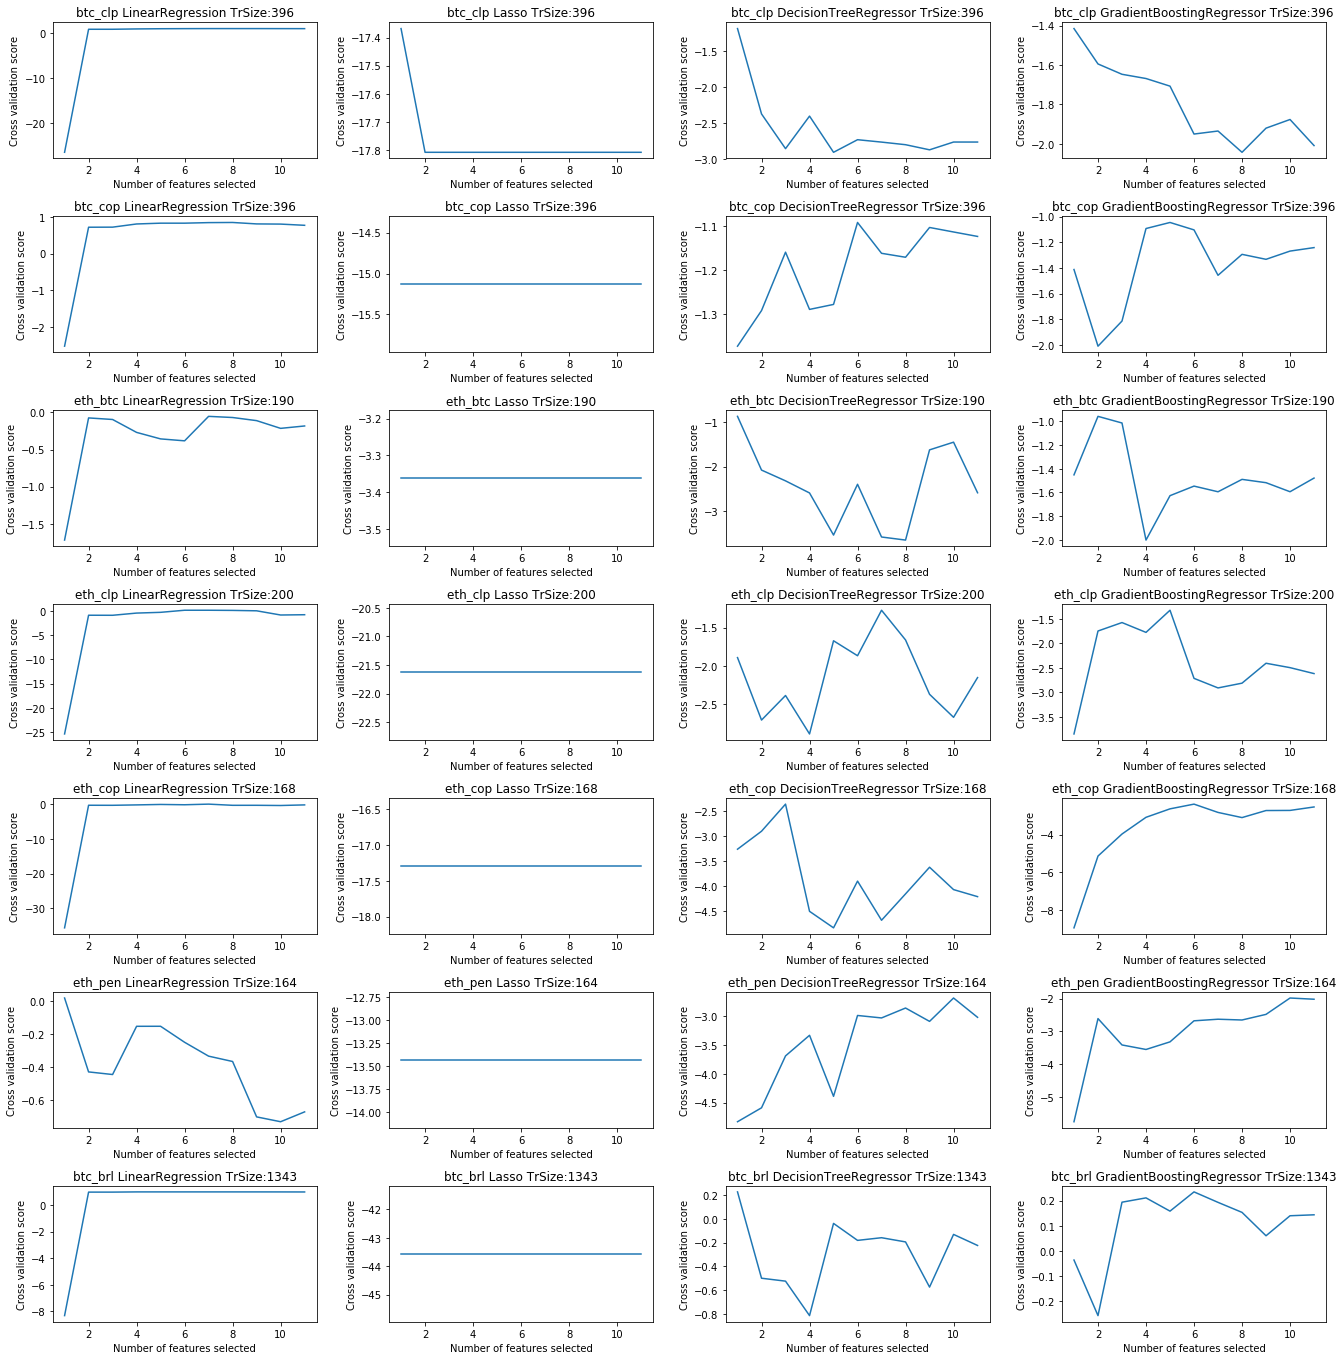

In [43]:
plotting_feature_selection(feature_selections_log,log_datasets,regressors)

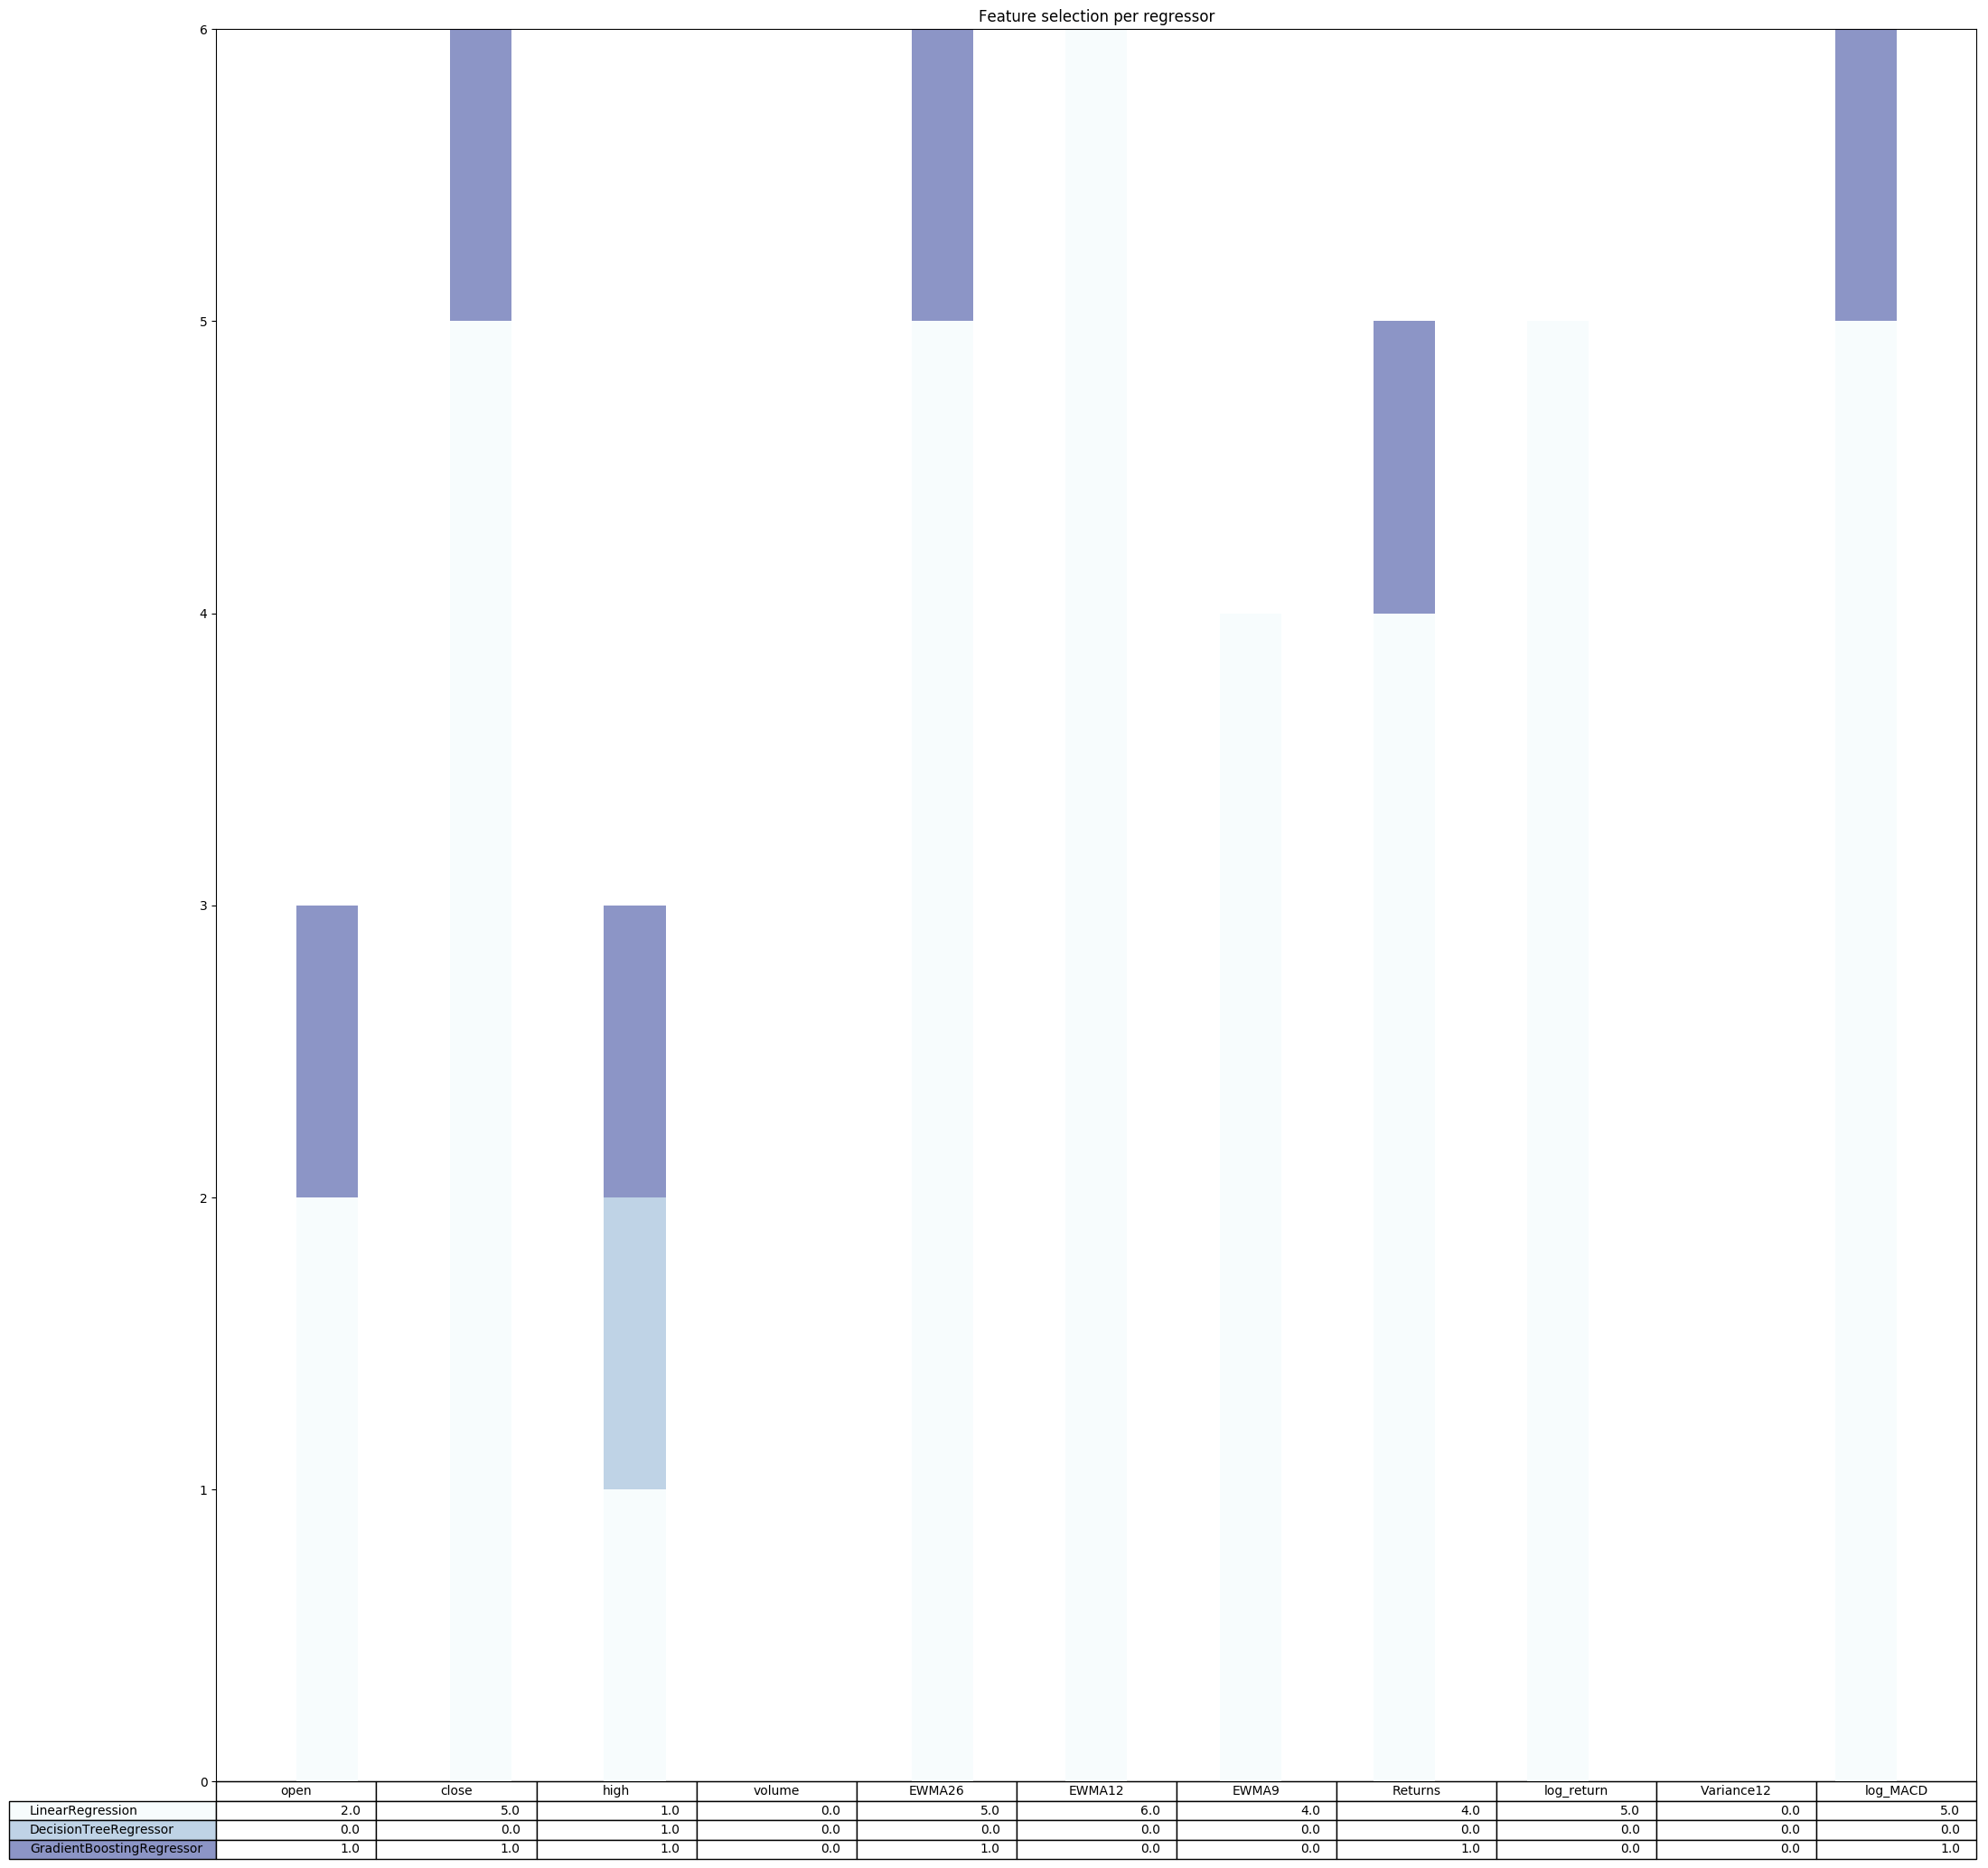

In [44]:
plot_feature_analysis(feature_selections_log,features_log)

In [45]:
score_log_close=get_best_score_per_regressor_and_dataset(feature_selections_log,features_log).sort_values('Best Score',ascending=False)
score_log_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl LinearRegression             0.972336                   7   
btc_clp LinearRegression             0.921867                   7   
btc_cop LinearRegression             0.845963                   8   
btc_brl GradientBoostingRegressor    0.234731                   6   
        DecisionTreeRegressor        0.226479                   1   
eth_clp LinearRegression             0.099497                   7   
eth_cop LinearRegression             0.027474                   7   
eth_pen LinearRegression             0.020675                   1   
eth_btc LinearRegression            -0.053802                   7   
        DecisionTreeRegressor       -0.864780                   1   
        GradientBoostingRegressor   -0.957959                   2   
btc_cop GradientBoostingRegressor   -1.045684                   5   
        DecisionTreeRegressor       -1.091255                   6   
btc_clp DecisionTreeRegressor       -1.180885                   1   
eth_clp DecisionTreeRegressor       -1.272159                   7   
        GradientBoostingRegressor   -1.322291                   5   
btc_clp GradientBoostingRegressor   -1.415624                   1   
eth_pen GradientBoostingRegressor   -1.984766                  10   
eth_cop DecisionTreeRegressor       -2.359044                   3   
        GradientBoostingRegressor   -2.373737                   6   
eth_pen DecisionTreeRegressor       -2.682480                  10   
eth_btc Lasso                       -3.361952                  11   
eth_pen Lasso                      -13.430354                  11   
btc_cop Lasso                      -15.132445                  11   
eth_cop Lasso                      -17.292382                  11   
btc_clp Lasso                      -17.368071                   1   
eth_clp Lasso                      -21.624835                  11   
btc_brl Lasso                      -43.563107                  11   

                                                                            features  
dataset regressor                                                                     
btc_brl LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
btc_clp LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
btc_cop LinearRegression           [open, close, EWMA26, EWMA12, EWMA9, Returns, ...  
btc_brl GradientBoostingRegressor     [open, close, high, EWMA26, Returns, log_MACD]  
        DecisionTreeRegressor                                                 [high]  
eth_clp LinearRegression           [open, close, high, EWMA26, EWMA12, log_return...  
eth_cop LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
eth_pen LinearRegression                                                    [EWMA12]  
eth_btc LinearRegression           [open, close, high, EWMA12, Returns, log_retur...  
        DecisionTreeRegressor                                                 [open]  
        GradientBoostingRegressor                                 [open, log_return]  
btc_cop GradientBoostingRegressor         [open, close, EWMA9, log_return, log_MACD]  
        DecisionTreeRegressor      [close, high, EWMA26, EWMA9, Variance12, log_M...  
btc_clp DecisionTreeRegressor                                               [EWMA26]  
eth_clp DecisionTreeRegressor      [open, close, high, volume, EWMA26, EWMA12, lo...  
        GradientBoostingRegressor            [open, close, EWMA26, EWMA12, log_MACD]  
btc_clp GradientBoostingRegressor                                            [close]  
eth_pen GradientBoostingRegressor  [open, close, volume, EWMA26, EWMA12, EWMA9, R...  
eth_cop DecisionTreeRegressor                                  [close, high, EWMA26]  
        GradientBoostingRegressor  [open, high, EWMA26, EWMA12, Variance12, log_M...  
eth_pen DecisionTreeRegressor      [close, high, v

## Analysis Log Series Close

In [46]:
log_datasets_series=copy_all_datasets(log_datasets)
all_datasets(building_series_to_each_input,log_datasets_series) 

features_series=['open','close','high','volume','EWMA26','EWMA12','EWMA9',
          'Returns','log_return','Variance12','log_MACD',
          'close_01','close_02','close_03','close_04','close_05','close_06',
         'close_07','close_08','close_09','close_10','close_11','close_12',
         'close_13','close_14','close_15']

feature_selections_series=feature_selection_analysis(log_datasets_series,regressors,features_series,target_close)

building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
building_series_to_each_input
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop
DecisionTreeRegressor
eth_cop
GradientBoostin

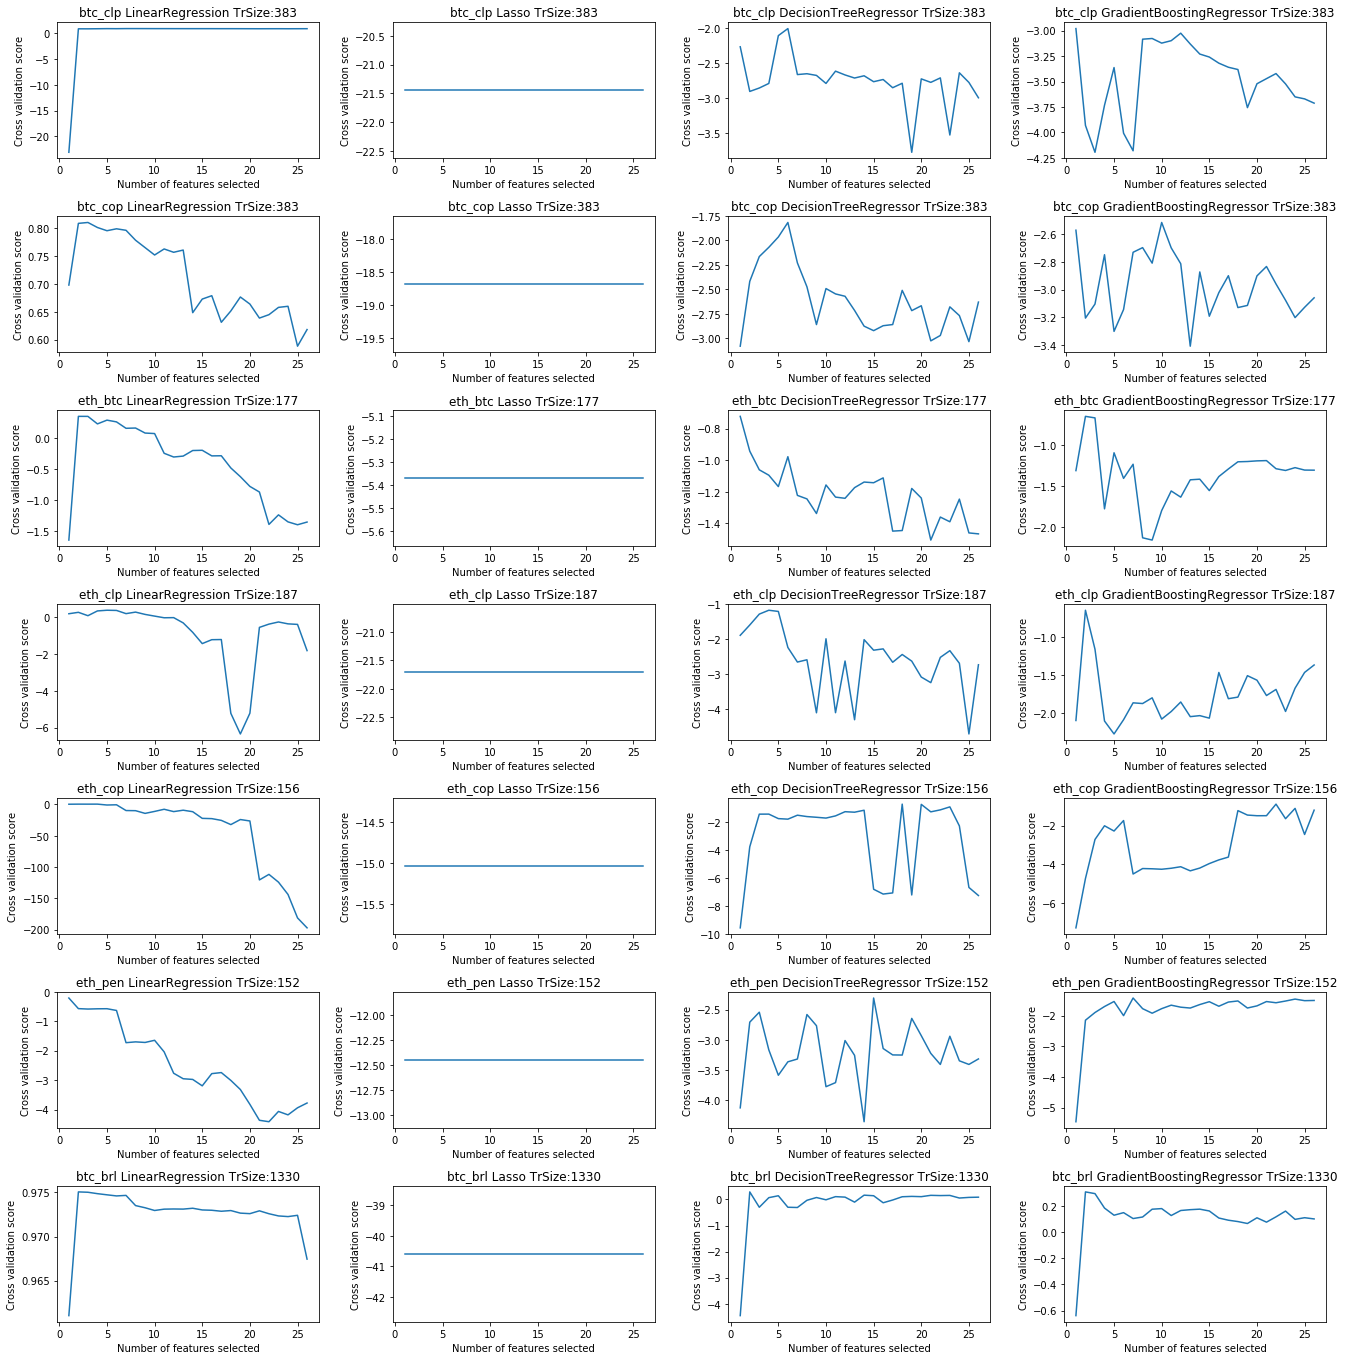

In [47]:
plotting_feature_selection(feature_selections_series,log_datasets_series,regressors)

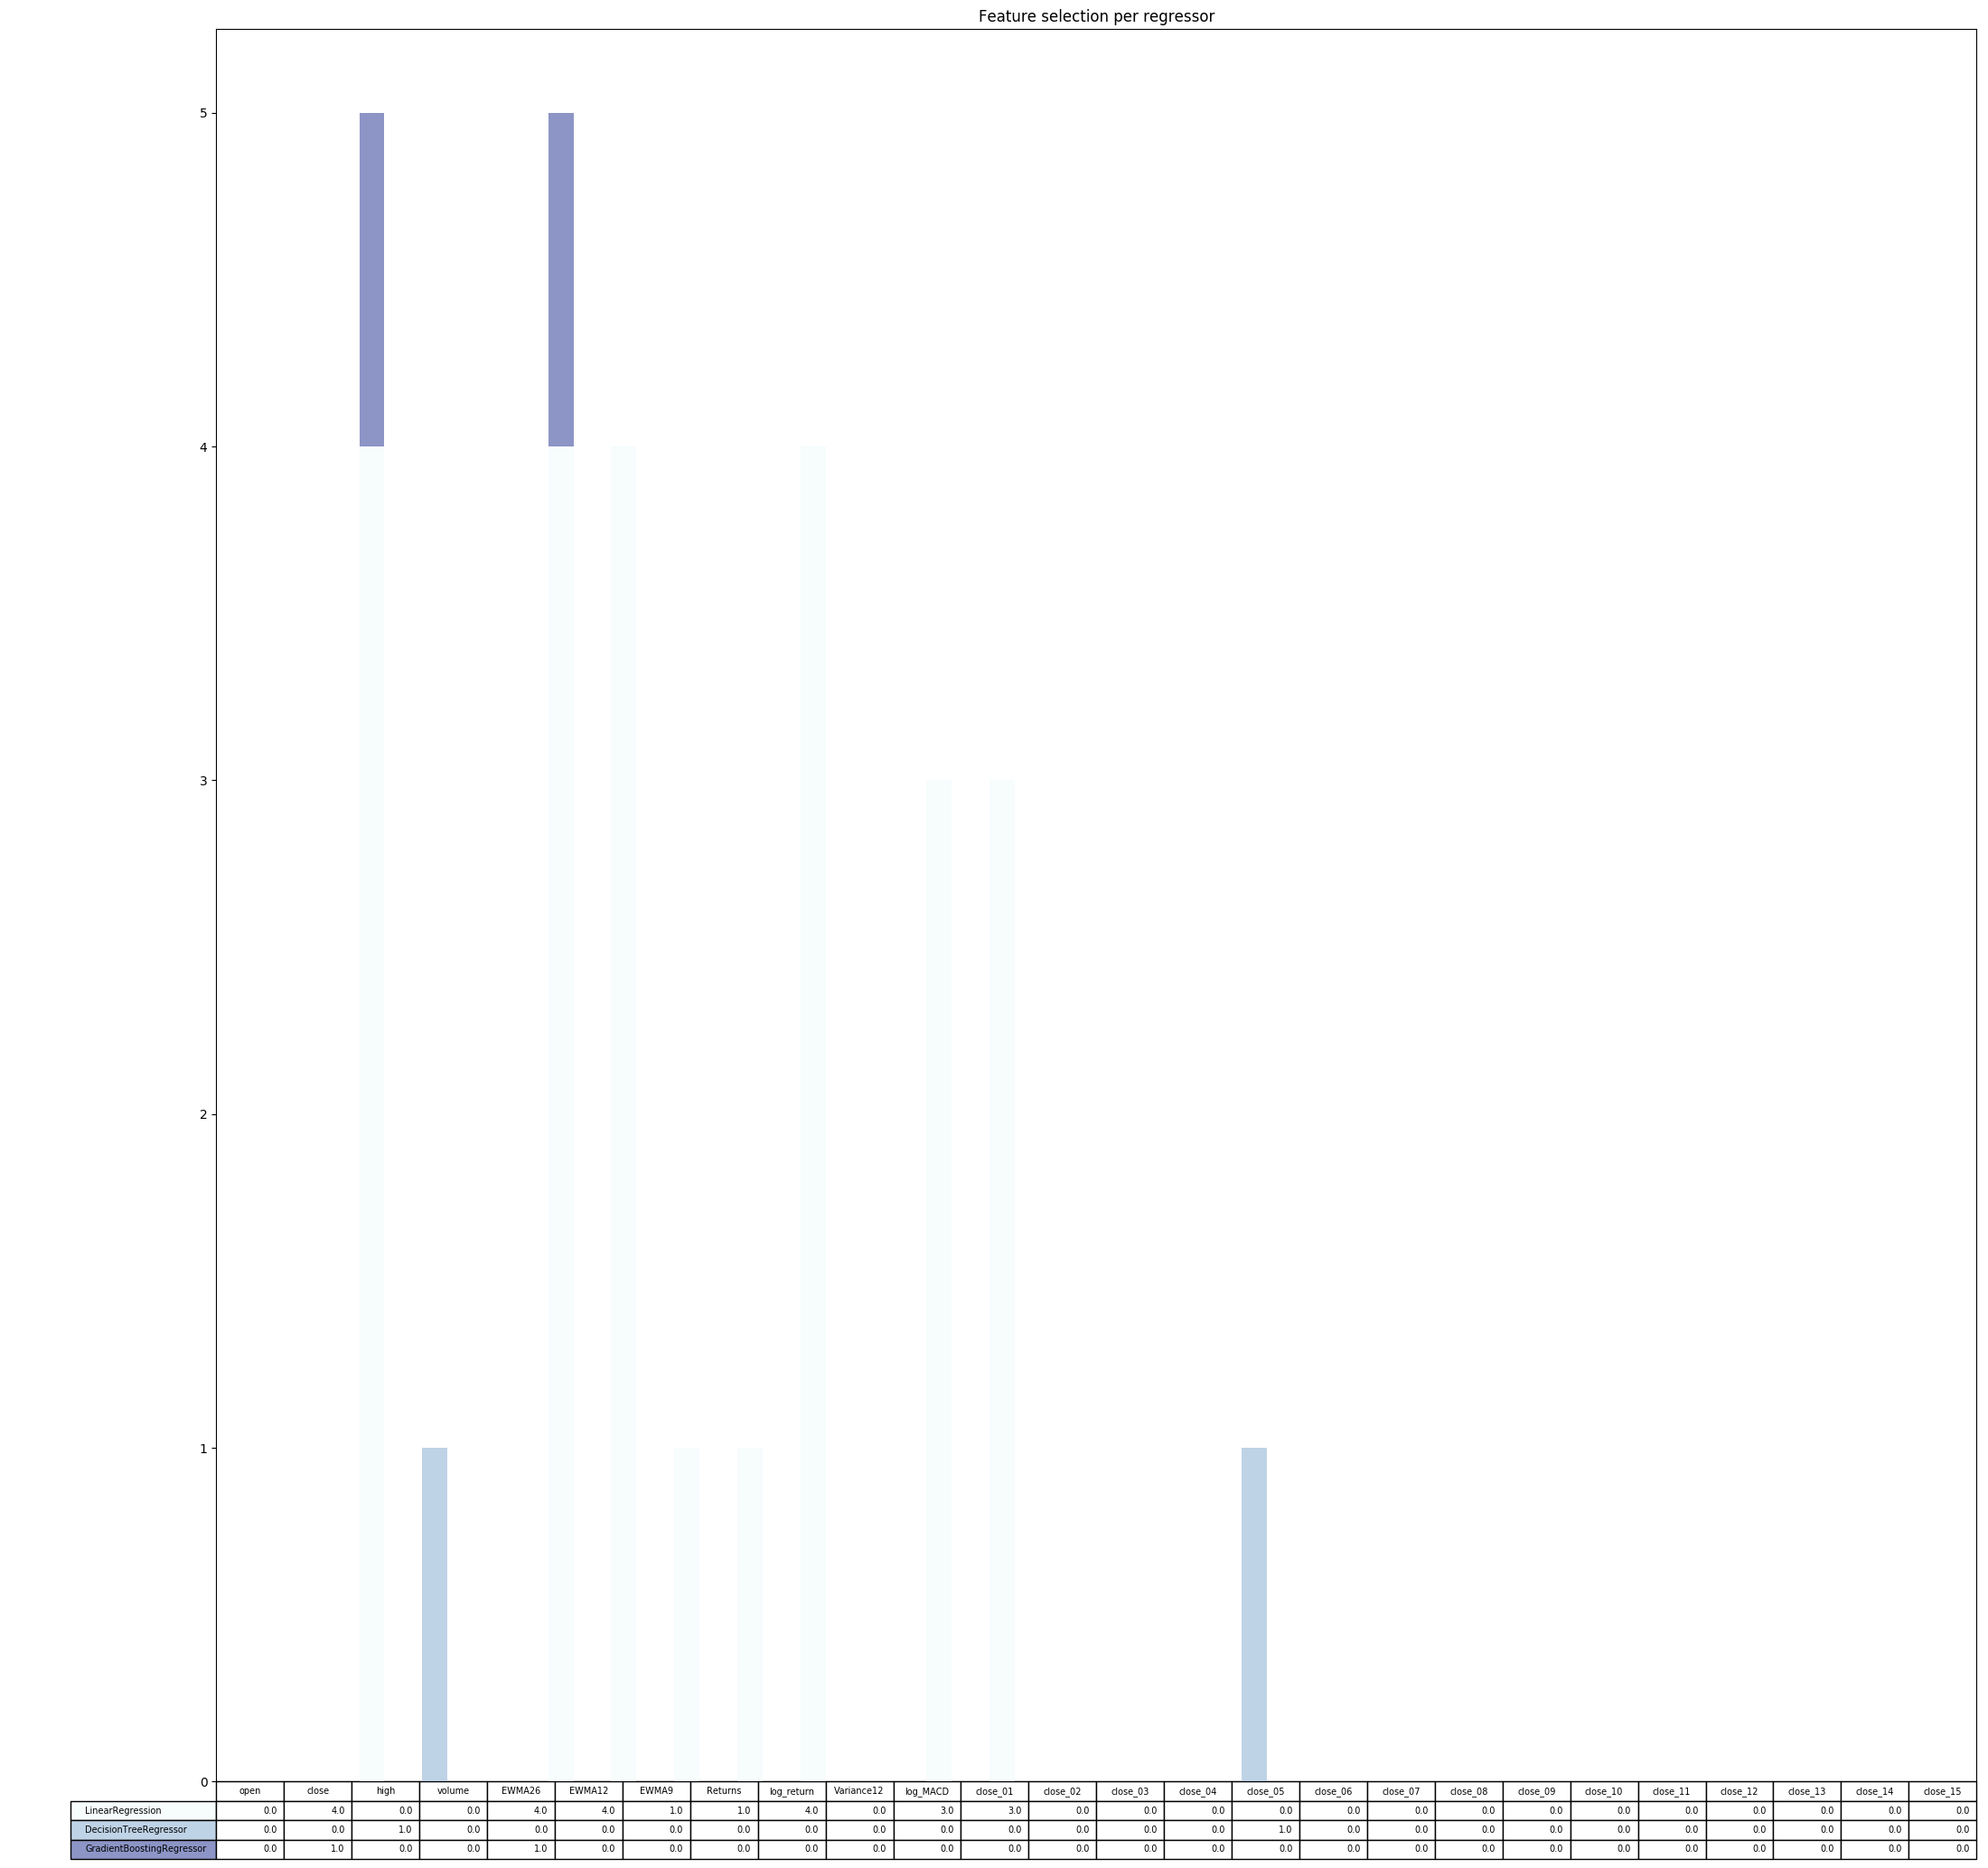

In [48]:
plot_feature_analysis(feature_selections_series,features_series)

In [49]:
score_log_series_close=get_best_score_per_regressor_and_dataset(feature_selections_log,features_series).sort_values('Best Score',ascending=False)
score_log_series_close

Best Score  Number of features  \
dataset regressor                                                   
btc_brl LinearRegression             0.972336                   7   
btc_clp LinearRegression             0.921867                   7   
btc_cop LinearRegression             0.845963                   8   
btc_brl GradientBoostingRegressor    0.234731                   6   
        DecisionTreeRegressor        0.226479                   1   
eth_clp LinearRegression             0.099497                   7   
eth_cop LinearRegression             0.027474                   7   
eth_pen LinearRegression             0.020675                   1   
eth_btc LinearRegression            -0.053802                   7   
        DecisionTreeRegressor       -0.864780                   1   
        GradientBoostingRegressor   -0.957959                   2   
btc_cop GradientBoostingRegressor   -1.045684                   5   
        DecisionTreeRegressor       -1.091255                   6   
btc_clp DecisionTreeRegressor       -1.180885                   1   
eth_clp DecisionTreeRegressor       -1.272159                   7   
        GradientBoostingRegressor   -1.322291                   5   
btc_clp GradientBoostingRegressor   -1.415624                   1   
eth_pen GradientBoostingRegressor   -1.984766                  10   
eth_cop DecisionTreeRegressor       -2.359044                   3   
        GradientBoostingRegressor   -2.373737                   6   
eth_pen DecisionTreeRegressor       -2.682480                  10   
eth_btc Lasso                       -3.361952                  11   
eth_pen Lasso                      -13.430354                  11   
btc_cop Lasso                      -15.132445                  11   
eth_cop Lasso                      -17.292382                  11   
btc_clp Lasso                      -17.368071                   1   
eth_clp Lasso                      -21.624835                  11   
btc_brl Lasso                      -43.563107                  11   

                                                                            features  
dataset regressor                                                                     
btc_brl LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
btc_clp LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
btc_cop LinearRegression           [open, close, EWMA26, EWMA12, EWMA9, Returns, ...  
btc_brl GradientBoostingRegressor     [open, close, high, EWMA26, Returns, log_MACD]  
        DecisionTreeRegressor                                                 [high]  
eth_clp LinearRegression           [open, close, high, EWMA26, EWMA12, log_return...  
eth_cop LinearRegression           [close, EWMA26, EWMA12, EWMA9, Returns, log_re...  
eth_pen LinearRegression                                                    [EWMA12]  
eth_btc LinearRegression           [open, close, high, EWMA12, Returns, log_retur...  
        DecisionTreeRegressor                                                 [open]  
        GradientBoostingRegressor                                 [open, log_return]  
btc_cop GradientBoostingRegressor         [open, close, EWMA9, log_return, log_MACD]  
        DecisionTreeRegressor      [close, high, EWMA26, EWMA9, Variance12, log_M...  
btc_clp DecisionTreeRegressor                                               [EWMA26]  
eth_clp DecisionTreeRegressor      [open, close, high, volume, EWMA26, EWMA12, lo...  
        GradientBoostingRegressor            [open, close, EWMA26, EWMA12, log_MACD]  
btc_clp GradientBoostingRegressor                                            [close]  
eth_pen GradientBoostingRegressor  [open, close, volume, EWMA26, EWMA12, EWMA9, R...  
eth_cop DecisionTreeRegressor                                  [close, high, EWMA26]  
        GradientBoostingRegressor  [open, high, EWMA26, EWMA12, Variance12, log_M...  
eth_pen DecisionTreeRegressor      [close, high, v

## Analysis Log Clean Return Log

In [50]:
feature_selections=feature_selection_analysis(log_datasets,regressors,features_log,target_log_return)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop
DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl
DecisionTreeRegressor
btc_brl
GradientBoostingReg

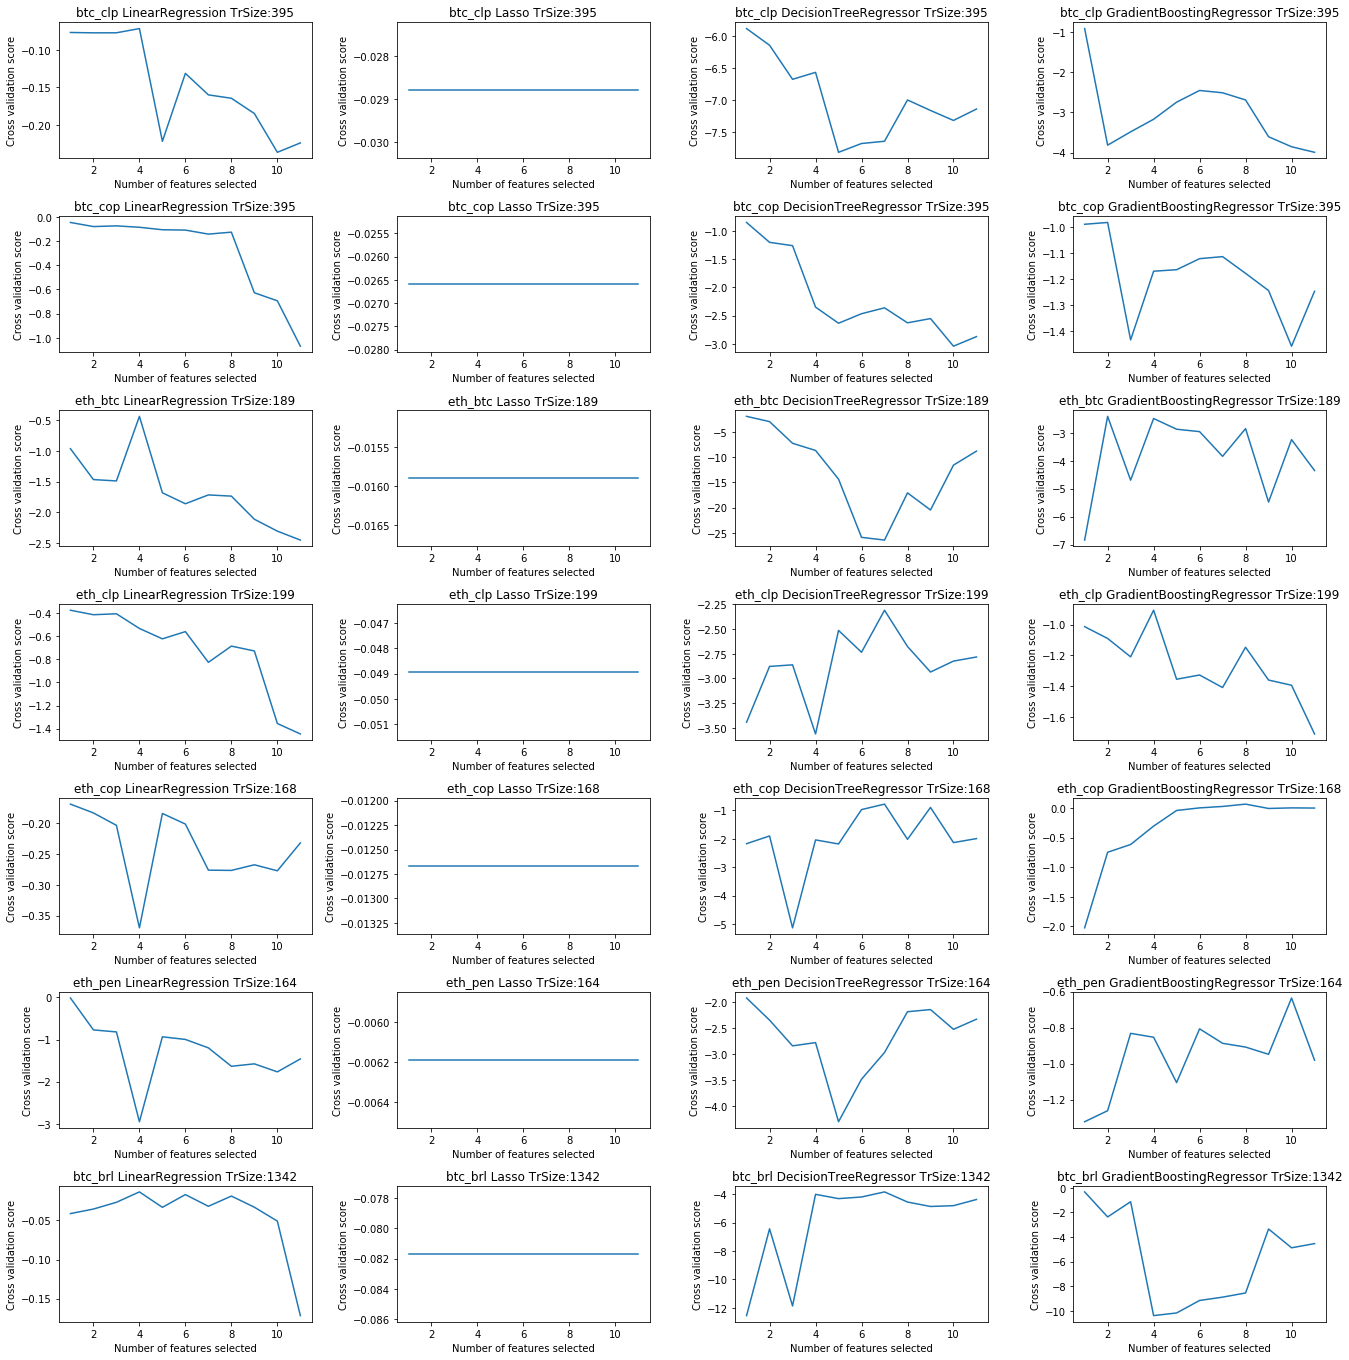

In [51]:
plotting_feature_selection(feature_selections,log_datasets,regressors )

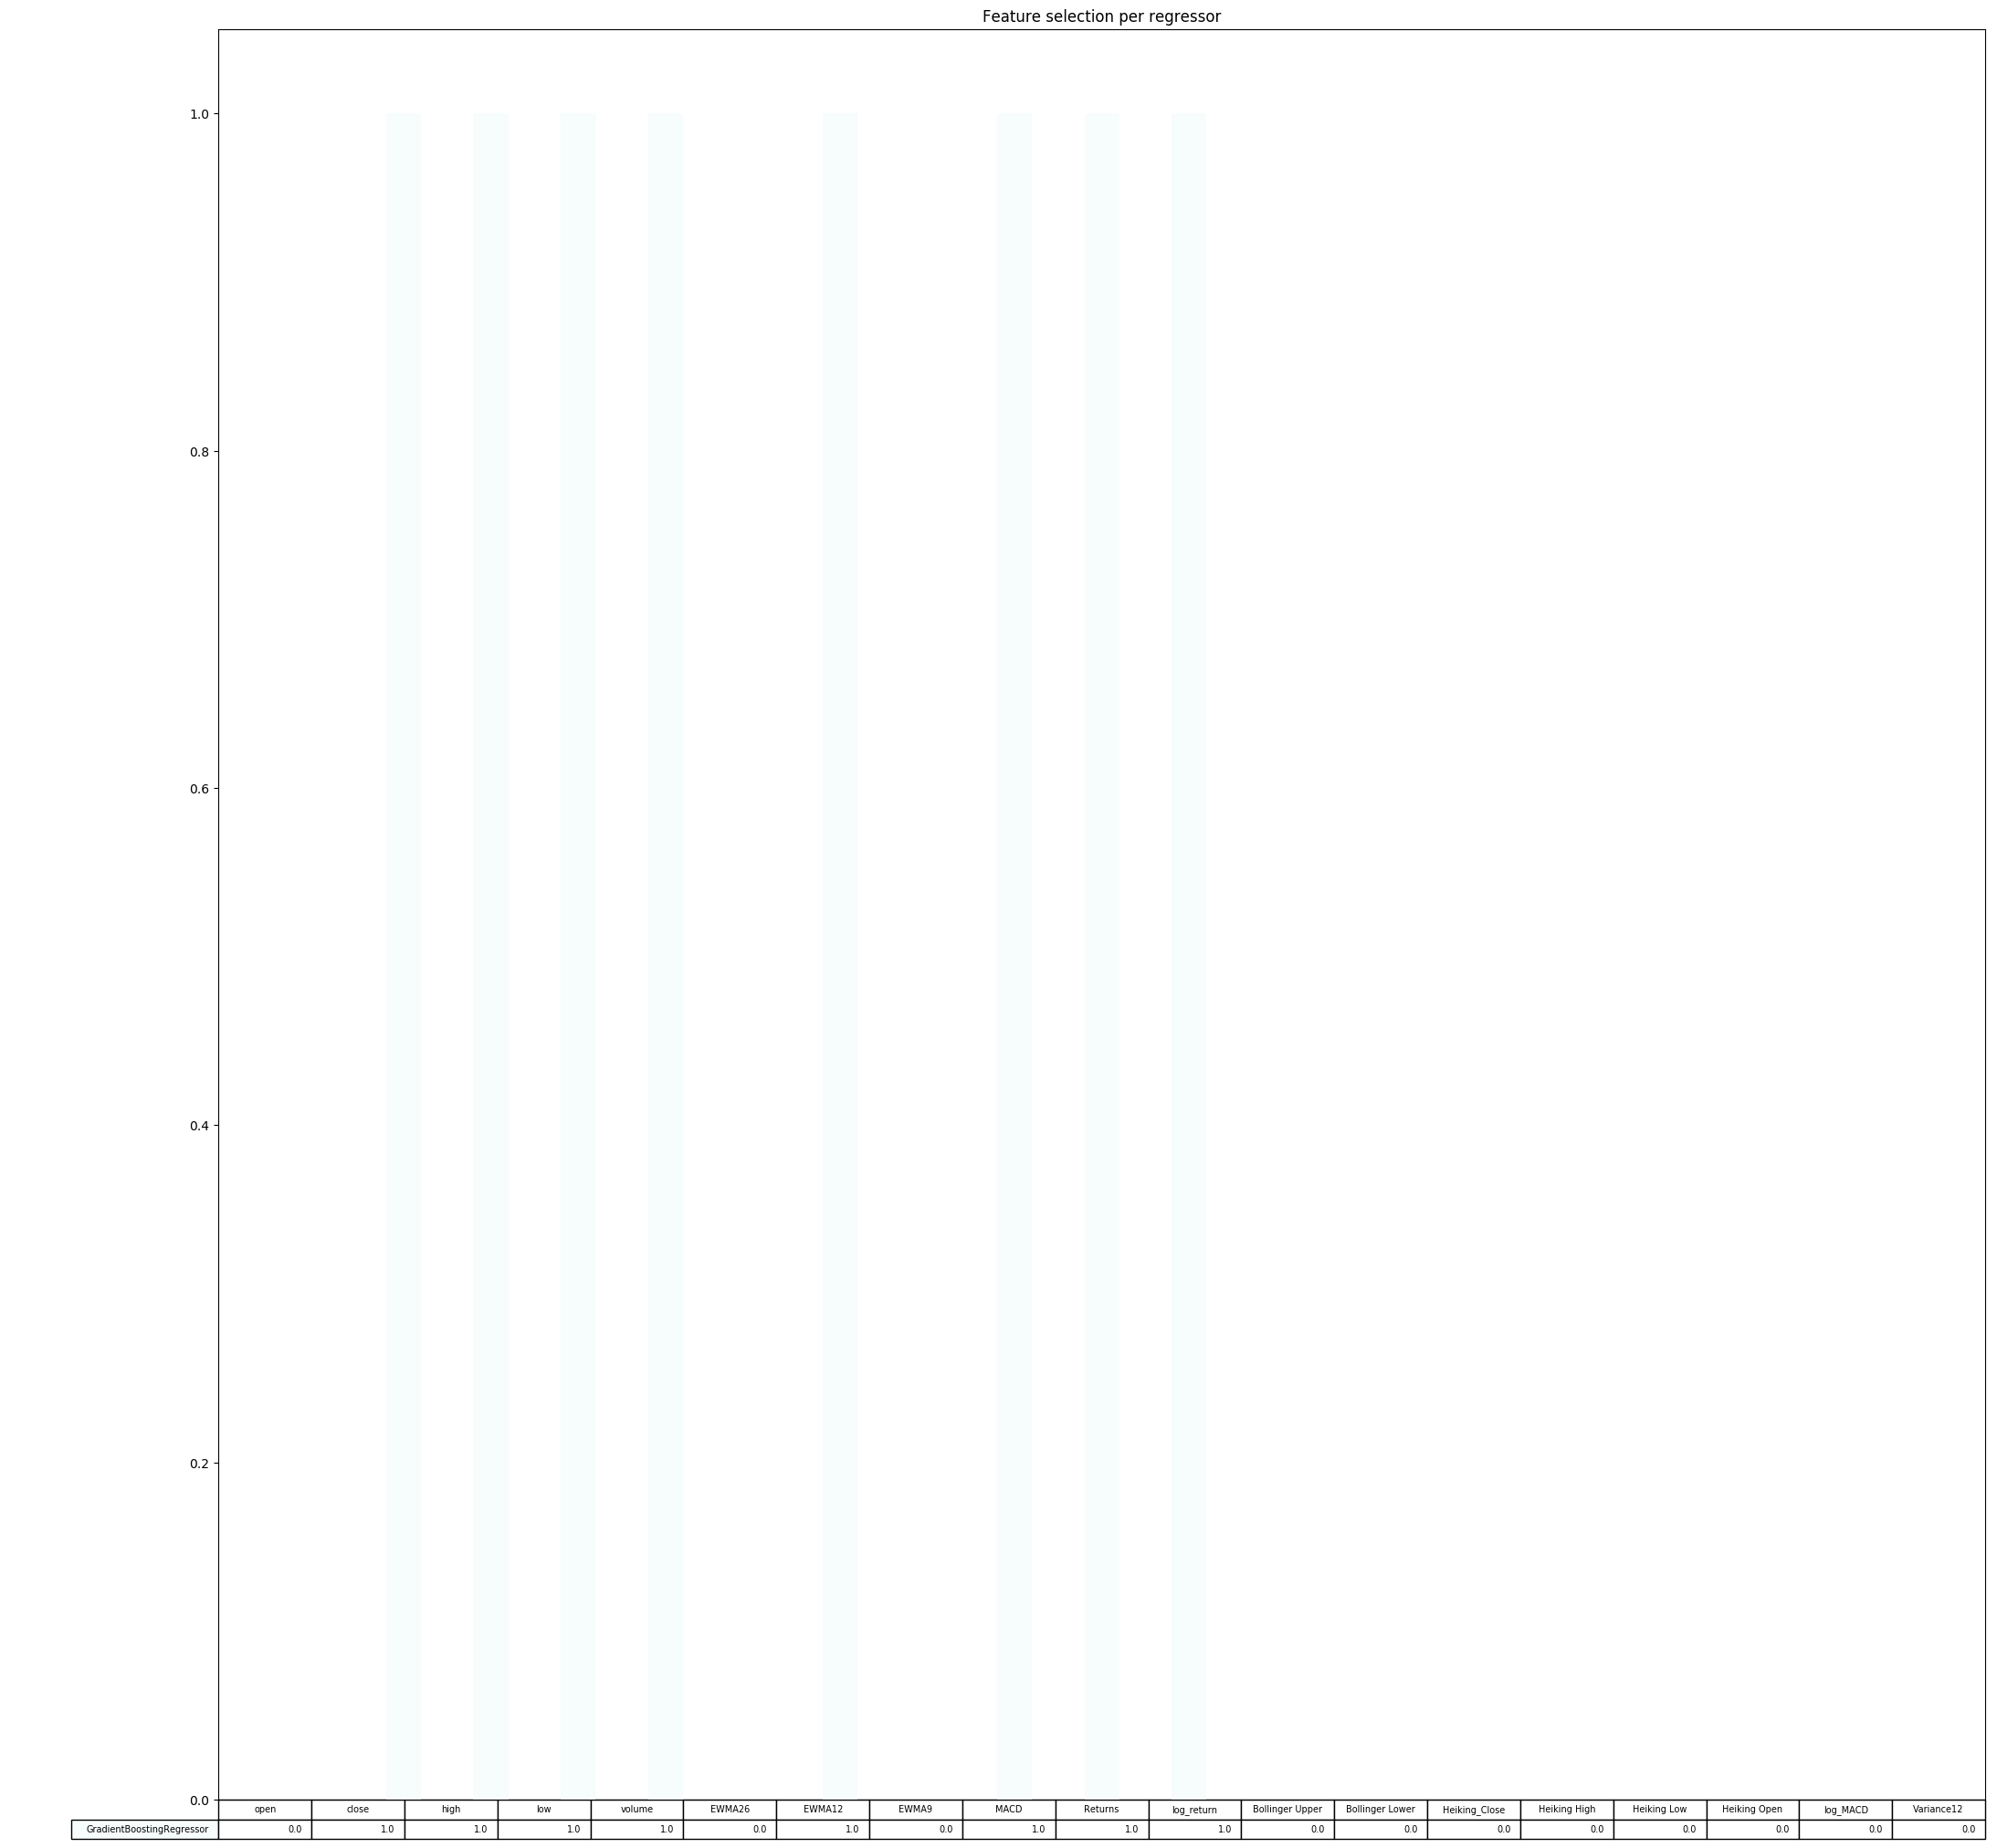

In [52]:
plot_feature_analysis(feature_selections,features)

In [53]:
score_log_return=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)
score_log_return

Best Score  Number of features  \
dataset regressor                                                   
eth_cop GradientBoostingRegressor    0.066307                   8   
eth_pen Lasso                       -0.006190                  11   
eth_cop Lasso                       -0.012669                  11   
btc_brl LinearRegression            -0.013426                   4   
eth_pen LinearRegression            -0.013621                   1   
eth_btc Lasso                       -0.015901                  11   
btc_cop Lasso                       -0.026595                  11   
btc_clp Lasso                       -0.028793                  11   
btc_cop LinearRegression            -0.046312                   1   
eth_clp Lasso                       -0.048937                  11   
btc_clp LinearRegression            -0.071019                   4   
btc_brl Lasso                       -0.081687                  11   
eth_cop LinearRegression            -0.169297                   1   
btc_brl GradientBoostingRegressor   -0.334576                   1   
eth_clp LinearRegression            -0.374492                   1   
eth_btc LinearRegression            -0.438235                   4   
eth_pen GradientBoostingRegressor   -0.635375                  10   
eth_cop DecisionTreeRegressor       -0.777846                   7   
btc_cop DecisionTreeRegressor       -0.853530                   1   
eth_clp GradientBoostingRegressor   -0.906915                   4   
btc_clp GradientBoostingRegressor   -0.915459                   1   
btc_cop GradientBoostingRegressor   -0.981045                   2   
eth_pen DecisionTreeRegressor       -1.918049                   1   
eth_btc DecisionTreeRegressor       -1.935807                   1   
eth_clp DecisionTreeRegressor       -2.309974                   7   
eth_btc GradientBoostingRegressor   -2.412666                   2   
btc_brl DecisionTreeRegressor       -3.840144                   7   
btc_clp DecisionTreeRegressor       -5.886151                   1   

                                                                            features  
dataset regressor                                                                     
eth_cop GradientBoostingRegressor  [close, high, low, volume, EWMA12, MACD, Retur...  
eth_pen Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_brl LinearRegression                               [EWMA26, EWMA12, EWMA9, MACD]  
eth_pen LinearRegression                                                [log_return]  
eth_btc Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_cop Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_clp Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_cop LinearRegression                                                [log_return]  
eth_clp Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_clp LinearRegression                          [volume, EWMA26, MACD, log_return]  
btc_brl Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop LinearRegression                                                    [volume]  
btc_brl GradientBoostingRegressor                                       [log_return]  
eth_clp LinearRegression                                                [log_return]  
eth_btc LinearRegression                         [close, volume, EWMA26, log_return]  
eth_pen GradientBoostingRegressor  [open, close, high, low, volume, EWMA12, EWMA9...  
eth_cop DecisionTreeRegressor      [open, close, low, volume, EWMA9, MACD, log_re...  
btc_cop DecisionTreeRegressor                                                [EWMA9]  
eth_clp GradientBoostingRegressor                 [close, volume, EWMA9, log_return]  
btc_clp GradientBoostingRegressor                 

## Analysis Log Series Return Log

In [54]:
def building_series_to_each_input_log_return(dataset,N=15):
    return building_series_to_each_input(dataset,column_series=['log_return'])

log_datasets_series_return=copy_all_datasets(log_datasets)
all_datasets(building_series_to_each_input_log_return,log_datasets_series_return) 

features_series=['open','close','high','volume','EWMA26','EWMA12','EWMA9',
                 'Returns','log_return','Variance12','log_MACD',
                 'log_return_01','log_return_02','log_return_03',
                 'log_return_04','log_return_05','log_return_06',
                 'log_return_07','log_return_08','log_return_09',
                 'log_return_10','log_return_11','log_return_12',
                 'log_return_13','log_return_14','log_return_15']

feature_selections_series=feature_selection_analysis(log_datasets_series_return,regressors,features_series,target_log_return)

building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearR

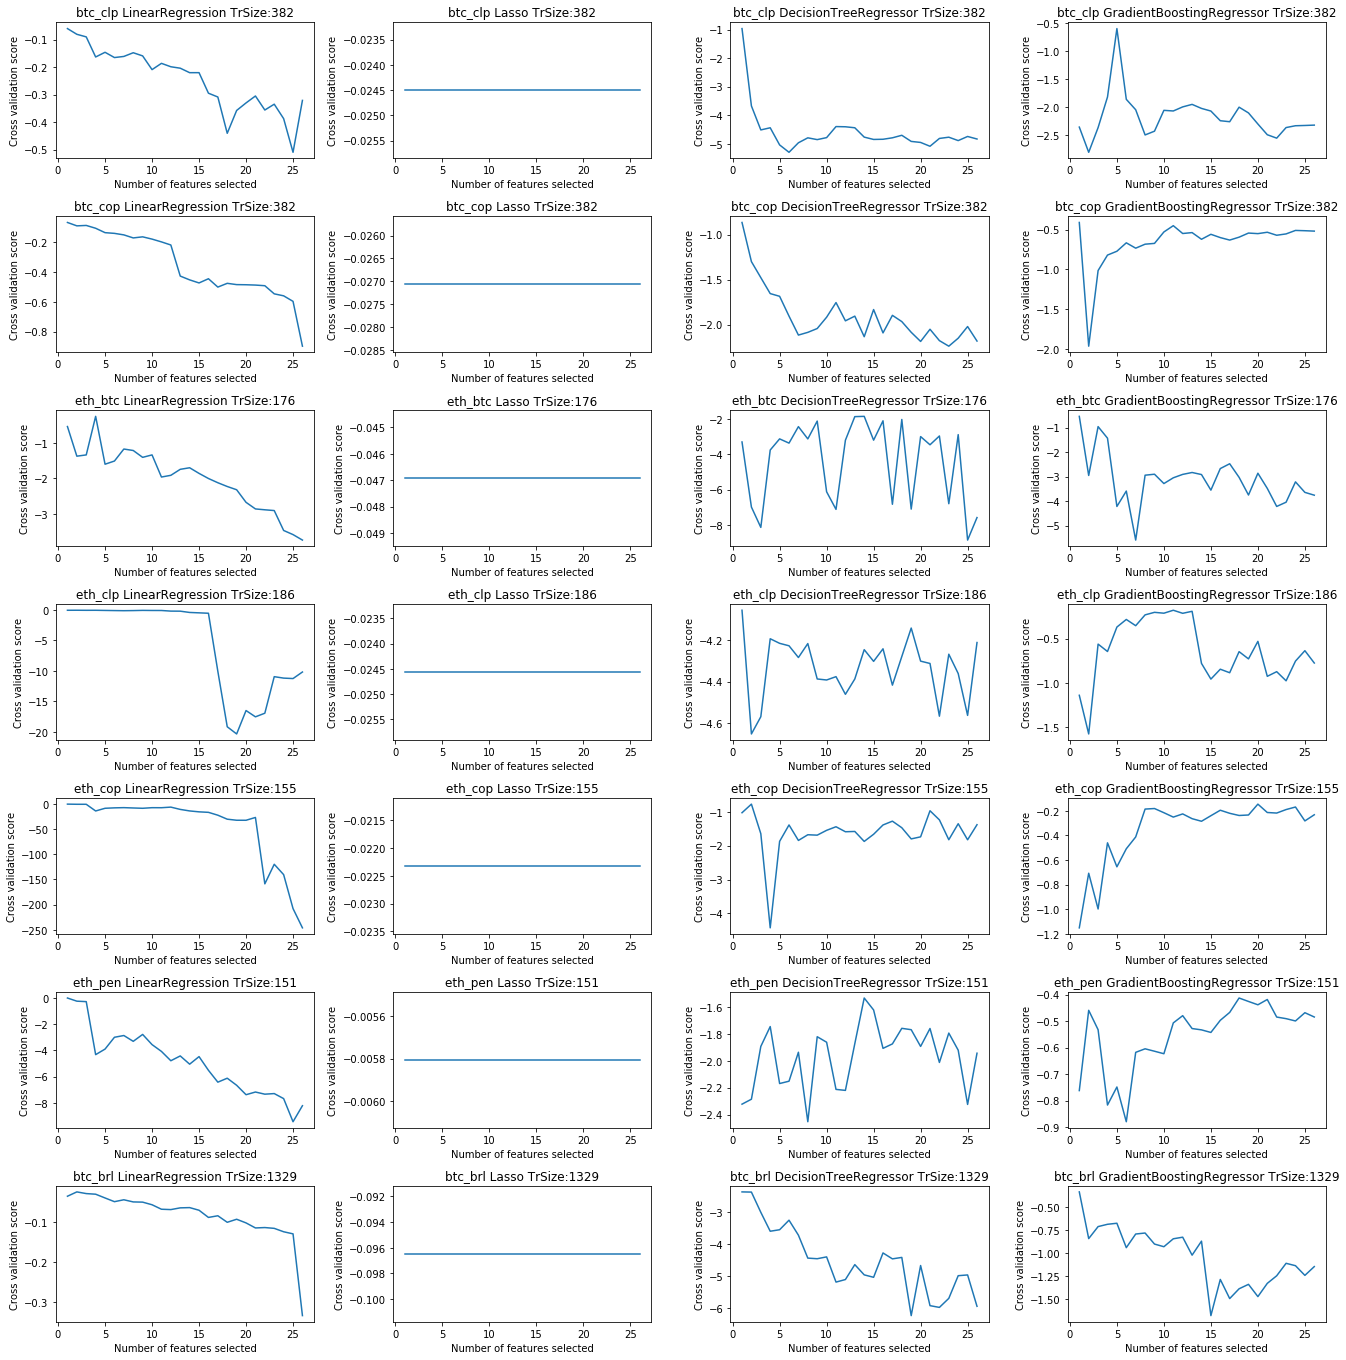

In [55]:
plotting_feature_selection(feature_selections_series,log_datasets_series_return,regressors)

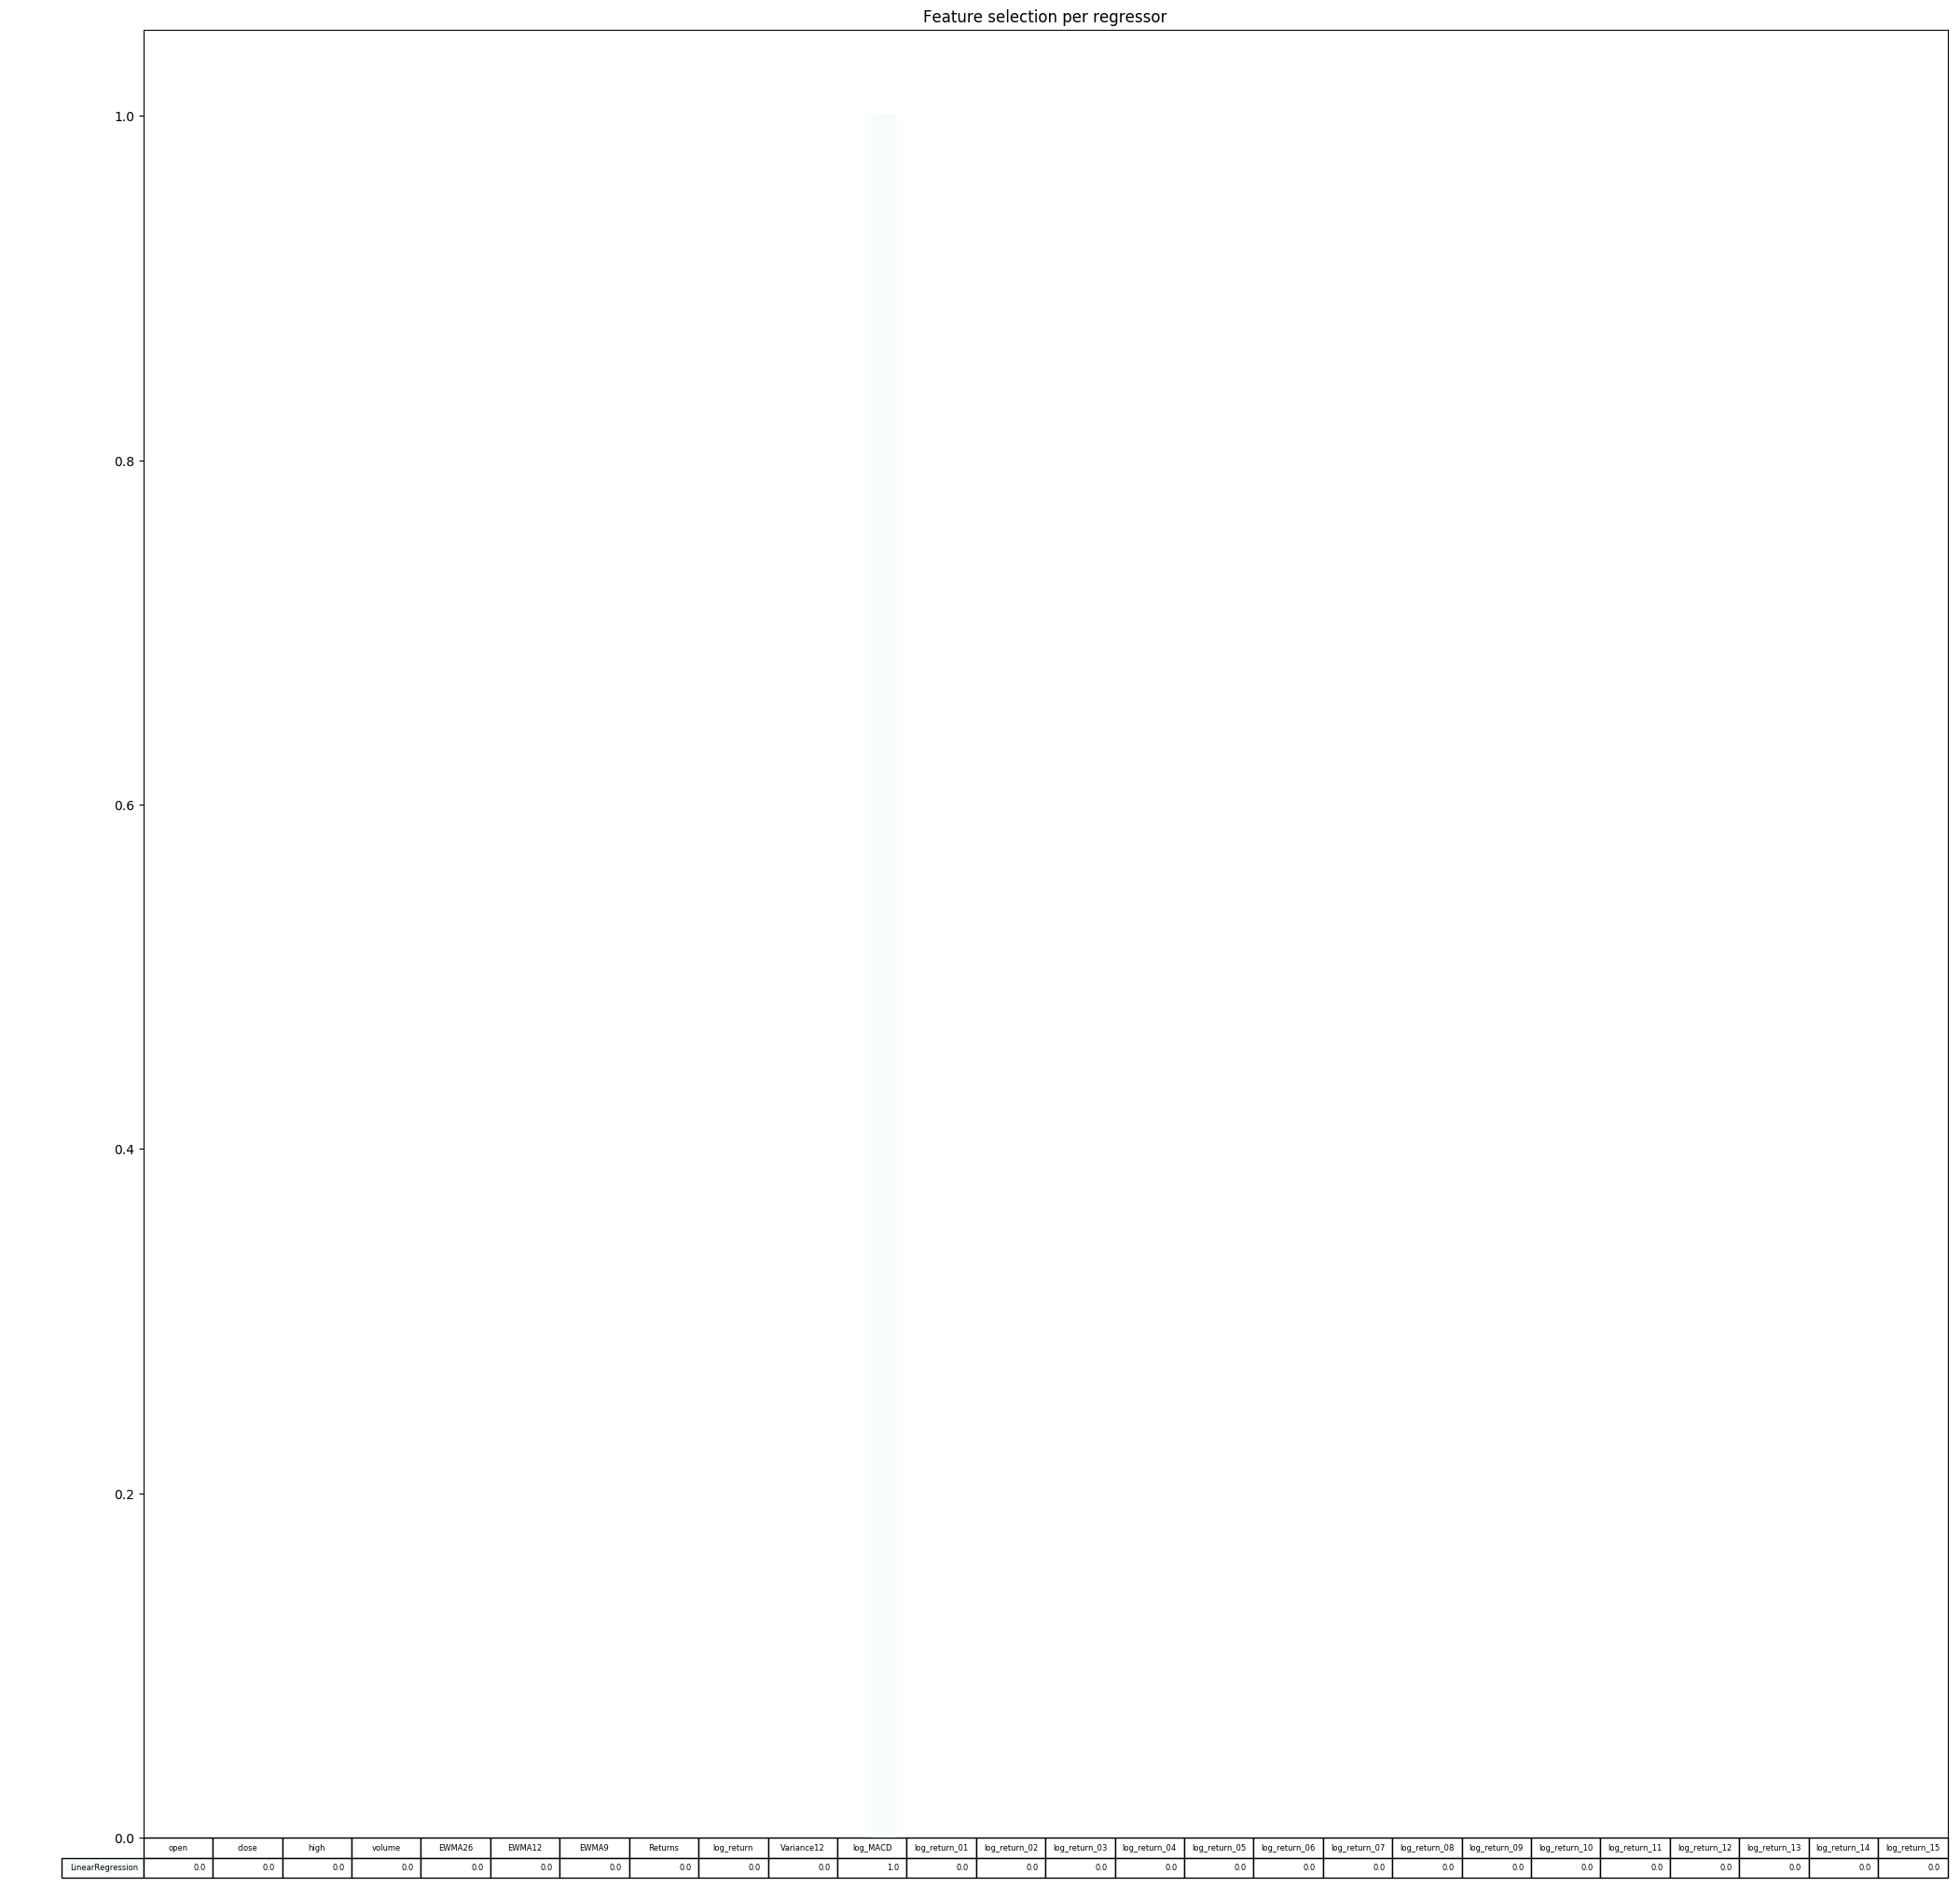

In [56]:
plot_feature_analysis(feature_selections_series,features_series)

In [57]:
score_log_series_return=get_best_score_per_regressor_and_dataset(feature_selections_series,features_series).sort_values('Best Score',ascending=False)

## Analysis Ratio Clean Return Log

In [58]:
log_divided_close_datasets.pop('btc_pen',"default")

feature_selections=feature_selection_analysis(log_divided_close_datasets,regressors,features_log,target_log_return)

make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearRegression
eth_cop
Lasso
eth_cop
DecisionTreeRegressor
eth_cop
GradientBoostingRegressor
eth_cop
LinearRegression
eth_pen
Lasso
eth_pen
DecisionTreeRegressor
eth_pen
GradientBoostingRegressor
eth_pen
LinearRegression
btc_brl
Lasso
btc_brl
DecisionTreeRegressor
btc_brl
GradientBoostingReg

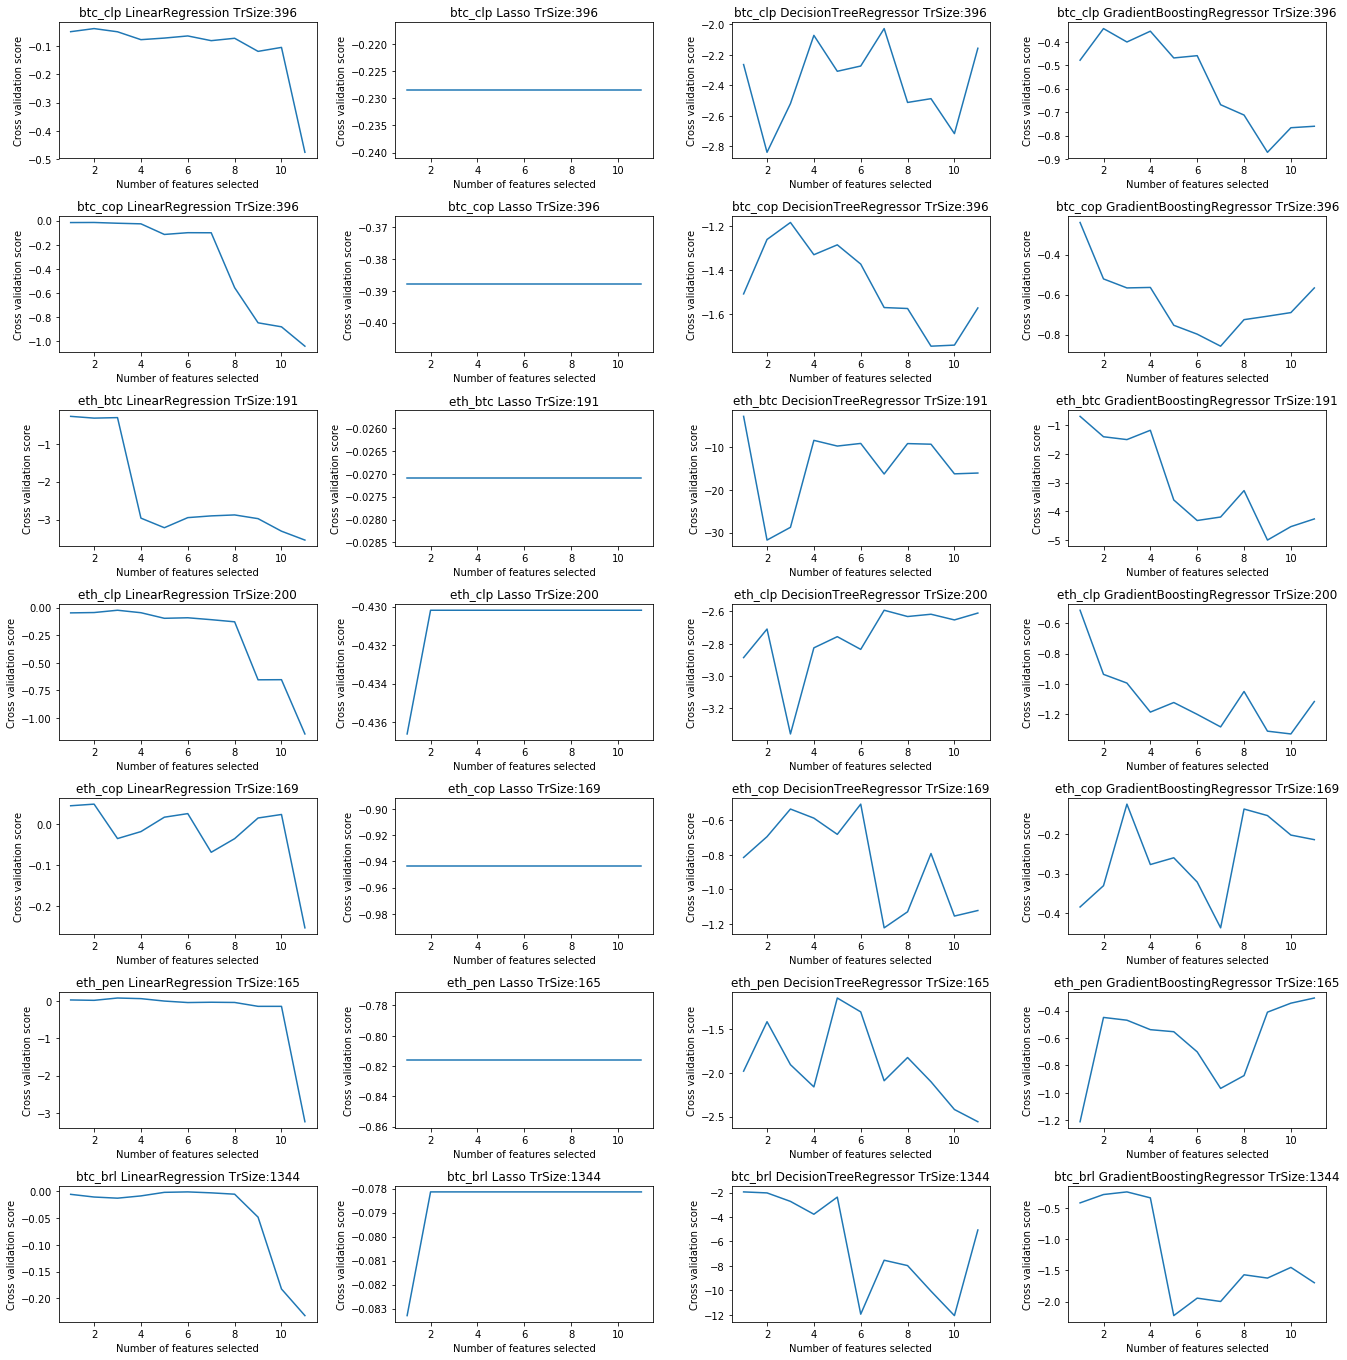

In [59]:
plotting_feature_selection(feature_selections,log_divided_close_datasets,regressors )

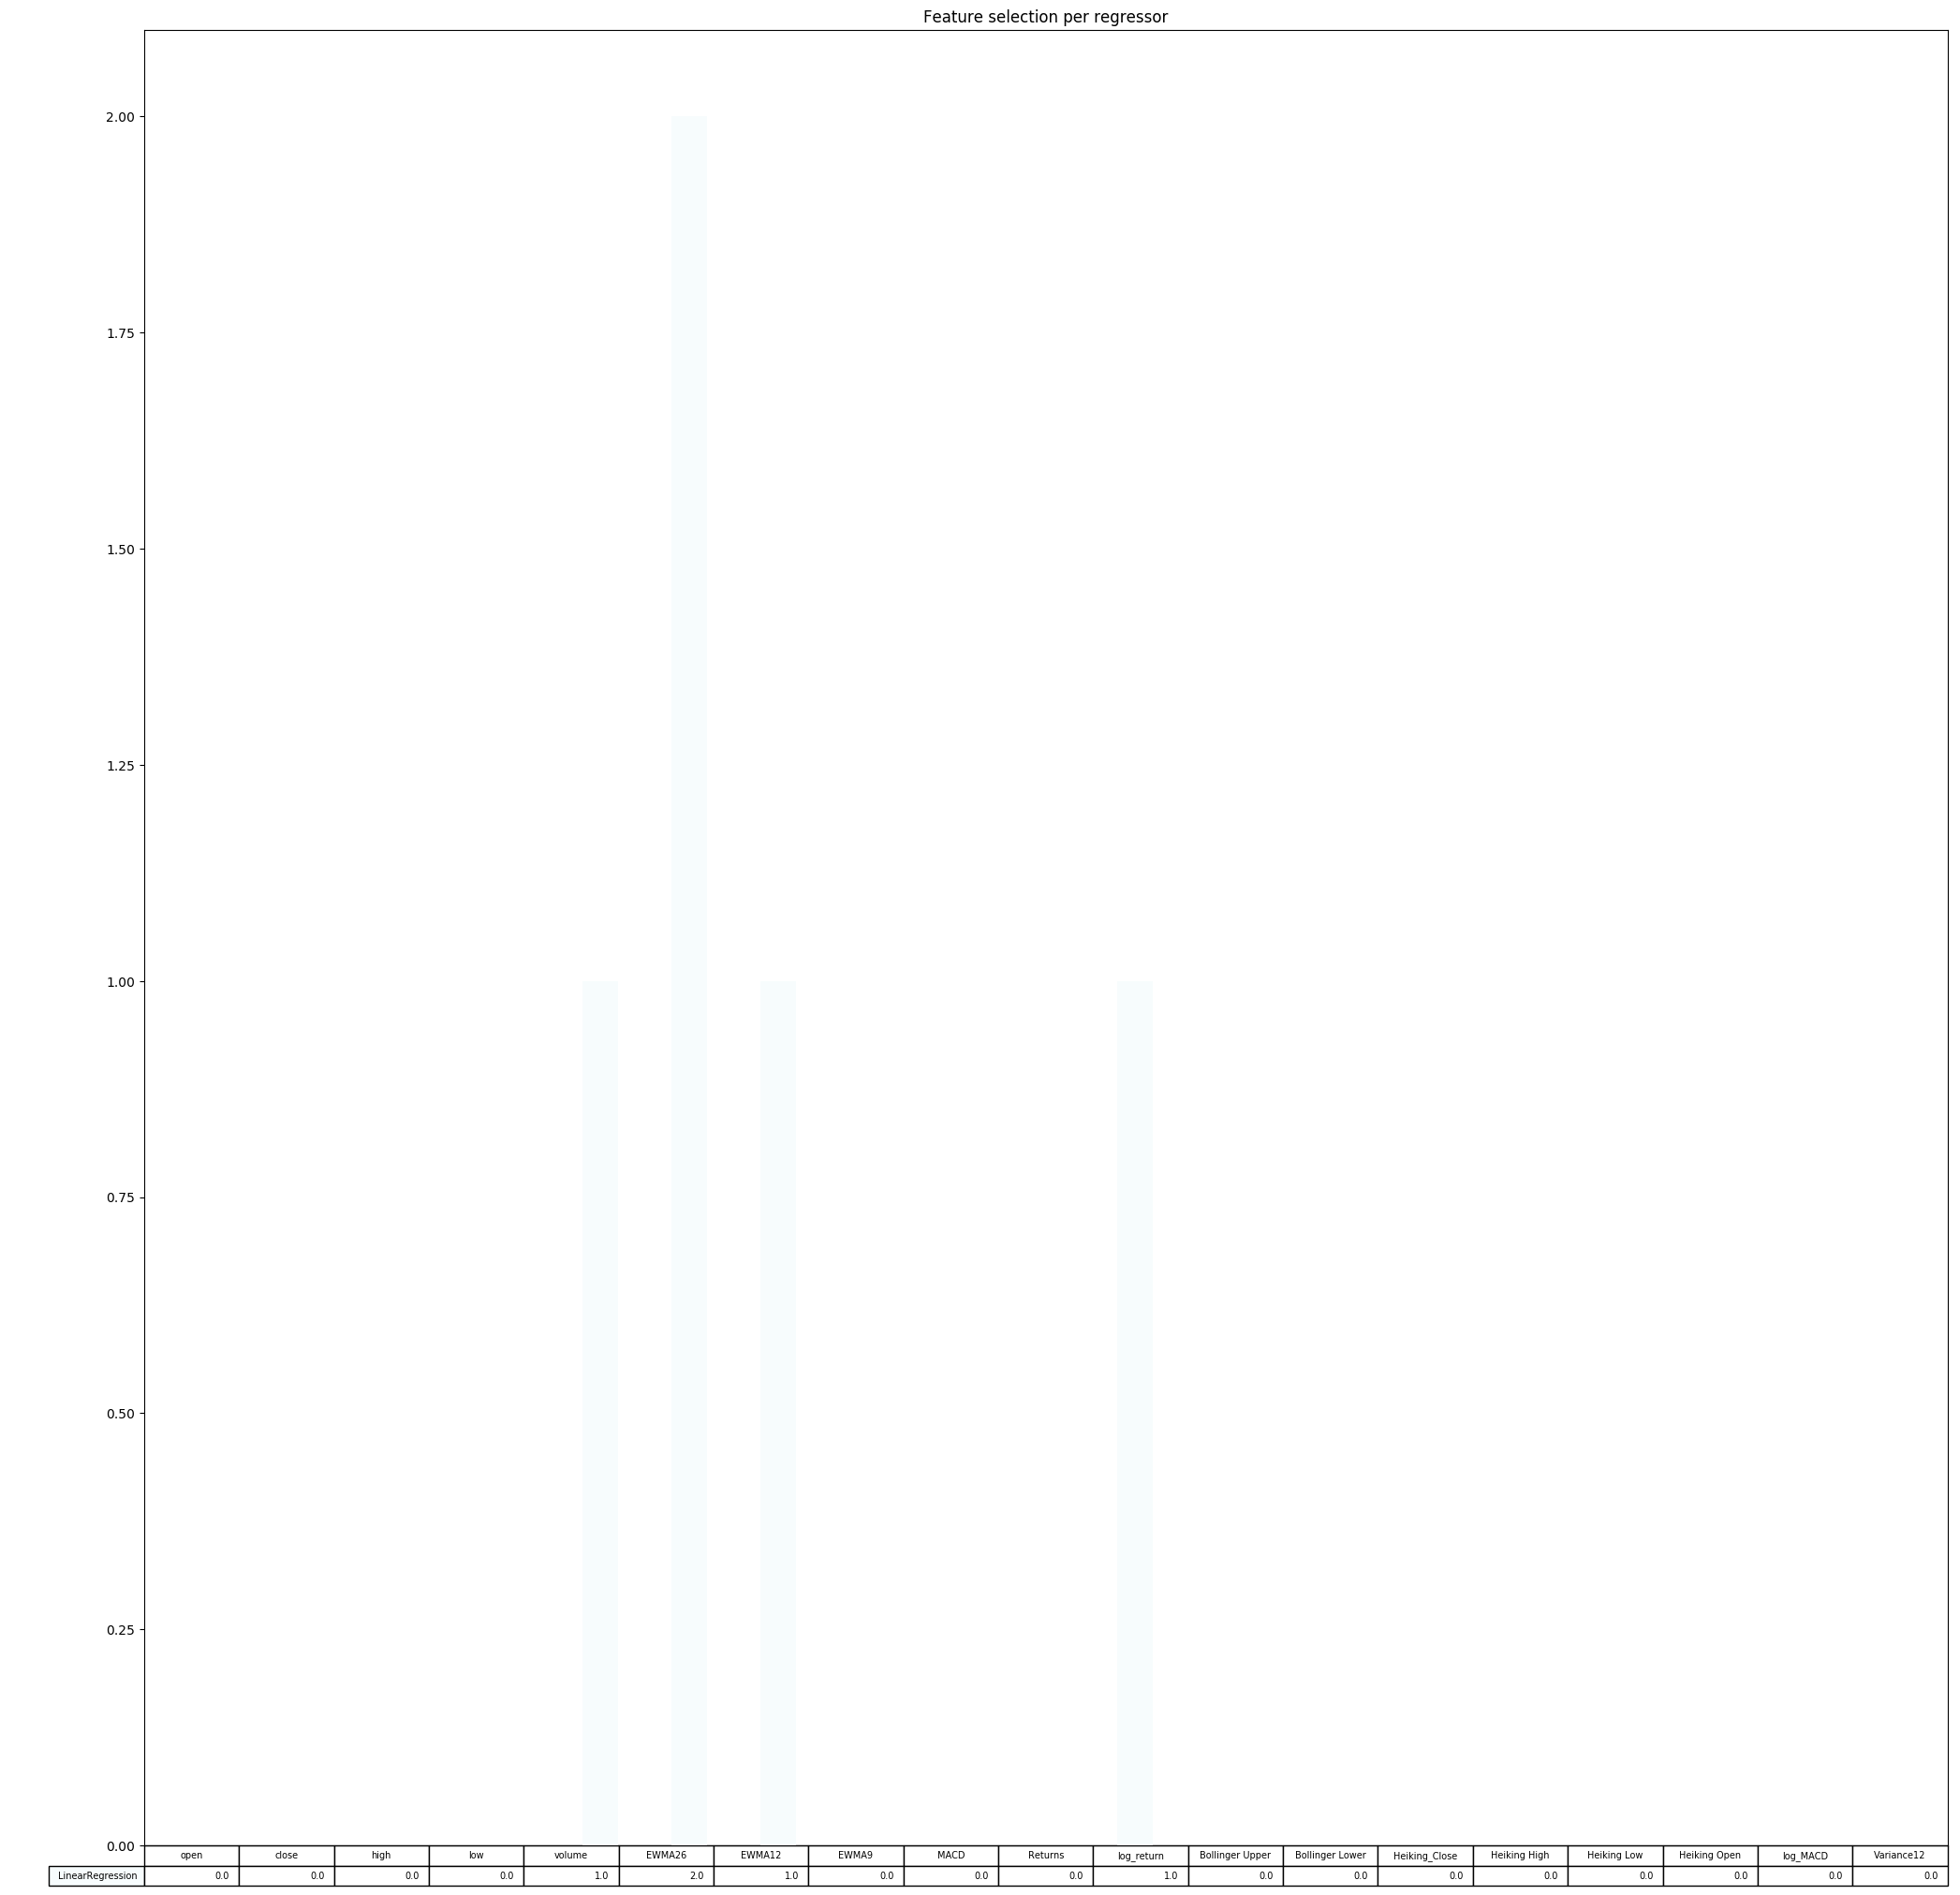

In [60]:
plot_feature_analysis(feature_selections,features)

In [61]:
score_log_divided_return=get_best_score_per_regressor_and_dataset(feature_selections,features).sort_values('Best Score',ascending=False)
score_log_divided_return

Best Score  Number of features  \
dataset regressor                                                   
eth_pen LinearRegression             0.083839                   3   
eth_cop LinearRegression             0.049910                   2   
btc_brl LinearRegression            -0.001244                   6   
btc_cop LinearRegression            -0.015492                   2   
eth_clp LinearRegression            -0.024409                   3   
eth_btc Lasso                       -0.027096                  11   
btc_clp LinearRegression            -0.037855                   2   
btc_brl Lasso                       -0.078136                  11   
eth_cop GradientBoostingRegressor   -0.123004                   3   
btc_clp Lasso                       -0.228534                  11   
btc_cop GradientBoostingRegressor   -0.238864                   1   
btc_brl GradientBoostingRegressor   -0.247779                   3   
eth_btc LinearRegression            -0.276944                   1   
eth_pen GradientBoostingRegressor   -0.308038                  11   
btc_clp GradientBoostingRegressor   -0.343784                   2   
btc_cop Lasso                       -0.387992                  11   
eth_clp Lasso                       -0.430186                  11   
eth_cop DecisionTreeRegressor       -0.506835                   6   
eth_clp GradientBoostingRegressor   -0.513931                   1   
eth_btc GradientBoostingRegressor   -0.685619                   1   
eth_pen Lasso                       -0.815931                  11   
eth_cop Lasso                       -0.943442                  11   
eth_pen DecisionTreeRegressor       -1.140423                   5   
btc_cop DecisionTreeRegressor       -1.182375                   3   
btc_brl DecisionTreeRegressor       -1.944522                   1   
btc_clp DecisionTreeRegressor       -2.027200                   7   
eth_clp DecisionTreeRegressor       -2.593274                   7   
eth_btc DecisionTreeRegressor       -2.748205                   1   

                                                                            features  
dataset regressor                                                                     
eth_pen LinearRegression                                [EWMA26, EWMA12, log_return]  
eth_cop LinearRegression                                            [volume, EWMA26]  
btc_brl LinearRegression           [volume, EWMA26, EWMA12, EWMA9, MACD, log_return]  
btc_cop LinearRegression                                        [volume, log_return]  
eth_clp LinearRegression                                [volume, EWMA26, log_return]  
eth_btc Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_clp LinearRegression                                        [volume, log_return]  
btc_brl Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop GradientBoostingRegressor                           [close, EWMA26, Returns]  
btc_clp Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
btc_cop GradientBoostingRegressor                                           [EWMA26]  
btc_brl GradientBoostingRegressor                         [open, volume, log_return]  
eth_btc LinearRegression                                                    [EWMA12]  
eth_pen GradientBoostingRegressor  [open, close, high, low, volume, EWMA26, EWMA1...  
btc_clp GradientBoostingRegressor                                      [low, EWMA12]  
btc_cop Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_clp Lasso                      [open, close, high, low, volume, EWMA26, EWMA1...  
eth_cop DecisionTreeRegressor       [close, high, volume, EWMA26, EWMA9, log_return]  
eth_clp GradientBoostingRegressor                                            [close]  
eth_btc GradientBoostingRegressor                                          [Returns]  
eth_pen Lasso                      [open, close, h

## Analysis Ratio Series Return Log

In [62]:

log_divided_close_datasets_series=copy_all_datasets(log_divided_close_datasets)
all_datasets(building_series_to_each_input_log_return,log_divided_close_datasets_series) 

features_series=['open','close','high','volume','EWMA26','EWMA12','EWMA9',
                 'Returns','log_return','Variance12','log_MACD',
                 'log_return_01','log_return_02','log_return_03',
                 'log_return_04','log_return_05','log_return_06',
                 'log_return_07','log_return_08','log_return_09',
                 'log_return_10','log_return_11','log_return_12',
                 'log_return_13','log_return_14','log_return_15']

feature_selections_series=feature_selection_analysis(log_divided_close_datasets_series,regressors,features_series,target_log_return)

building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
building_series_to_each_input_log_return
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
make_test_train_cv_indexes
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
making_targets
LinearRegression
btc_clp
Lasso
btc_clp
DecisionTreeRegressor
btc_clp
GradientBoostingRegressor
btc_clp
LinearRegression
btc_cop
Lasso
btc_cop
DecisionTreeRegressor
btc_cop
GradientBoostingRegressor
btc_cop
LinearRegression
eth_btc
Lasso
eth_btc
DecisionTreeRegressor
eth_btc
GradientBoostingRegressor
eth_btc
LinearRegression
eth_clp
Lasso
eth_clp
DecisionTreeRegressor
eth_clp
GradientBoostingRegressor
eth_clp
LinearR

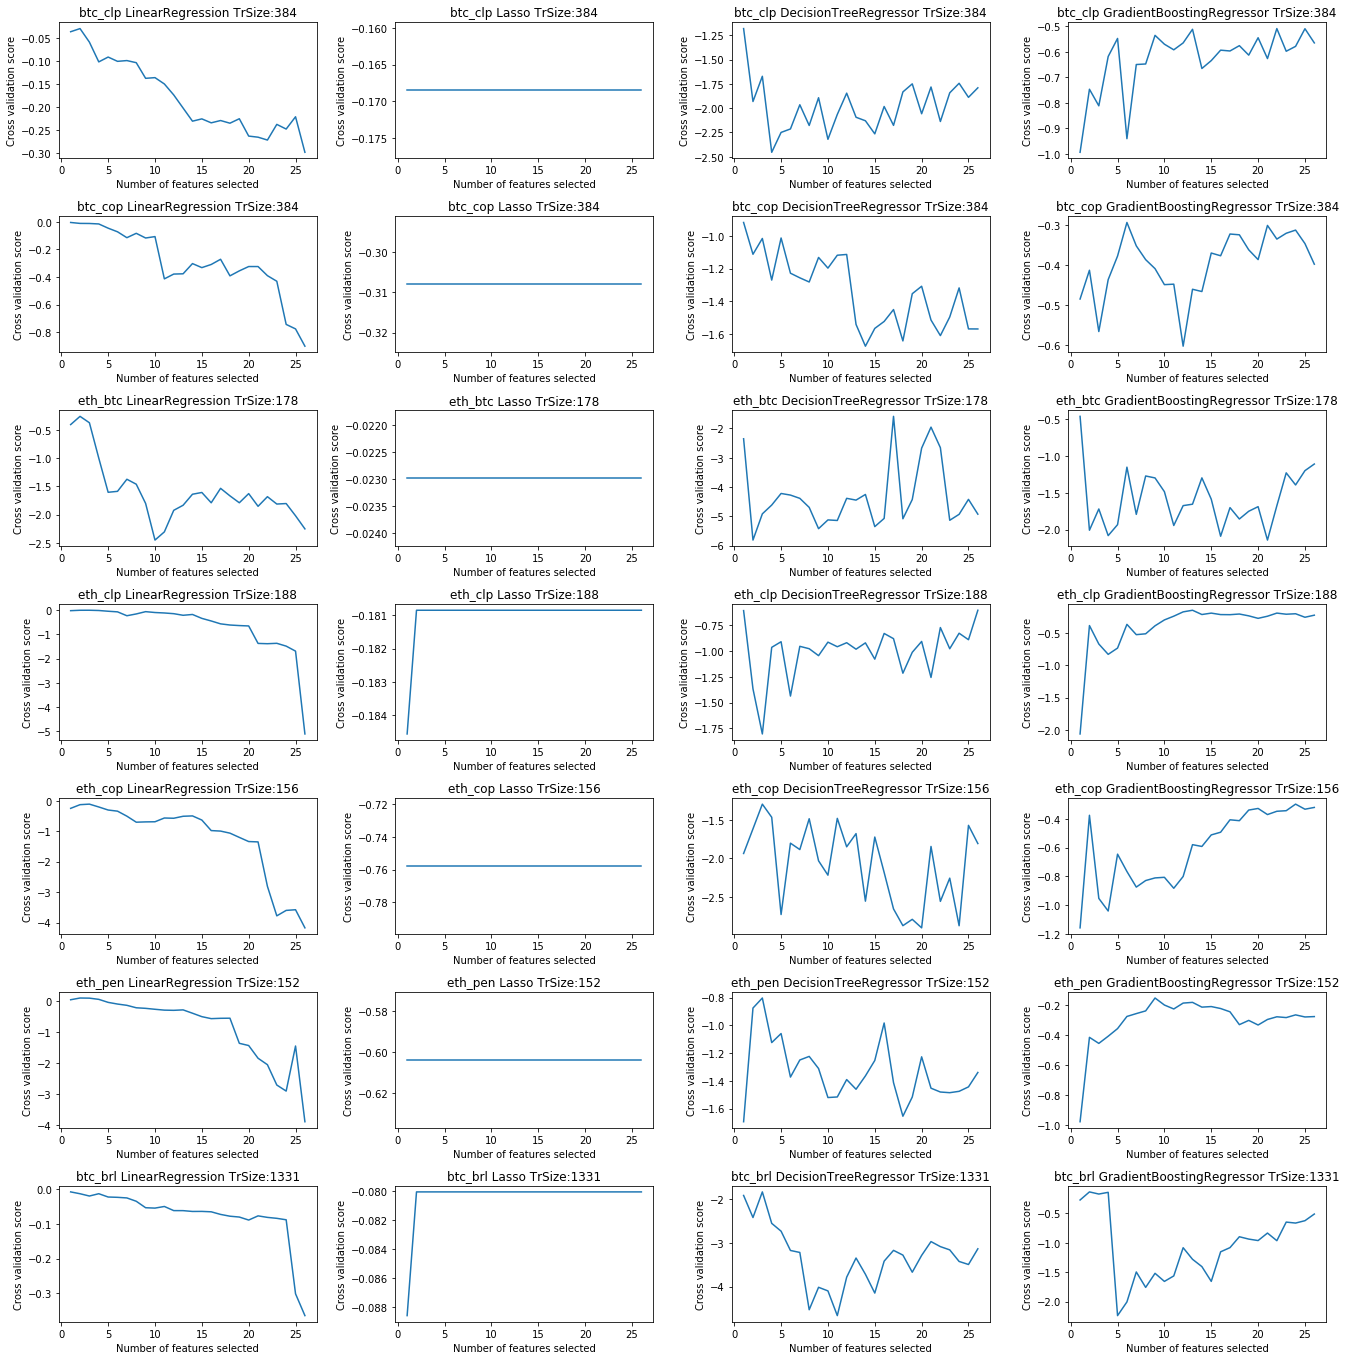

In [63]:
plotting_feature_selection(feature_selections_series,log_divided_close_datasets_series,regressors)

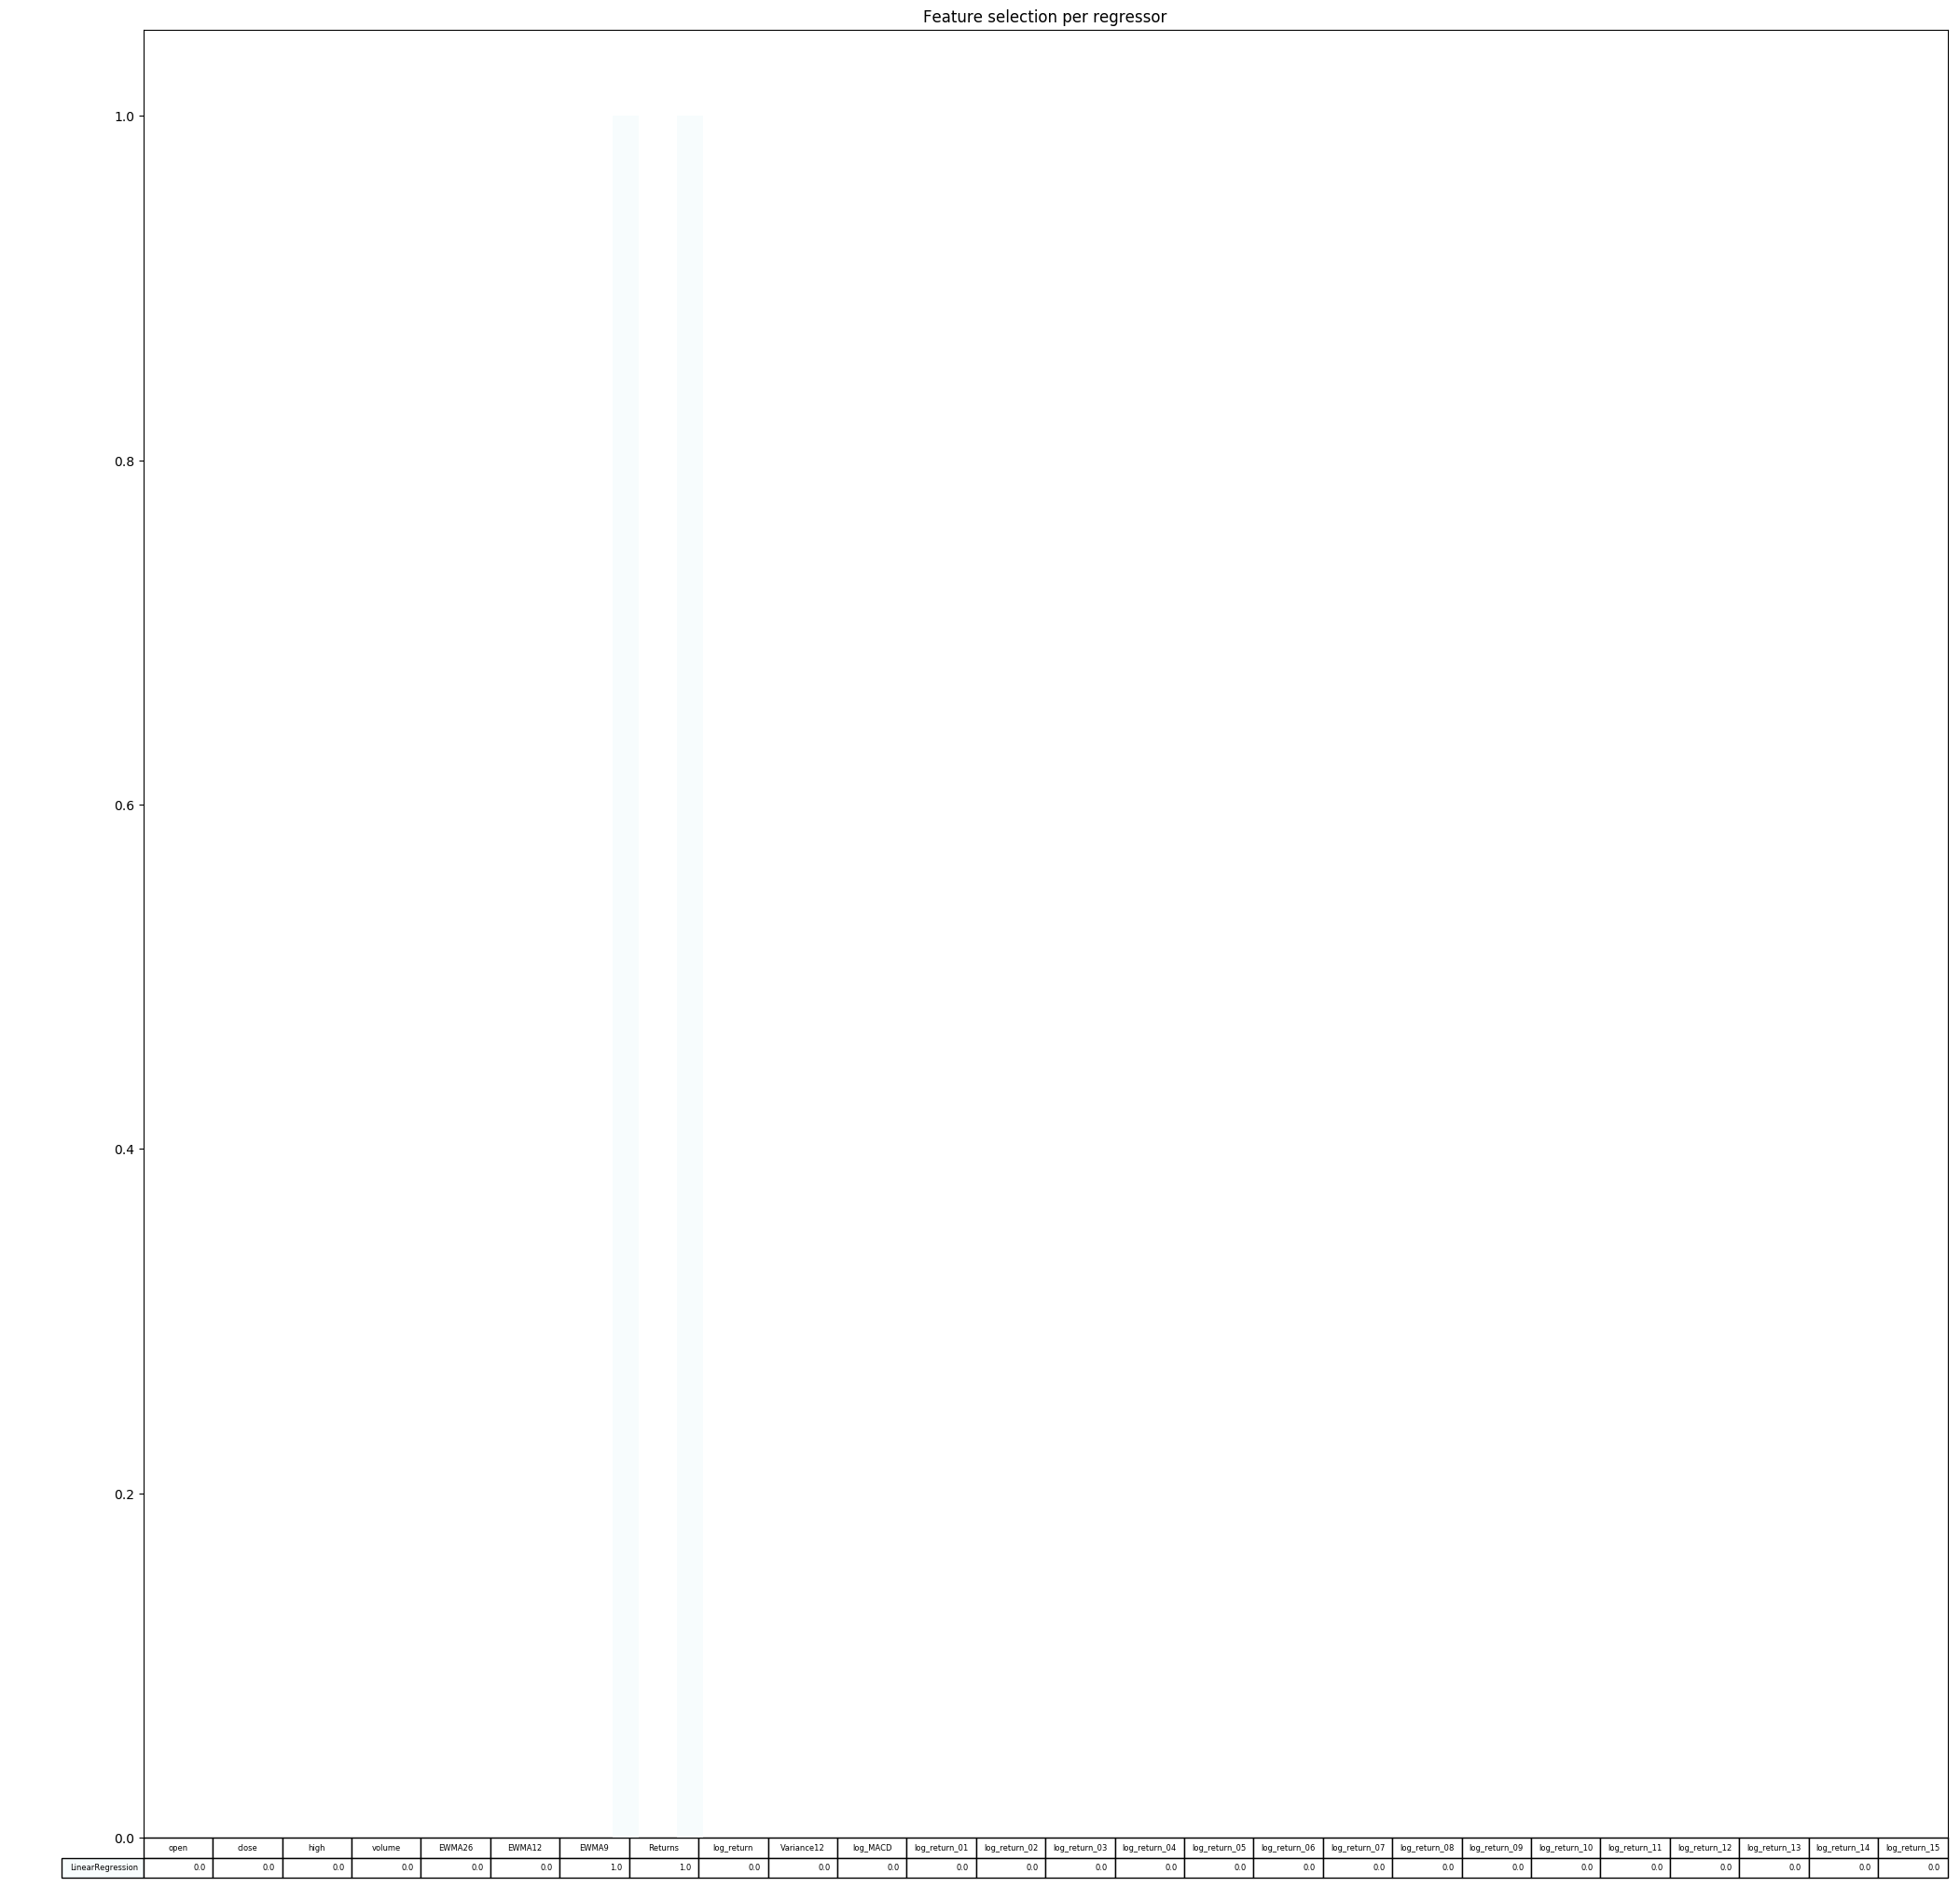

In [64]:
plot_feature_analysis(feature_selections_series,features_series)

In [65]:
score_log_divided_series_return=get_best_score_per_regressor_and_dataset(feature_selections_series,features_series).sort_values('Best Score',ascending=False)
score_log_divided_series_return

Best Score  Number of features  \
dataset regressor                                                   
eth_pen LinearRegression             0.096085                   2   
eth_clp LinearRegression            -0.002213                   3   
btc_cop LinearRegression            -0.004422                   1   
btc_brl LinearRegression            -0.008778                   1   
eth_btc Lasso                       -0.022986                  26   
btc_clp LinearRegression            -0.028647                   2   
btc_brl Lasso                       -0.080081                  26   
eth_cop LinearRegression            -0.111127                   3   
btc_brl GradientBoostingRegressor   -0.133889                   2   
eth_clp GradientBoostingRegressor   -0.148329                  13   
eth_pen GradientBoostingRegressor   -0.152696                   9   
btc_clp Lasso                       -0.168524                  26   
eth_clp Lasso                       -0.180847                  26   
eth_btc LinearRegression            -0.262785                   2   
btc_cop GradientBoostingRegressor   -0.294434                   6   
eth_cop GradientBoostingRegressor   -0.297853                  24   
btc_cop Lasso                       -0.307998                  26   
eth_btc GradientBoostingRegressor   -0.463222                   1   
btc_clp GradientBoostingRegressor   -0.508892                  22   
eth_clp DecisionTreeRegressor       -0.603335                  26   
eth_pen Lasso                       -0.603804                  26   
eth_cop Lasso                       -0.757814                  26   
eth_pen DecisionTreeRegressor       -0.802843                   3   
btc_cop DecisionTreeRegressor       -0.917504                   1   
btc_clp DecisionTreeRegressor       -1.179522                   1   
eth_cop DecisionTreeRegressor       -1.294353                   3   
eth_btc DecisionTreeRegressor       -1.585112                  17   
btc_brl DecisionTreeRegressor       -1.832642                   3   

                                                                            features  
dataset regressor                                                                     
eth_pen LinearRegression                                            [EWMA9, Returns]  
eth_clp LinearRegression                                  [EWMA26, EWMA12, log_MACD]  
btc_cop LinearRegression                                                  [log_MACD]  
btc_brl LinearRegression                                                  [log_MACD]  
eth_btc Lasso                      [open, close, high, volume, EWMA26, EWMA12, EW...  
btc_clp LinearRegression                                          [EWMA26, log_MACD]  
btc_brl Lasso                      [open, close, high, volume, EWMA26, EWMA12, EW...  
eth_cop LinearRegression                                  [EWMA26, EWMA12, log_MACD]  
btc_brl GradientBoostingRegressor                            [EWMA12, log_return_02]  
eth_clp GradientBoostingRegressor  [open, close, high, volume, EWMA12, log_MACD, ...  
eth_pen GradientBoostingRegressor  [EWMA26, EWMA9, log_MACD, log_return_01, log_r...  
btc_clp Lasso                      [open, close, high, volume, EWMA26, EWMA12, EW...  
eth_clp Lasso                      [open, close, high, volume, EWMA26, EWMA12, EW...  
eth_btc LinearRegression                                              [open, EWMA12]  
btc_cop GradientBoostingRegressor  [open, EWMA12, log_return_01, log_return_02, l...  
eth_cop GradientBoostingRegressor  [open, close, high, volume, EWMA26, EWMA12, Re...  
btc_cop Lasso                      [open, close, high, volume, EWMA26, EWMA12, EW...  
eth_btc GradientBoostingRegressor                                             [open]  
btc_clp GradientBoostingRegressor  [close, high, volume, EWMA26, EWMA12, EWMA9, R...  
eth_clp DecisionTreeRegressor      [open, close, high, volume, EWMA26, EWMA12, EW...  
eth_pen Lasso                      [open, close, h

# Choose the best results per dataset.

In [66]:
set_of_datasets={}
set_of_datasets['clean']=datasets
set_of_datasets['clean_close_series']=datasets_series
set_of_datasets['rescaled']=rescaled_datasets
set_of_datasets['rescaled_close_series']=datasets_series_rescaled
set_of_datasets['clean_return_series']=datasets_series_return
set_of_datasets['log']=log_datasets
set_of_datasets['log_close_series']=log_datasets_series
set_of_datasets['log_return_series']=log_datasets_series_return
set_of_datasets['log_divided']=log_divided_close_datasets
set_of_datasets['log_divided_return']=log_divided_close_datasets_series

In [67]:
set_of_datasets




{'clean': {'btc_brl': DatasetMLModel(exchange='MercadoBitcoin', df=                    low        volume  amount     avg_price         open  \
datetime                                                                   
2013-06-14    245.00000  8.694711e+03      35    255.423818    267.00000   
2013-06-15    246.01000  4.481406e+03       8    256.873845    250.00000   
2013-06-16    246.01000  4.276901e+02      14    256.224600    246.01000   
2013-06-17    252.00000  3.628959e+03      12    254.518924    257.43000   
2013-06-18    246.11000  7.498586e+03      22    256.790242    254.95000   
2013-06-19    251.01000  1.137085e+03      18    262.956694    251.01000   
2013-06-20    260.00002  7.253134e+03      28    267.506042    262.99999   
2013-06-21    250.22000  4.652796e+03      25    260.958020    269.00000   
2013-06-22    261.83300  1.451693e+03       9    267.478439    267.50000   
2013-06-23    251.02000  3.660673e+02       6    262.469351    267.24900   
2013-06-24    250.010

In [68]:
score_clean_close=delete_bad_results(score_clean_close)
score_clean_series_close=delete_bad_results(score_clean_series_close)
#score_rescaled_close=delete_bad_results(score_rescaled_close)
#score_rescaled_series_close=delete_bad_results(score_rescaled_series_close)
score_clean_return=delete_bad_results(score_clean_return)
score_clean_series_return=delete_bad_results(score_clean_series_return)
score_log_close=delete_bad_results(score_log_close)
score_log_series_close=delete_bad_results(score_log_series_close)
score_log_return=delete_bad_results(score_log_return)
score_log_series_return=delete_bad_results(score_log_return)
#score_log_divided_return=delete_bad_results(score_log_divided_return)
#score_log_divided_series_return=delete_bad_results(score_log_divided_series_return)
        
results=[
('clean',score_clean_close,'close_Target'),
('clean_close_series',score_clean_series_close,'close_Target'),

('clean',score_clean_return,'Returns_Target'),
('clean_return_series',score_clean_series_return,'Returns_Target'),
('log',score_log_close,'close_Target'),
('log_close_series',score_log_series_close,'close_Target')]
#('log',score_log_return,'log_return_Target'),
#('log_return_series',score_log_series_return,'log_return_Target'),



results2=[
    ('rescaled',score_rescaled_close,'close_Target'),
('rescaled_close_series',score_rescaled_series_close,'close_Target'),
    ('log_divided',score_log_divided_return,'log_return_Target'),
('log_divided_return',score_log_divided_series_return,'log_return_Target')]





In [72]:
def save_datasets(datasets,filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(datasets, output, pickle.HIGHEST_PROTOCOL)
        
save_datasets(set_of_datasets, 'datasets/set_of_datasets.pkl')
save_datasets(results, 'datasets/fs_results.pkl')
save_datasets(results2, 'datasets/fs_results2.pkl')

In [70]:
class Test:
    def __init__(self, arg=1):
        self.arg=arg
    def print_myselft(self):
        print(type(self))
        print(self.arg)
        
class Test2:
    def __init__(self, arg=1):
        self.arg=arg
    def print_myselft(self):
        print(self.arg)
        print(type(self))
        
class_list=[Test,Test2]

object_list=[class_list[0](1),class_list[0](2),class_list[0](3),class_list[0](4),
             class_list[1](1),class_list[1](2),class_list[1](3),class_list[1](4)]
        
object_list[-1].print_myselft()
object_list[0].print_myselft()


4
<class '__main__.Test2'>
<class '__main__.Test'>
1


In [71]:
a=[4,5,6]
flag=[True,False,True]
a*flag

TypeError: can't multiply sequence by non-int of type 'list'